In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

In [2]:
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [3]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

In [4]:
def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])
    
    
    text, text_rate = max(texts.items(), key=lambda x: (x[1], x[0] != ""))
    if text != "" and text_rate >= 2:
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    common = speechs.most_common(2)
    speech, speech_rate = common[0]
    if speech == "BAD" and len(common) >= 2 and common[1][1] == speech_rate:
        speech = common[1][0]

    # conf = text_rate / sum(texts.values())
    return AggregationResult(text, conf, cost)

In [5]:
def evaluate_metrics(data, field, algorithm, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = algorithm(sorted(row[field], key=lambda x: x["submit_ts"]))
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count

In [6]:
from utils.resources import ClusterReference

crf = ClusterReference("../linguistics/cluster_references/ru-RU/cluster_references.json")

In [7]:
def aggregate_rover(raw_data, rover_class=RoverVotingScheme, treshhold=0.51, cluster_references=None):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    hyps = []
    for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        hyps.append(TextHyp("1", worker_id, text))
    rover = rover_class("1", hyps, cluster_references)
    rover_result = rover.get_result()
    text = " ".join(value for value, score in rover_result if value != "")
    if text == "":
        conf = 0
        text = None
    elif any(score < treshhold for value, score in rover_result):
        conf = 0
        text = None
    else:
        conf = 1
    
    return AggregationResult(text, conf, cost)

In [8]:
class RoverVotingSchemeEmptyDecreased(WordTransitionNetwork):
    def get_result(self):
        result = []
        empty_correction = 0.66
        for edges in self.edges:
            score, _, value = max((len(set(x.sources)) * (1 if x.value else empty_correction), 
                                   len(x.value), 
                                   x.value) for x in edges.values())
            score = float(score)
            if value == "":
                score /= empty_correction
            score /= sum(len(set(x.sources)) for x in edges.values())
            result.append((value, score))
        return result

In [9]:
MAX_NUM_ANSWERS = 10
NO_SOURCE_ID = "NO WORKER"


def extract_prefeatures(data, field_name):
    prefeatures = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(dict)))
    for row in data:
        toloka_answers = sorted(row[field_name], key=lambda x: x["submit_ts"])
        id_ = row["mds_key"]
        for cost in range(1, len(toloka_answers) + 1):
            hyps = []
            for text, speech, worker_id in [(x["text"], x["speech"], x["worker_id"]) for x in toloka_answers[:cost]]:
                if speech != "BAD" and text:
                    text = text.lower().replace('ё', 'е')
                else:
                    text = ""
                hyps.append(TextHyp(id_, worker_id, text))
            wtn = WordTransitionNetwork(object_id=id_, hypotheses=hyps)
            ref_text = row.get("text", "")
            ref = WordTransitionNetwork(object_id=id_, hypotheses=[TextHyp(id_, "reference", ref_text)])
            alignment, actions = wtn._align(wtn.edges, ref.edges, wtn.hypotheses_sources, ref.hypotheses_sources)
            expanded_alignment = []  # формируем дополнительные ребра на местах где не было вставок
            skip_next = False
            for item, action in zip(alignment, actions): 
                if action == "I":
                    if skip_next:
                        continue  # берем только первую вставку из нескольких так как они индентичны
                    expanded_alignment.append(item)
                    skip_next = True
                elif skip_next:
                    expanded_alignment.append(item)
                    skip_next = False
                else:
                    expanded_alignment += [
                        {"": WTNEdge("", 
                                     None, 
                                     wtn.hypotheses_sources + ["reference"], 
                                     [None for _ in wtn.hypotheses_sources + ["reference"]])}, item
                    ]
            if not skip_next:
                expanded_alignment.append(
                    {
                        "": WTNEdge(
                            "", 
                            None, 
                            wtn.hypotheses_sources + ["reference"], 
                            [None for _ in wtn.hypotheses_sources + ["reference"]]
                        )
                    }
                )
            for position, edges in enumerate(expanded_alignment):
                correct_word = None
                fixed_edges = {}
                for word, edge in edges.items():
                    if "reference" in edge.sources:
                        edge = WTNEdge(edge[0], edge[1], edge[2][:-1], edge[3][:-1])
                        assert "reference" not in edge.sources
                        assert correct_word is None
                        correct_word = edge.value
                    if len(edge.sources) != 0:
                        fixed_edges[word] = edge
                assert correct_word is not None
                all_submissions = [(edge.value, edge.score, source, original_position)
                                   for edge in fixed_edges.values() 
                                   for source, original_position in zip(edge.sources, edge.original_positions) 
                                   ]
                for word in fixed_edges:
                    submissions_sorted = sorted(
                        (calculate_wer(list(word), list(sub[0]))[1], *sub) for sub in all_submissions
                    )
                    prefeatures[id_][cost][position][word] = (submissions_sorted, word == correct_word)
    return prefeatures    

In [10]:
import re

eng_letter = re.compile("[a-zA-Z]")

def count_eng_letters(text):
    x = re.findall(eng_letter, text)
    return len(x)

In [11]:
def get_word_features(word):
    if word is None:
        return [-100] * 3
    result = [
        len(word), count_eng_letters(word), len(word) - count_eng_letters(word)
    ]
    return result

def get_word_to_word_features(word, hyp_word):
    if word is None or hyp_word is None:
        return [-100] * 3
    result = [
        calculate_wer(list(word), list(hyp_word))[1], 
        len(word) - len(hyp_word),
        count_eng_letters(word) - count_eng_letters(hyp_word)
    ]
    return result

In [12]:
def extract_task_features(row):
    mds_key = row["mds_key"]
    return []

In [13]:
def extract_source_features(data, field_name): # , predresult)
    N_FEATURES = 8
    sources_stats = collections.defaultdict(lambda: np.zeros(N_FEATURES, dtype=np.int32))
    for row in data:
        mds_key = row["mds_key"]
        texts = []
        for cost, assignment in enumerate(sorted(row[field_name], key=lambda x: x["submit_ts"])):
            source_id = assignment["worker_id"]
            text = assignment["text"]
            texts.append(text)
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            for i in range(cost, MAX_NUM_ANSWERS + 1):
                sources_stats[(source_id, i)] += np.array([
                                                      1, 
                                                      text == "", 
                                                      len(text.split()), 
                                                      len(text), 
                                                      number_of_speakers=="many", 
                                                      count_eng_letters(text),
                                                      count_eng_letters(text) != 0,
                                                      sum(1 for x in texts if x == text)
                                                     ])
    sources_stats[NO_SOURCE_ID] = np.full(fill_value=-1, shape=N_FEATURES)
    for i, value in sources_stats.items():
        n = value[0]
        value = np.concatenate((
            np.array([n], dtype=np.float),
            value[1:] / n
        ))
        sources_stats[i] = list(value)
    for i in range(1, MAX_NUM_ANSWERS + 1):
        sources_stats[(NO_SOURCE_ID, i)] = [-1] * N_FEATURES
    return dict(sources_stats)

In [14]:
def count_eng_words(text):
    return sum(1 for word in text.split() if count_eng_letters(word) != 0)

In [15]:
def extract_task_and_source_features(data, field_name):
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        for assignment in row[field_name]:
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            stats[(mds_key, source_id)] = [
                len(text.split()), 
                len(text), 
                number_of_speakers == "many", 
                count_eng_letters(text),
                count_eng_words(text)
            ]
        stats[(mds_key, NO_SOURCE_ID)] = [
                -1, 
                -1, 
                -1, 
                -1,
                -1
            ]
    return stats

In [16]:
def extract_task_and_source_word_features(data, field_name):
    N_FEATURES = 5
    stats = dict()
    for row in data:
        mds_key = row["mds_key"]
        for assignment in row[field_name]:
            source_id = assignment["worker_id"]
            text = assignment["text"]
            speech = assignment["speech"]
            if speech != "BAD" and text:
                text = text.lower().replace('ё', 'е')
            else:
                text = ""
            number_of_speakers = assignment["number_of_speakers"]
            submit_ts = assignment["submit_ts"]
            text = text.split()
            text_len = len(text)
            for pos, word in enumerate(text):
                stats[(mds_key, source_id, pos)] = [
                    pos, 
                    len(text[pos-1]) if pos > 0 else -1, 
                    len(text[pos+1]) if pos + 1 < text_len else -1,
                    count_eng_letters(text[pos-1]) if pos > 0 else -1, 
                    count_eng_letters(text[pos+1]) if pos + 1 < text_len else -1
                ]
            stats[(mds_key, source_id, None)] = [-1] * N_FEATURES
        stats[(mds_key, NO_SOURCE_ID, None)] = [-1] * N_FEATURES
    return stats

In [17]:
def extract_features(data, field_name):
    task_features = dict((row["mds_key"], extract_task_features(row)) for row in data)
    source_features = extract_source_features(data, field_name)
    task_and_source_features = extract_task_and_source_features(data, field_name)
    task_and_source_word_features = extract_task_and_source_word_features(data, field_name)
    
    features = extract_prefeatures(data, field_name)
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    prefeature, y = item3
                    prefeature += [(-1, None, None, NO_SOURCE_ID, None) for _ in range(MAX_NUM_ANSWERS - len(prefeature))]
                    if len(prefeature) != MAX_NUM_ANSWERS:
                        print(prefeature)
                        assert False
                    x = [position] + task_features[task_id] + get_word_features(word) 
                    for edit_distance, hyp_word, score, source_id, original_position in prefeature:
                        x += get_word_features(hyp_word)
                        x += get_word_to_word_features(word, hyp_word)
                        x += source_features[(source_id, cost)]
                        x += task_and_source_features[(task_id, source_id)]
                        x += task_and_source_word_features[(task_id, source_id, original_position)]
                    features[task_id][cost][position][word] = (x, y)
    return features

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

In [19]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [20]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [21]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if (row['text'] != '' and hyp == ''):
            false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    false_empty /= aggregated
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}".format(
            aggregated_part, wer, accuracy, cost
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [22]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if text == "":
                    conf = 0
                    text = None
                elif score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [23]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [24]:
data_assistant_train = yt.read_table("//home/voice/vklyukin/va-893/assistant/train")
data_assistant_test = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_valid = list(data_assistant_train) + list(data_assistant_test)

In [25]:
len(data_assistant_valid)

7022

In [26]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_assistant_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833

ROVER:
Aggregated: 69.7074%
WER: 9.9717%
Accuracy: 74.3621%
Mean overlap: 3.833


In [27]:
data_assistant_train = yt.read_table("//home/voice/vklyukin/va-893/assistant/train")
data_assistant_test = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_train = list(data_assistant_train)
data_assistant_test = list(data_assistant_test)
for row in data_assistant_test:
    if 'text' in row:
        del row['text']

In [28]:
data_assistant_new_test_features = extract_features(data_assistant_test, 'toloka_results')

In [29]:
data_assistant_new_train_features = extract_features(data_assistant_train, 'toloka_results')

In [30]:
data_assistant_test_valid = yt.read_table("//home/voice/vklyukin/va-893/assistant/test")
data_assistant_test_valid = list(data_assistant_test_valid)

In [31]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_prod)
print('\nROVER:')
rover_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_rover)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833

ROVER:
Aggregated: 69.7074%
WER: 9.9717%
Accuracy: 74.3621%
Mean overlap: 3.833


In [32]:
X_train, Y_train = convert_to_array(data_assistant_new_train_features)

In [33]:
clf_new = CatBoostClassifier(iterations=19000, depth=6, thread_count=26, random_seed=42)
clf_new.fit(X_train, Y_train)

Learning rate set to 0.006743
0:	learn: 0.6843100	total: 135ms	remaining: 42m 47s
1:	learn: 0.6755367	total: 220ms	remaining: 34m 47s
2:	learn: 0.6669959	total: 305ms	remaining: 32m 11s
3:	learn: 0.6585983	total: 389ms	remaining: 30m 48s
4:	learn: 0.6504313	total: 477ms	remaining: 30m 12s
5:	learn: 0.6420970	total: 562ms	remaining: 29m 40s
6:	learn: 0.6338966	total: 644ms	remaining: 29m 7s
7:	learn: 0.6258491	total: 726ms	remaining: 28m 44s
8:	learn: 0.6181705	total: 808ms	remaining: 28m 24s
9:	learn: 0.6106837	total: 894ms	remaining: 28m 17s
10:	learn: 0.6034397	total: 983ms	remaining: 28m 16s
11:	learn: 0.5961267	total: 1.07s	remaining: 28m 10s
12:	learn: 0.5889269	total: 1.15s	remaining: 28m 1s
13:	learn: 0.5819529	total: 1.24s	remaining: 27m 55s
14:	learn: 0.5749334	total: 1.31s	remaining: 27m 45s
15:	learn: 0.5681646	total: 1.4s	remaining: 27m 41s
16:	learn: 0.5614661	total: 1.48s	remaining: 27m 38s
17:	learn: 0.5548818	total: 1.57s	remaining: 27m 37s
18:	learn: 0.5485038	total: 1

156:	learn: 0.2399237	total: 13.3s	remaining: 26m 40s
157:	learn: 0.2393735	total: 13.4s	remaining: 26m 40s
158:	learn: 0.2389300	total: 13.5s	remaining: 26m 40s
159:	learn: 0.2384527	total: 13.6s	remaining: 26m 39s
160:	learn: 0.2379247	total: 13.7s	remaining: 26m 39s
161:	learn: 0.2374988	total: 13.7s	remaining: 26m 38s
162:	learn: 0.2370766	total: 13.8s	remaining: 26m 38s
163:	learn: 0.2365721	total: 13.9s	remaining: 26m 38s
164:	learn: 0.2361156	total: 14s	remaining: 26m 39s
165:	learn: 0.2356276	total: 14.1s	remaining: 26m 38s
166:	learn: 0.2351844	total: 14.2s	remaining: 26m 38s
167:	learn: 0.2347141	total: 14.3s	remaining: 26m 39s
168:	learn: 0.2342724	total: 14.4s	remaining: 26m 39s
169:	learn: 0.2338602	total: 14.4s	remaining: 26m 39s
170:	learn: 0.2334701	total: 14.5s	remaining: 26m 39s
171:	learn: 0.2330471	total: 14.6s	remaining: 26m 38s
172:	learn: 0.2326479	total: 14.7s	remaining: 26m 38s
173:	learn: 0.2322369	total: 14.8s	remaining: 26m 38s
174:	learn: 0.2318732	total: 1

309:	learn: 0.2057435	total: 26.2s	remaining: 26m 22s
310:	learn: 0.2056581	total: 26.4s	remaining: 26m 24s
311:	learn: 0.2055714	total: 26.5s	remaining: 26m 24s
312:	learn: 0.2054902	total: 26.5s	remaining: 26m 24s
313:	learn: 0.2054120	total: 26.6s	remaining: 26m 24s
314:	learn: 0.2053221	total: 26.7s	remaining: 26m 24s
315:	learn: 0.2052497	total: 26.8s	remaining: 26m 24s
316:	learn: 0.2051629	total: 26.9s	remaining: 26m 23s
317:	learn: 0.2050943	total: 27s	remaining: 26m 24s
318:	learn: 0.2050054	total: 27.1s	remaining: 26m 24s
319:	learn: 0.2049337	total: 27.1s	remaining: 26m 23s
320:	learn: 0.2048579	total: 27.2s	remaining: 26m 23s
321:	learn: 0.2047756	total: 27.3s	remaining: 26m 23s
322:	learn: 0.2046920	total: 27.4s	remaining: 26m 23s
323:	learn: 0.2046126	total: 27.5s	remaining: 26m 23s
324:	learn: 0.2045343	total: 27.6s	remaining: 26m 23s
325:	learn: 0.2044477	total: 27.6s	remaining: 26m 23s
326:	learn: 0.2043704	total: 27.7s	remaining: 26m 23s
327:	learn: 0.2042776	total: 2

464:	learn: 0.1977904	total: 39.5s	remaining: 26m 13s
465:	learn: 0.1977674	total: 39.6s	remaining: 26m 13s
466:	learn: 0.1977365	total: 39.6s	remaining: 26m 13s
467:	learn: 0.1977121	total: 39.7s	remaining: 26m 13s
468:	learn: 0.1976896	total: 39.8s	remaining: 26m 13s
469:	learn: 0.1976425	total: 39.9s	remaining: 26m 13s
470:	learn: 0.1976120	total: 40s	remaining: 26m 13s
471:	learn: 0.1975649	total: 40.1s	remaining: 26m 13s
472:	learn: 0.1975344	total: 40.2s	remaining: 26m 13s
473:	learn: 0.1975067	total: 40.3s	remaining: 26m 13s
474:	learn: 0.1974812	total: 40.3s	remaining: 26m 13s
475:	learn: 0.1974537	total: 40.4s	remaining: 26m 13s
476:	learn: 0.1974251	total: 40.5s	remaining: 26m 13s
477:	learn: 0.1973965	total: 40.6s	remaining: 26m 12s
478:	learn: 0.1973633	total: 40.7s	remaining: 26m 12s
479:	learn: 0.1973428	total: 40.8s	remaining: 26m 12s
480:	learn: 0.1973035	total: 40.9s	remaining: 26m 12s
481:	learn: 0.1972752	total: 40.9s	remaining: 26m 12s
482:	learn: 0.1972394	total: 4

620:	learn: 0.1940182	total: 52.6s	remaining: 25m 57s
621:	learn: 0.1939952	total: 52.7s	remaining: 25m 57s
622:	learn: 0.1939819	total: 52.8s	remaining: 25m 57s
623:	learn: 0.1939649	total: 52.9s	remaining: 25m 57s
624:	learn: 0.1939407	total: 53s	remaining: 25m 57s
625:	learn: 0.1939252	total: 53s	remaining: 25m 56s
626:	learn: 0.1939101	total: 53.1s	remaining: 25m 57s
627:	learn: 0.1938905	total: 53.2s	remaining: 25m 57s
628:	learn: 0.1938761	total: 53.3s	remaining: 25m 57s
629:	learn: 0.1938448	total: 53.4s	remaining: 25m 57s
630:	learn: 0.1938194	total: 53.5s	remaining: 25m 57s
631:	learn: 0.1937920	total: 53.6s	remaining: 25m 56s
632:	learn: 0.1937808	total: 53.7s	remaining: 25m 56s
633:	learn: 0.1937636	total: 53.7s	remaining: 25m 56s
634:	learn: 0.1937513	total: 53.8s	remaining: 25m 56s
635:	learn: 0.1937328	total: 53.9s	remaining: 25m 56s
636:	learn: 0.1937207	total: 54s	remaining: 25m 56s
637:	learn: 0.1936982	total: 54.1s	remaining: 25m 56s
638:	learn: 0.1936817	total: 54.2s

773:	learn: 0.1918602	total: 1m 5s	remaining: 25m 37s
774:	learn: 0.1918391	total: 1m 5s	remaining: 25m 37s
775:	learn: 0.1918288	total: 1m 5s	remaining: 25m 37s
776:	learn: 0.1918184	total: 1m 5s	remaining: 25m 36s
777:	learn: 0.1918082	total: 1m 5s	remaining: 25m 36s
778:	learn: 0.1917885	total: 1m 5s	remaining: 25m 36s
779:	learn: 0.1917788	total: 1m 5s	remaining: 25m 36s
780:	learn: 0.1917707	total: 1m 5s	remaining: 25m 36s
781:	learn: 0.1917616	total: 1m 5s	remaining: 25m 36s
782:	learn: 0.1917484	total: 1m 6s	remaining: 25m 36s
783:	learn: 0.1917322	total: 1m 6s	remaining: 25m 36s
784:	learn: 0.1917261	total: 1m 6s	remaining: 25m 35s
785:	learn: 0.1917222	total: 1m 6s	remaining: 25m 35s
786:	learn: 0.1917066	total: 1m 6s	remaining: 25m 35s
787:	learn: 0.1916904	total: 1m 6s	remaining: 25m 34s
788:	learn: 0.1916800	total: 1m 6s	remaining: 25m 34s
789:	learn: 0.1916710	total: 1m 6s	remaining: 25m 34s
790:	learn: 0.1916590	total: 1m 6s	remaining: 25m 34s
791:	learn: 0.1916478	total:

926:	learn: 0.1901681	total: 1m 17s	remaining: 25m 15s
927:	learn: 0.1901578	total: 1m 17s	remaining: 25m 15s
928:	learn: 0.1901527	total: 1m 17s	remaining: 25m 15s
929:	learn: 0.1901415	total: 1m 17s	remaining: 25m 15s
930:	learn: 0.1901261	total: 1m 18s	remaining: 25m 15s
931:	learn: 0.1901147	total: 1m 18s	remaining: 25m 15s
932:	learn: 0.1901036	total: 1m 18s	remaining: 25m 15s
933:	learn: 0.1900960	total: 1m 18s	remaining: 25m 14s
934:	learn: 0.1900902	total: 1m 18s	remaining: 25m 14s
935:	learn: 0.1900773	total: 1m 18s	remaining: 25m 14s
936:	learn: 0.1900667	total: 1m 18s	remaining: 25m 14s
937:	learn: 0.1900513	total: 1m 18s	remaining: 25m 14s
938:	learn: 0.1900399	total: 1m 18s	remaining: 25m 14s
939:	learn: 0.1900307	total: 1m 18s	remaining: 25m 14s
940:	learn: 0.1900232	total: 1m 18s	remaining: 25m 14s
941:	learn: 0.1900107	total: 1m 18s	remaining: 25m 13s
942:	learn: 0.1899986	total: 1m 19s	remaining: 25m 13s
943:	learn: 0.1899899	total: 1m 19s	remaining: 25m 13s
944:	learn

1078:	learn: 0.1888807	total: 1m 29s	remaining: 24m 53s
1079:	learn: 0.1888747	total: 1m 29s	remaining: 24m 53s
1080:	learn: 0.1888666	total: 1m 30s	remaining: 24m 53s
1081:	learn: 0.1888596	total: 1m 30s	remaining: 24m 52s
1082:	learn: 0.1888481	total: 1m 30s	remaining: 24m 52s
1083:	learn: 0.1888413	total: 1m 30s	remaining: 24m 52s
1084:	learn: 0.1888320	total: 1m 30s	remaining: 24m 52s
1085:	learn: 0.1888151	total: 1m 30s	remaining: 24m 52s
1086:	learn: 0.1888105	total: 1m 30s	remaining: 24m 52s
1087:	learn: 0.1888080	total: 1m 30s	remaining: 24m 52s
1088:	learn: 0.1888032	total: 1m 30s	remaining: 24m 51s
1089:	learn: 0.1887993	total: 1m 30s	remaining: 24m 51s
1090:	learn: 0.1887958	total: 1m 30s	remaining: 24m 51s
1091:	learn: 0.1887876	total: 1m 30s	remaining: 24m 51s
1092:	learn: 0.1887713	total: 1m 31s	remaining: 24m 51s
1093:	learn: 0.1887672	total: 1m 31s	remaining: 24m 51s
1094:	learn: 0.1887596	total: 1m 31s	remaining: 24m 50s
1095:	learn: 0.1887550	total: 1m 31s	remaining: 

1225:	learn: 0.1878270	total: 1m 41s	remaining: 24m 34s
1226:	learn: 0.1878182	total: 1m 41s	remaining: 24m 34s
1227:	learn: 0.1878096	total: 1m 41s	remaining: 24m 34s
1228:	learn: 0.1877976	total: 1m 41s	remaining: 24m 34s
1229:	learn: 0.1877916	total: 1m 42s	remaining: 24m 34s
1230:	learn: 0.1877854	total: 1m 42s	remaining: 24m 34s
1231:	learn: 0.1877792	total: 1m 42s	remaining: 24m 34s
1232:	learn: 0.1877746	total: 1m 42s	remaining: 24m 34s
1233:	learn: 0.1877603	total: 1m 42s	remaining: 24m 34s
1234:	learn: 0.1877560	total: 1m 42s	remaining: 24m 34s
1235:	learn: 0.1877445	total: 1m 42s	remaining: 24m 34s
1236:	learn: 0.1877358	total: 1m 42s	remaining: 24m 33s
1237:	learn: 0.1877316	total: 1m 42s	remaining: 24m 33s
1238:	learn: 0.1877267	total: 1m 42s	remaining: 24m 33s
1239:	learn: 0.1877237	total: 1m 42s	remaining: 24m 33s
1240:	learn: 0.1877175	total: 1m 42s	remaining: 24m 33s
1241:	learn: 0.1877088	total: 1m 43s	remaining: 24m 33s
1242:	learn: 0.1877051	total: 1m 43s	remaining: 

1372:	learn: 0.1869370	total: 1m 53s	remaining: 24m 18s
1373:	learn: 0.1869340	total: 1m 53s	remaining: 24m 17s
1374:	learn: 0.1869301	total: 1m 53s	remaining: 24m 17s
1375:	learn: 0.1869257	total: 1m 53s	remaining: 24m 17s
1376:	learn: 0.1869195	total: 1m 53s	remaining: 24m 17s
1377:	learn: 0.1869143	total: 1m 53s	remaining: 24m 17s
1378:	learn: 0.1869076	total: 1m 54s	remaining: 24m 17s
1379:	learn: 0.1869060	total: 1m 54s	remaining: 24m 16s
1380:	learn: 0.1868995	total: 1m 54s	remaining: 24m 16s
1381:	learn: 0.1868935	total: 1m 54s	remaining: 24m 16s
1382:	learn: 0.1868900	total: 1m 54s	remaining: 24m 16s
1383:	learn: 0.1868815	total: 1m 54s	remaining: 24m 16s
1384:	learn: 0.1868745	total: 1m 54s	remaining: 24m 16s
1385:	learn: 0.1868668	total: 1m 54s	remaining: 24m 16s
1386:	learn: 0.1868632	total: 1m 54s	remaining: 24m 16s
1387:	learn: 0.1868571	total: 1m 54s	remaining: 24m 16s
1388:	learn: 0.1868548	total: 1m 54s	remaining: 24m 15s
1389:	learn: 0.1868463	total: 1m 54s	remaining: 

1522:	learn: 0.1860827	total: 2m 5s	remaining: 24m 2s
1523:	learn: 0.1860789	total: 2m 5s	remaining: 24m 2s
1524:	learn: 0.1860703	total: 2m 5s	remaining: 24m 2s
1525:	learn: 0.1860637	total: 2m 5s	remaining: 24m 2s
1526:	learn: 0.1860578	total: 2m 6s	remaining: 24m 1s
1527:	learn: 0.1860541	total: 2m 6s	remaining: 24m 1s
1528:	learn: 0.1860508	total: 2m 6s	remaining: 24m 1s
1529:	learn: 0.1860439	total: 2m 6s	remaining: 24m 1s
1530:	learn: 0.1860413	total: 2m 6s	remaining: 24m 1s
1531:	learn: 0.1860352	total: 2m 6s	remaining: 24m 1s
1532:	learn: 0.1860318	total: 2m 6s	remaining: 24m 1s
1533:	learn: 0.1860270	total: 2m 6s	remaining: 24m 1s
1534:	learn: 0.1860176	total: 2m 6s	remaining: 24m 1s
1535:	learn: 0.1860129	total: 2m 6s	remaining: 24m 1s
1536:	learn: 0.1860066	total: 2m 6s	remaining: 24m 1s
1537:	learn: 0.1860047	total: 2m 6s	remaining: 24m
1538:	learn: 0.1860003	total: 2m 6s	remaining: 24m
1539:	learn: 0.1859941	total: 2m 7s	remaining: 24m
1540:	learn: 0.1859846	total: 2m 7s	r

1672:	learn: 0.1852979	total: 2m 17s	remaining: 23m 45s
1673:	learn: 0.1852934	total: 2m 17s	remaining: 23m 45s
1674:	learn: 0.1852913	total: 2m 17s	remaining: 23m 45s
1675:	learn: 0.1852858	total: 2m 17s	remaining: 23m 45s
1676:	learn: 0.1852821	total: 2m 17s	remaining: 23m 45s
1677:	learn: 0.1852762	total: 2m 18s	remaining: 23m 45s
1678:	learn: 0.1852710	total: 2m 18s	remaining: 23m 45s
1679:	learn: 0.1852572	total: 2m 18s	remaining: 23m 45s
1680:	learn: 0.1852528	total: 2m 18s	remaining: 23m 45s
1681:	learn: 0.1852435	total: 2m 18s	remaining: 23m 45s
1682:	learn: 0.1852402	total: 2m 18s	remaining: 23m 44s
1683:	learn: 0.1852350	total: 2m 18s	remaining: 23m 44s
1684:	learn: 0.1852330	total: 2m 18s	remaining: 23m 44s
1685:	learn: 0.1852287	total: 2m 18s	remaining: 23m 44s
1686:	learn: 0.1852272	total: 2m 18s	remaining: 23m 44s
1687:	learn: 0.1852186	total: 2m 18s	remaining: 23m 44s
1688:	learn: 0.1852135	total: 2m 18s	remaining: 23m 43s
1689:	learn: 0.1852105	total: 2m 19s	remaining: 

1821:	learn: 0.1845368	total: 2m 29s	remaining: 23m 31s
1822:	learn: 0.1845320	total: 2m 29s	remaining: 23m 31s
1823:	learn: 0.1845290	total: 2m 29s	remaining: 23m 30s
1824:	learn: 0.1845237	total: 2m 29s	remaining: 23m 30s
1825:	learn: 0.1845213	total: 2m 29s	remaining: 23m 30s
1826:	learn: 0.1845146	total: 2m 30s	remaining: 23m 30s
1827:	learn: 0.1845085	total: 2m 30s	remaining: 23m 30s
1828:	learn: 0.1845059	total: 2m 30s	remaining: 23m 30s
1829:	learn: 0.1845039	total: 2m 30s	remaining: 23m 30s
1830:	learn: 0.1844978	total: 2m 30s	remaining: 23m 30s
1831:	learn: 0.1844923	total: 2m 30s	remaining: 23m 29s
1832:	learn: 0.1844873	total: 2m 30s	remaining: 23m 29s
1833:	learn: 0.1844836	total: 2m 30s	remaining: 23m 29s
1834:	learn: 0.1844773	total: 2m 30s	remaining: 23m 29s
1835:	learn: 0.1844742	total: 2m 30s	remaining: 23m 29s
1836:	learn: 0.1844692	total: 2m 30s	remaining: 23m 29s
1837:	learn: 0.1844654	total: 2m 30s	remaining: 23m 29s
1838:	learn: 0.1844603	total: 2m 30s	remaining: 

1968:	learn: 0.1838301	total: 2m 41s	remaining: 23m 16s
1969:	learn: 0.1838265	total: 2m 41s	remaining: 23m 15s
1970:	learn: 0.1838223	total: 2m 41s	remaining: 23m 15s
1971:	learn: 0.1838193	total: 2m 41s	remaining: 23m 15s
1972:	learn: 0.1838150	total: 2m 41s	remaining: 23m 15s
1973:	learn: 0.1838111	total: 2m 41s	remaining: 23m 15s
1974:	learn: 0.1838077	total: 2m 41s	remaining: 23m 15s
1975:	learn: 0.1838058	total: 2m 41s	remaining: 23m 15s
1976:	learn: 0.1838016	total: 2m 42s	remaining: 23m 15s
1977:	learn: 0.1837956	total: 2m 42s	remaining: 23m 15s
1978:	learn: 0.1837930	total: 2m 42s	remaining: 23m 14s
1979:	learn: 0.1837873	total: 2m 42s	remaining: 23m 14s
1980:	learn: 0.1837825	total: 2m 42s	remaining: 23m 14s
1981:	learn: 0.1837764	total: 2m 42s	remaining: 23m 14s
1982:	learn: 0.1837702	total: 2m 42s	remaining: 23m 14s
1983:	learn: 0.1837646	total: 2m 42s	remaining: 23m 14s
1984:	learn: 0.1837612	total: 2m 42s	remaining: 23m 14s
1985:	learn: 0.1837554	total: 2m 42s	remaining: 

2118:	learn: 0.1831349	total: 2m 53s	remaining: 23m
2119:	learn: 0.1831291	total: 2m 53s	remaining: 23m
2120:	learn: 0.1831191	total: 2m 53s	remaining: 23m
2121:	learn: 0.1831154	total: 2m 53s	remaining: 23m
2122:	learn: 0.1831134	total: 2m 53s	remaining: 23m
2123:	learn: 0.1831069	total: 2m 53s	remaining: 23m
2124:	learn: 0.1831024	total: 2m 53s	remaining: 22m 59s
2125:	learn: 0.1830974	total: 2m 53s	remaining: 22m 59s
2126:	learn: 0.1830917	total: 2m 53s	remaining: 22m 59s
2127:	learn: 0.1830892	total: 2m 54s	remaining: 22m 59s
2128:	learn: 0.1830868	total: 2m 54s	remaining: 22m 59s
2129:	learn: 0.1830828	total: 2m 54s	remaining: 22m 59s
2130:	learn: 0.1830800	total: 2m 54s	remaining: 22m 59s
2131:	learn: 0.1830770	total: 2m 54s	remaining: 22m 59s
2132:	learn: 0.1830734	total: 2m 54s	remaining: 22m 59s
2133:	learn: 0.1830704	total: 2m 54s	remaining: 22m 58s
2134:	learn: 0.1830679	total: 2m 54s	remaining: 22m 58s
2135:	learn: 0.1830606	total: 2m 54s	remaining: 22m 58s
2136:	learn: 0.1

2268:	learn: 0.1824324	total: 3m 5s	remaining: 22m 46s
2269:	learn: 0.1824275	total: 3m 5s	remaining: 22m 46s
2270:	learn: 0.1824253	total: 3m 5s	remaining: 22m 46s
2271:	learn: 0.1824216	total: 3m 5s	remaining: 22m 46s
2272:	learn: 0.1824195	total: 3m 5s	remaining: 22m 46s
2273:	learn: 0.1824165	total: 3m 5s	remaining: 22m 46s
2274:	learn: 0.1824130	total: 3m 5s	remaining: 22m 46s
2275:	learn: 0.1824078	total: 3m 5s	remaining: 22m 46s
2276:	learn: 0.1824038	total: 3m 5s	remaining: 22m 45s
2277:	learn: 0.1823995	total: 3m 6s	remaining: 22m 45s
2278:	learn: 0.1823968	total: 3m 6s	remaining: 22m 45s
2279:	learn: 0.1823938	total: 3m 6s	remaining: 22m 45s
2280:	learn: 0.1823895	total: 3m 6s	remaining: 22m 45s
2281:	learn: 0.1823867	total: 3m 6s	remaining: 22m 45s
2282:	learn: 0.1823820	total: 3m 6s	remaining: 22m 45s
2283:	learn: 0.1823799	total: 3m 6s	remaining: 22m 45s
2284:	learn: 0.1823761	total: 3m 6s	remaining: 22m 44s
2285:	learn: 0.1823710	total: 3m 6s	remaining: 22m 44s
2286:	lear

2418:	learn: 0.1817599	total: 3m 17s	remaining: 22m 31s
2419:	learn: 0.1817574	total: 3m 17s	remaining: 22m 31s
2420:	learn: 0.1817556	total: 3m 17s	remaining: 22m 30s
2421:	learn: 0.1817511	total: 3m 17s	remaining: 22m 30s
2422:	learn: 0.1817500	total: 3m 17s	remaining: 22m 30s
2423:	learn: 0.1817486	total: 3m 17s	remaining: 22m 30s
2424:	learn: 0.1817464	total: 3m 17s	remaining: 22m 30s
2425:	learn: 0.1817438	total: 3m 17s	remaining: 22m 30s
2426:	learn: 0.1817390	total: 3m 17s	remaining: 22m 30s
2427:	learn: 0.1817374	total: 3m 17s	remaining: 22m 30s
2428:	learn: 0.1817294	total: 3m 17s	remaining: 22m 30s
2429:	learn: 0.1817245	total: 3m 17s	remaining: 22m 29s
2430:	learn: 0.1817204	total: 3m 18s	remaining: 22m 29s
2431:	learn: 0.1817176	total: 3m 18s	remaining: 22m 29s
2432:	learn: 0.1817129	total: 3m 18s	remaining: 22m 29s
2433:	learn: 0.1817096	total: 3m 18s	remaining: 22m 29s
2434:	learn: 0.1817068	total: 3m 18s	remaining: 22m 29s
2435:	learn: 0.1817025	total: 3m 18s	remaining: 

2567:	learn: 0.1811134	total: 3m 29s	remaining: 22m 18s
2568:	learn: 0.1811104	total: 3m 29s	remaining: 22m 18s
2569:	learn: 0.1811032	total: 3m 29s	remaining: 22m 18s
2570:	learn: 0.1811015	total: 3m 29s	remaining: 22m 18s
2571:	learn: 0.1810948	total: 3m 29s	remaining: 22m 18s
2572:	learn: 0.1810911	total: 3m 29s	remaining: 22m 18s
2573:	learn: 0.1810858	total: 3m 29s	remaining: 22m 18s
2574:	learn: 0.1810791	total: 3m 29s	remaining: 22m 18s
2575:	learn: 0.1810753	total: 3m 29s	remaining: 22m 18s
2576:	learn: 0.1810729	total: 3m 29s	remaining: 22m 17s
2577:	learn: 0.1810673	total: 3m 30s	remaining: 22m 17s
2578:	learn: 0.1810645	total: 3m 30s	remaining: 22m 17s
2579:	learn: 0.1810619	total: 3m 30s	remaining: 22m 17s
2580:	learn: 0.1810585	total: 3m 30s	remaining: 22m 17s
2581:	learn: 0.1810527	total: 3m 30s	remaining: 22m 17s
2582:	learn: 0.1810498	total: 3m 30s	remaining: 22m 17s
2583:	learn: 0.1810451	total: 3m 30s	remaining: 22m 17s
2584:	learn: 0.1810435	total: 3m 30s	remaining: 

2717:	learn: 0.1805096	total: 3m 41s	remaining: 22m 4s
2718:	learn: 0.1805044	total: 3m 41s	remaining: 22m 4s
2719:	learn: 0.1805006	total: 3m 41s	remaining: 22m 4s
2720:	learn: 0.1804943	total: 3m 41s	remaining: 22m 4s
2721:	learn: 0.1804885	total: 3m 41s	remaining: 22m 4s
2722:	learn: 0.1804873	total: 3m 41s	remaining: 22m 4s
2723:	learn: 0.1804825	total: 3m 41s	remaining: 22m 4s
2724:	learn: 0.1804775	total: 3m 41s	remaining: 22m 4s
2725:	learn: 0.1804710	total: 3m 41s	remaining: 22m 4s
2726:	learn: 0.1804656	total: 3m 41s	remaining: 22m 4s
2727:	learn: 0.1804575	total: 3m 41s	remaining: 22m 4s
2728:	learn: 0.1804502	total: 3m 42s	remaining: 22m 4s
2729:	learn: 0.1804473	total: 3m 42s	remaining: 22m 3s
2730:	learn: 0.1804453	total: 3m 42s	remaining: 22m 3s
2731:	learn: 0.1804409	total: 3m 42s	remaining: 22m 3s
2732:	learn: 0.1804376	total: 3m 42s	remaining: 22m 3s
2733:	learn: 0.1804351	total: 3m 42s	remaining: 22m 3s
2734:	learn: 0.1804314	total: 3m 42s	remaining: 22m 3s
2735:	lear

2867:	learn: 0.1799107	total: 3m 53s	remaining: 21m 51s
2868:	learn: 0.1799077	total: 3m 53s	remaining: 21m 50s
2869:	learn: 0.1799044	total: 3m 53s	remaining: 21m 50s
2870:	learn: 0.1798975	total: 3m 53s	remaining: 21m 50s
2871:	learn: 0.1798929	total: 3m 53s	remaining: 21m 50s
2872:	learn: 0.1798886	total: 3m 53s	remaining: 21m 50s
2873:	learn: 0.1798842	total: 3m 53s	remaining: 21m 50s
2874:	learn: 0.1798818	total: 3m 53s	remaining: 21m 50s
2875:	learn: 0.1798776	total: 3m 53s	remaining: 21m 50s
2876:	learn: 0.1798698	total: 3m 53s	remaining: 21m 50s
2877:	learn: 0.1798653	total: 3m 53s	remaining: 21m 50s
2878:	learn: 0.1798579	total: 3m 53s	remaining: 21m 50s
2879:	learn: 0.1798540	total: 3m 54s	remaining: 21m 50s
2880:	learn: 0.1798495	total: 3m 54s	remaining: 21m 49s
2881:	learn: 0.1798462	total: 3m 54s	remaining: 21m 49s
2882:	learn: 0.1798407	total: 3m 54s	remaining: 21m 49s
2883:	learn: 0.1798376	total: 3m 54s	remaining: 21m 49s
2884:	learn: 0.1798325	total: 3m 54s	remaining: 

3017:	learn: 0.1793601	total: 4m 5s	remaining: 21m 37s
3018:	learn: 0.1793563	total: 4m 5s	remaining: 21m 37s
3019:	learn: 0.1793543	total: 4m 5s	remaining: 21m 37s
3020:	learn: 0.1793501	total: 4m 5s	remaining: 21m 37s
3021:	learn: 0.1793464	total: 4m 5s	remaining: 21m 37s
3022:	learn: 0.1793428	total: 4m 5s	remaining: 21m 37s
3023:	learn: 0.1793411	total: 4m 5s	remaining: 21m 37s
3024:	learn: 0.1793376	total: 4m 5s	remaining: 21m 37s
3025:	learn: 0.1793328	total: 4m 5s	remaining: 21m 37s
3026:	learn: 0.1793276	total: 4m 5s	remaining: 21m 36s
3027:	learn: 0.1793245	total: 4m 5s	remaining: 21m 36s
3028:	learn: 0.1793222	total: 4m 5s	remaining: 21m 36s
3029:	learn: 0.1793179	total: 4m 6s	remaining: 21m 36s
3030:	learn: 0.1793150	total: 4m 6s	remaining: 21m 36s
3031:	learn: 0.1793134	total: 4m 6s	remaining: 21m 36s
3032:	learn: 0.1793112	total: 4m 6s	remaining: 21m 36s
3033:	learn: 0.1793063	total: 4m 6s	remaining: 21m 36s
3034:	learn: 0.1793045	total: 4m 6s	remaining: 21m 36s
3035:	lear

3167:	learn: 0.1788483	total: 4m 16s	remaining: 21m 24s
3168:	learn: 0.1788458	total: 4m 17s	remaining: 21m 24s
3169:	learn: 0.1788429	total: 4m 17s	remaining: 21m 24s
3170:	learn: 0.1788403	total: 4m 17s	remaining: 21m 24s
3171:	learn: 0.1788368	total: 4m 17s	remaining: 21m 23s
3172:	learn: 0.1788320	total: 4m 17s	remaining: 21m 23s
3173:	learn: 0.1788266	total: 4m 17s	remaining: 21m 23s
3174:	learn: 0.1788246	total: 4m 17s	remaining: 21m 23s
3175:	learn: 0.1788212	total: 4m 17s	remaining: 21m 23s
3176:	learn: 0.1788191	total: 4m 17s	remaining: 21m 23s
3177:	learn: 0.1788145	total: 4m 17s	remaining: 21m 23s
3178:	learn: 0.1788111	total: 4m 17s	remaining: 21m 23s
3179:	learn: 0.1788095	total: 4m 17s	remaining: 21m 23s
3180:	learn: 0.1788072	total: 4m 18s	remaining: 21m 23s
3181:	learn: 0.1788030	total: 4m 18s	remaining: 21m 22s
3182:	learn: 0.1787993	total: 4m 18s	remaining: 21m 22s
3183:	learn: 0.1787941	total: 4m 18s	remaining: 21m 22s
3184:	learn: 0.1787915	total: 4m 18s	remaining: 

3314:	learn: 0.1783394	total: 4m 28s	remaining: 21m 11s
3315:	learn: 0.1783377	total: 4m 28s	remaining: 21m 11s
3316:	learn: 0.1783346	total: 4m 28s	remaining: 21m 11s
3317:	learn: 0.1783325	total: 4m 28s	remaining: 21m 11s
3318:	learn: 0.1783297	total: 4m 29s	remaining: 21m 11s
3319:	learn: 0.1783262	total: 4m 29s	remaining: 21m 10s
3320:	learn: 0.1783244	total: 4m 29s	remaining: 21m 10s
3321:	learn: 0.1783229	total: 4m 29s	remaining: 21m 10s
3322:	learn: 0.1783199	total: 4m 29s	remaining: 21m 10s
3323:	learn: 0.1783159	total: 4m 29s	remaining: 21m 10s
3324:	learn: 0.1783140	total: 4m 29s	remaining: 21m 10s
3325:	learn: 0.1783110	total: 4m 29s	remaining: 21m 10s
3326:	learn: 0.1783086	total: 4m 29s	remaining: 21m 10s
3327:	learn: 0.1783015	total: 4m 29s	remaining: 21m 10s
3328:	learn: 0.1782979	total: 4m 29s	remaining: 21m 10s
3329:	learn: 0.1782959	total: 4m 29s	remaining: 21m 10s
3330:	learn: 0.1782918	total: 4m 29s	remaining: 21m 9s
3331:	learn: 0.1782883	total: 4m 30s	remaining: 2

3464:	learn: 0.1778434	total: 4m 40s	remaining: 20m 58s
3465:	learn: 0.1778403	total: 4m 40s	remaining: 20m 58s
3466:	learn: 0.1778373	total: 4m 40s	remaining: 20m 58s
3467:	learn: 0.1778340	total: 4m 40s	remaining: 20m 57s
3468:	learn: 0.1778287	total: 4m 40s	remaining: 20m 57s
3469:	learn: 0.1778250	total: 4m 41s	remaining: 20m 57s
3470:	learn: 0.1778222	total: 4m 41s	remaining: 20m 57s
3471:	learn: 0.1778184	total: 4m 41s	remaining: 20m 57s
3472:	learn: 0.1778156	total: 4m 41s	remaining: 20m 57s
3473:	learn: 0.1778101	total: 4m 41s	remaining: 20m 57s
3474:	learn: 0.1778073	total: 4m 41s	remaining: 20m 57s
3475:	learn: 0.1778027	total: 4m 41s	remaining: 20m 57s
3476:	learn: 0.1778013	total: 4m 41s	remaining: 20m 57s
3477:	learn: 0.1777976	total: 4m 41s	remaining: 20m 57s
3478:	learn: 0.1777938	total: 4m 41s	remaining: 20m 57s
3479:	learn: 0.1777900	total: 4m 41s	remaining: 20m 56s
3480:	learn: 0.1777881	total: 4m 41s	remaining: 20m 56s
3481:	learn: 0.1777832	total: 4m 42s	remaining: 

3611:	learn: 0.1773433	total: 4m 52s	remaining: 20m 45s
3612:	learn: 0.1773395	total: 4m 52s	remaining: 20m 45s
3613:	learn: 0.1773370	total: 4m 52s	remaining: 20m 45s
3614:	learn: 0.1773337	total: 4m 52s	remaining: 20m 45s
3615:	learn: 0.1773312	total: 4m 52s	remaining: 20m 45s
3616:	learn: 0.1773287	total: 4m 52s	remaining: 20m 45s
3617:	learn: 0.1773218	total: 4m 52s	remaining: 20m 45s
3618:	learn: 0.1773160	total: 4m 52s	remaining: 20m 45s
3619:	learn: 0.1773134	total: 4m 53s	remaining: 20m 45s
3620:	learn: 0.1773106	total: 4m 53s	remaining: 20m 44s
3621:	learn: 0.1773082	total: 4m 53s	remaining: 20m 44s
3622:	learn: 0.1773030	total: 4m 53s	remaining: 20m 44s
3623:	learn: 0.1772996	total: 4m 53s	remaining: 20m 44s
3624:	learn: 0.1772961	total: 4m 53s	remaining: 20m 44s
3625:	learn: 0.1772941	total: 4m 53s	remaining: 20m 44s
3626:	learn: 0.1772905	total: 4m 53s	remaining: 20m 44s
3627:	learn: 0.1772885	total: 4m 53s	remaining: 20m 44s
3628:	learn: 0.1772869	total: 4m 53s	remaining: 

3761:	learn: 0.1768812	total: 5m 4s	remaining: 20m 32s
3762:	learn: 0.1768771	total: 5m 4s	remaining: 20m 32s
3763:	learn: 0.1768739	total: 5m 4s	remaining: 20m 32s
3764:	learn: 0.1768682	total: 5m 4s	remaining: 20m 32s
3765:	learn: 0.1768647	total: 5m 4s	remaining: 20m 32s
3766:	learn: 0.1768637	total: 5m 4s	remaining: 20m 32s
3767:	learn: 0.1768622	total: 5m 4s	remaining: 20m 32s
3768:	learn: 0.1768589	total: 5m 4s	remaining: 20m 32s
3769:	learn: 0.1768553	total: 5m 4s	remaining: 20m 32s
3770:	learn: 0.1768519	total: 5m 5s	remaining: 20m 31s
3771:	learn: 0.1768480	total: 5m 5s	remaining: 20m 31s
3772:	learn: 0.1768460	total: 5m 5s	remaining: 20m 31s
3773:	learn: 0.1768430	total: 5m 5s	remaining: 20m 31s
3774:	learn: 0.1768398	total: 5m 5s	remaining: 20m 31s
3775:	learn: 0.1768363	total: 5m 5s	remaining: 20m 31s
3776:	learn: 0.1768317	total: 5m 5s	remaining: 20m 31s
3777:	learn: 0.1768287	total: 5m 5s	remaining: 20m 31s
3778:	learn: 0.1768239	total: 5m 5s	remaining: 20m 31s
3779:	lear

3911:	learn: 0.1764012	total: 5m 16s	remaining: 20m 20s
3912:	learn: 0.1763994	total: 5m 16s	remaining: 20m 20s
3913:	learn: 0.1763971	total: 5m 16s	remaining: 20m 20s
3914:	learn: 0.1763938	total: 5m 16s	remaining: 20m 20s
3915:	learn: 0.1763918	total: 5m 16s	remaining: 20m 20s
3916:	learn: 0.1763876	total: 5m 16s	remaining: 20m 20s
3917:	learn: 0.1763850	total: 5m 16s	remaining: 20m 20s
3918:	learn: 0.1763796	total: 5m 17s	remaining: 20m 20s
3919:	learn: 0.1763760	total: 5m 17s	remaining: 20m 19s
3920:	learn: 0.1763720	total: 5m 17s	remaining: 20m 19s
3921:	learn: 0.1763711	total: 5m 17s	remaining: 20m 19s
3922:	learn: 0.1763690	total: 5m 17s	remaining: 20m 19s
3923:	learn: 0.1763652	total: 5m 17s	remaining: 20m 19s
3924:	learn: 0.1763621	total: 5m 17s	remaining: 20m 19s
3925:	learn: 0.1763601	total: 5m 17s	remaining: 20m 19s
3926:	learn: 0.1763553	total: 5m 17s	remaining: 20m 19s
3927:	learn: 0.1763497	total: 5m 17s	remaining: 20m 19s
3928:	learn: 0.1763471	total: 5m 17s	remaining: 

4058:	learn: 0.1759278	total: 5m 28s	remaining: 20m 8s
4059:	learn: 0.1759221	total: 5m 28s	remaining: 20m 8s
4060:	learn: 0.1759210	total: 5m 28s	remaining: 20m 8s
4061:	learn: 0.1759174	total: 5m 28s	remaining: 20m 8s
4062:	learn: 0.1759156	total: 5m 28s	remaining: 20m 8s
4063:	learn: 0.1759068	total: 5m 28s	remaining: 20m 8s
4064:	learn: 0.1759050	total: 5m 28s	remaining: 20m 8s
4065:	learn: 0.1759017	total: 5m 28s	remaining: 20m 8s
4066:	learn: 0.1758985	total: 5m 29s	remaining: 20m 8s
4067:	learn: 0.1758961	total: 5m 29s	remaining: 20m 8s
4068:	learn: 0.1758926	total: 5m 29s	remaining: 20m 7s
4069:	learn: 0.1758907	total: 5m 29s	remaining: 20m 7s
4070:	learn: 0.1758889	total: 5m 29s	remaining: 20m 7s
4071:	learn: 0.1758856	total: 5m 29s	remaining: 20m 7s
4072:	learn: 0.1758838	total: 5m 29s	remaining: 20m 7s
4073:	learn: 0.1758781	total: 5m 29s	remaining: 20m 7s
4074:	learn: 0.1758751	total: 5m 29s	remaining: 20m 7s
4075:	learn: 0.1758699	total: 5m 29s	remaining: 20m 7s
4076:	lear

4208:	learn: 0.1754532	total: 5m 40s	remaining: 19m 56s
4209:	learn: 0.1754512	total: 5m 40s	remaining: 19m 56s
4210:	learn: 0.1754484	total: 5m 40s	remaining: 19m 56s
4211:	learn: 0.1754445	total: 5m 40s	remaining: 19m 56s
4212:	learn: 0.1754415	total: 5m 40s	remaining: 19m 56s
4213:	learn: 0.1754396	total: 5m 40s	remaining: 19m 56s
4214:	learn: 0.1754363	total: 5m 40s	remaining: 19m 55s
4215:	learn: 0.1754353	total: 5m 41s	remaining: 19m 55s
4216:	learn: 0.1754340	total: 5m 41s	remaining: 19m 55s
4217:	learn: 0.1754306	total: 5m 41s	remaining: 19m 55s
4218:	learn: 0.1754278	total: 5m 41s	remaining: 19m 55s
4219:	learn: 0.1754237	total: 5m 41s	remaining: 19m 55s
4220:	learn: 0.1754215	total: 5m 41s	remaining: 19m 55s
4221:	learn: 0.1754192	total: 5m 41s	remaining: 19m 55s
4222:	learn: 0.1754171	total: 5m 41s	remaining: 19m 55s
4223:	learn: 0.1754146	total: 5m 41s	remaining: 19m 55s
4224:	learn: 0.1754130	total: 5m 41s	remaining: 19m 54s
4225:	learn: 0.1754114	total: 5m 41s	remaining: 

4355:	learn: 0.1750391	total: 5m 52s	remaining: 19m 43s
4356:	learn: 0.1750374	total: 5m 52s	remaining: 19m 43s
4357:	learn: 0.1750341	total: 5m 52s	remaining: 19m 43s
4358:	learn: 0.1750325	total: 5m 52s	remaining: 19m 43s
4359:	learn: 0.1750276	total: 5m 52s	remaining: 19m 43s
4360:	learn: 0.1750225	total: 5m 52s	remaining: 19m 43s
4361:	learn: 0.1750204	total: 5m 52s	remaining: 19m 43s
4362:	learn: 0.1750176	total: 5m 52s	remaining: 19m 43s
4363:	learn: 0.1750158	total: 5m 52s	remaining: 19m 43s
4364:	learn: 0.1750107	total: 5m 52s	remaining: 19m 43s
4365:	learn: 0.1750100	total: 5m 52s	remaining: 19m 43s
4366:	learn: 0.1750061	total: 5m 53s	remaining: 19m 42s
4367:	learn: 0.1750042	total: 5m 53s	remaining: 19m 42s
4368:	learn: 0.1750033	total: 5m 53s	remaining: 19m 42s
4369:	learn: 0.1750011	total: 5m 53s	remaining: 19m 42s
4370:	learn: 0.1749997	total: 5m 53s	remaining: 19m 42s
4371:	learn: 0.1749983	total: 5m 53s	remaining: 19m 42s
4372:	learn: 0.1749948	total: 5m 53s	remaining: 

4505:	learn: 0.1746100	total: 6m 4s	remaining: 19m 31s
4506:	learn: 0.1746042	total: 6m 4s	remaining: 19m 31s
4507:	learn: 0.1745995	total: 6m 4s	remaining: 19m 31s
4508:	learn: 0.1745947	total: 6m 4s	remaining: 19m 31s
4509:	learn: 0.1745905	total: 6m 4s	remaining: 19m 31s
4510:	learn: 0.1745885	total: 6m 4s	remaining: 19m 31s
4511:	learn: 0.1745861	total: 6m 4s	remaining: 19m 31s
4512:	learn: 0.1745842	total: 6m 4s	remaining: 19m 31s
4513:	learn: 0.1745827	total: 6m 4s	remaining: 19m 30s
4514:	learn: 0.1745810	total: 6m 4s	remaining: 19m 30s
4515:	learn: 0.1745796	total: 6m 5s	remaining: 19m 30s
4516:	learn: 0.1745744	total: 6m 5s	remaining: 19m 30s
4517:	learn: 0.1745714	total: 6m 5s	remaining: 19m 30s
4518:	learn: 0.1745656	total: 6m 5s	remaining: 19m 30s
4519:	learn: 0.1745625	total: 6m 5s	remaining: 19m 30s
4520:	learn: 0.1745587	total: 6m 5s	remaining: 19m 30s
4521:	learn: 0.1745544	total: 6m 5s	remaining: 19m 30s
4522:	learn: 0.1745524	total: 6m 5s	remaining: 19m 30s
4523:	lear

4655:	learn: 0.1741584	total: 6m 16s	remaining: 19m 18s
4656:	learn: 0.1741549	total: 6m 16s	remaining: 19m 18s
4657:	learn: 0.1741495	total: 6m 16s	remaining: 19m 18s
4658:	learn: 0.1741478	total: 6m 16s	remaining: 19m 18s
4659:	learn: 0.1741435	total: 6m 16s	remaining: 19m 18s
4660:	learn: 0.1741411	total: 6m 16s	remaining: 19m 18s
4661:	learn: 0.1741386	total: 6m 16s	remaining: 19m 18s
4662:	learn: 0.1741375	total: 6m 16s	remaining: 19m 18s
4663:	learn: 0.1741355	total: 6m 16s	remaining: 19m 17s
4664:	learn: 0.1741330	total: 6m 16s	remaining: 19m 17s
4665:	learn: 0.1741319	total: 6m 16s	remaining: 19m 17s
4666:	learn: 0.1741285	total: 6m 16s	remaining: 19m 17s
4667:	learn: 0.1741264	total: 6m 16s	remaining: 19m 17s
4668:	learn: 0.1741242	total: 6m 17s	remaining: 19m 17s
4669:	learn: 0.1741223	total: 6m 17s	remaining: 19m 17s
4670:	learn: 0.1741138	total: 6m 17s	remaining: 19m 17s
4671:	learn: 0.1741124	total: 6m 17s	remaining: 19m 17s
4672:	learn: 0.1741080	total: 6m 17s	remaining: 

4804:	learn: 0.1737312	total: 6m 28s	remaining: 19m 6s
4805:	learn: 0.1737285	total: 6m 28s	remaining: 19m 6s
4806:	learn: 0.1737249	total: 6m 28s	remaining: 19m 6s
4807:	learn: 0.1737235	total: 6m 28s	remaining: 19m 6s
4808:	learn: 0.1737214	total: 6m 28s	remaining: 19m 6s
4809:	learn: 0.1737191	total: 6m 28s	remaining: 19m 5s
4810:	learn: 0.1737171	total: 6m 28s	remaining: 19m 5s
4811:	learn: 0.1737143	total: 6m 28s	remaining: 19m 5s
4812:	learn: 0.1737118	total: 6m 28s	remaining: 19m 5s
4813:	learn: 0.1737094	total: 6m 28s	remaining: 19m 5s
4814:	learn: 0.1737071	total: 6m 28s	remaining: 19m 5s
4815:	learn: 0.1737048	total: 6m 28s	remaining: 19m 5s
4816:	learn: 0.1737022	total: 6m 28s	remaining: 19m 5s
4817:	learn: 0.1737007	total: 6m 29s	remaining: 19m 5s
4818:	learn: 0.1736993	total: 6m 29s	remaining: 19m 5s
4819:	learn: 0.1736973	total: 6m 29s	remaining: 19m 5s
4820:	learn: 0.1736940	total: 6m 29s	remaining: 19m 4s
4821:	learn: 0.1736925	total: 6m 29s	remaining: 19m 4s
4822:	lear

4954:	learn: 0.1733203	total: 6m 39s	remaining: 18m 53s
4955:	learn: 0.1733183	total: 6m 40s	remaining: 18m 53s
4956:	learn: 0.1733171	total: 6m 40s	remaining: 18m 53s
4957:	learn: 0.1733138	total: 6m 40s	remaining: 18m 53s
4958:	learn: 0.1733117	total: 6m 40s	remaining: 18m 53s
4959:	learn: 0.1733088	total: 6m 40s	remaining: 18m 53s
4960:	learn: 0.1733055	total: 6m 40s	remaining: 18m 53s
4961:	learn: 0.1733026	total: 6m 40s	remaining: 18m 53s
4962:	learn: 0.1732988	total: 6m 40s	remaining: 18m 53s
4963:	learn: 0.1732921	total: 6m 40s	remaining: 18m 52s
4964:	learn: 0.1732886	total: 6m 40s	remaining: 18m 52s
4965:	learn: 0.1732870	total: 6m 40s	remaining: 18m 52s
4966:	learn: 0.1732849	total: 6m 40s	remaining: 18m 52s
4967:	learn: 0.1732807	total: 6m 41s	remaining: 18m 52s
4968:	learn: 0.1732788	total: 6m 41s	remaining: 18m 52s
4969:	learn: 0.1732751	total: 6m 41s	remaining: 18m 52s
4970:	learn: 0.1732729	total: 6m 41s	remaining: 18m 52s
4971:	learn: 0.1732675	total: 6m 41s	remaining: 

5101:	learn: 0.1729419	total: 6m 51s	remaining: 18m 41s
5102:	learn: 0.1729385	total: 6m 51s	remaining: 18m 41s
5103:	learn: 0.1729361	total: 6m 51s	remaining: 18m 41s
5104:	learn: 0.1729346	total: 6m 51s	remaining: 18m 41s
5105:	learn: 0.1729328	total: 6m 52s	remaining: 18m 41s
5106:	learn: 0.1729309	total: 6m 52s	remaining: 18m 41s
5107:	learn: 0.1729291	total: 6m 52s	remaining: 18m 41s
5108:	learn: 0.1729282	total: 6m 52s	remaining: 18m 40s
5109:	learn: 0.1729252	total: 6m 52s	remaining: 18m 40s
5110:	learn: 0.1729232	total: 6m 52s	remaining: 18m 40s
5111:	learn: 0.1729203	total: 6m 52s	remaining: 18m 40s
5112:	learn: 0.1729172	total: 6m 52s	remaining: 18m 40s
5113:	learn: 0.1729152	total: 6m 52s	remaining: 18m 40s
5114:	learn: 0.1729121	total: 6m 52s	remaining: 18m 40s
5115:	learn: 0.1729093	total: 6m 52s	remaining: 18m 40s
5116:	learn: 0.1729030	total: 6m 52s	remaining: 18m 40s
5117:	learn: 0.1729005	total: 6m 52s	remaining: 18m 40s
5118:	learn: 0.1728992	total: 6m 53s	remaining: 

5251:	learn: 0.1725680	total: 7m 3s	remaining: 18m 28s
5252:	learn: 0.1725662	total: 7m 3s	remaining: 18m 28s
5253:	learn: 0.1725646	total: 7m 3s	remaining: 18m 28s
5254:	learn: 0.1725615	total: 7m 3s	remaining: 18m 28s
5255:	learn: 0.1725598	total: 7m 3s	remaining: 18m 28s
5256:	learn: 0.1725580	total: 7m 4s	remaining: 18m 28s
5257:	learn: 0.1725568	total: 7m 4s	remaining: 18m 28s
5258:	learn: 0.1725541	total: 7m 4s	remaining: 18m 28s
5259:	learn: 0.1725518	total: 7m 4s	remaining: 18m 28s
5260:	learn: 0.1725500	total: 7m 4s	remaining: 18m 28s
5261:	learn: 0.1725462	total: 7m 4s	remaining: 18m 28s
5262:	learn: 0.1725447	total: 7m 4s	remaining: 18m 28s
5263:	learn: 0.1725424	total: 7m 4s	remaining: 18m 28s
5264:	learn: 0.1725375	total: 7m 4s	remaining: 18m 27s
5265:	learn: 0.1725341	total: 7m 4s	remaining: 18m 27s
5266:	learn: 0.1725300	total: 7m 4s	remaining: 18m 27s
5267:	learn: 0.1725230	total: 7m 4s	remaining: 18m 27s
5268:	learn: 0.1725209	total: 7m 5s	remaining: 18m 27s
5269:	lear

5401:	learn: 0.1721864	total: 7m 15s	remaining: 18m 16s
5402:	learn: 0.1721845	total: 7m 15s	remaining: 18m 16s
5403:	learn: 0.1721828	total: 7m 15s	remaining: 18m 16s
5404:	learn: 0.1721807	total: 7m 15s	remaining: 18m 16s
5405:	learn: 0.1721795	total: 7m 16s	remaining: 18m 16s
5406:	learn: 0.1721768	total: 7m 16s	remaining: 18m 16s
5407:	learn: 0.1721746	total: 7m 16s	remaining: 18m 16s
5408:	learn: 0.1721727	total: 7m 16s	remaining: 18m 16s
5409:	learn: 0.1721701	total: 7m 16s	remaining: 18m 16s
5410:	learn: 0.1721678	total: 7m 16s	remaining: 18m 16s
5411:	learn: 0.1721647	total: 7m 16s	remaining: 18m 16s
5412:	learn: 0.1721616	total: 7m 16s	remaining: 18m 16s
5413:	learn: 0.1721578	total: 7m 16s	remaining: 18m 15s
5414:	learn: 0.1721548	total: 7m 16s	remaining: 18m 15s
5415:	learn: 0.1721514	total: 7m 16s	remaining: 18m 15s
5416:	learn: 0.1721489	total: 7m 16s	remaining: 18m 15s
5417:	learn: 0.1721472	total: 7m 17s	remaining: 18m 15s
5418:	learn: 0.1721412	total: 7m 17s	remaining: 

5550:	learn: 0.1718124	total: 7m 27s	remaining: 18m 5s
5551:	learn: 0.1718115	total: 7m 27s	remaining: 18m 5s
5552:	learn: 0.1718100	total: 7m 28s	remaining: 18m 4s
5553:	learn: 0.1718054	total: 7m 28s	remaining: 18m 4s
5554:	learn: 0.1718032	total: 7m 28s	remaining: 18m 4s
5555:	learn: 0.1718003	total: 7m 28s	remaining: 18m 4s
5556:	learn: 0.1717951	total: 7m 28s	remaining: 18m 4s
5557:	learn: 0.1717918	total: 7m 28s	remaining: 18m 4s
5558:	learn: 0.1717906	total: 7m 28s	remaining: 18m 4s
5559:	learn: 0.1717879	total: 7m 28s	remaining: 18m 4s
5560:	learn: 0.1717865	total: 7m 28s	remaining: 18m 4s
5561:	learn: 0.1717843	total: 7m 28s	remaining: 18m 4s
5562:	learn: 0.1717831	total: 7m 28s	remaining: 18m 4s
5563:	learn: 0.1717808	total: 7m 28s	remaining: 18m 4s
5564:	learn: 0.1717787	total: 7m 29s	remaining: 18m 3s
5565:	learn: 0.1717763	total: 7m 29s	remaining: 18m 3s
5566:	learn: 0.1717747	total: 7m 29s	remaining: 18m 3s
5567:	learn: 0.1717732	total: 7m 29s	remaining: 18m 3s
5568:	lear

5700:	learn: 0.1714197	total: 7m 39s	remaining: 17m 52s
5701:	learn: 0.1714177	total: 7m 40s	remaining: 17m 52s
5702:	learn: 0.1714133	total: 7m 40s	remaining: 17m 52s
5703:	learn: 0.1714109	total: 7m 40s	remaining: 17m 52s
5704:	learn: 0.1714097	total: 7m 40s	remaining: 17m 52s
5705:	learn: 0.1714065	total: 7m 40s	remaining: 17m 52s
5706:	learn: 0.1714044	total: 7m 40s	remaining: 17m 52s
5707:	learn: 0.1713996	total: 7m 40s	remaining: 17m 52s
5708:	learn: 0.1713979	total: 7m 40s	remaining: 17m 52s
5709:	learn: 0.1713961	total: 7m 40s	remaining: 17m 52s
5710:	learn: 0.1713924	total: 7m 40s	remaining: 17m 52s
5711:	learn: 0.1713906	total: 7m 40s	remaining: 17m 52s
5712:	learn: 0.1713893	total: 7m 40s	remaining: 17m 51s
5713:	learn: 0.1713854	total: 7m 40s	remaining: 17m 51s
5714:	learn: 0.1713836	total: 7m 41s	remaining: 17m 51s
5715:	learn: 0.1713819	total: 7m 41s	remaining: 17m 51s
5716:	learn: 0.1713802	total: 7m 41s	remaining: 17m 51s
5717:	learn: 0.1713777	total: 7m 41s	remaining: 

5847:	learn: 0.1710609	total: 7m 51s	remaining: 17m 40s
5848:	learn: 0.1710580	total: 7m 51s	remaining: 17m 40s
5849:	learn: 0.1710569	total: 7m 51s	remaining: 17m 40s
5850:	learn: 0.1710542	total: 7m 51s	remaining: 17m 40s
5851:	learn: 0.1710533	total: 7m 52s	remaining: 17m 40s
5852:	learn: 0.1710516	total: 7m 52s	remaining: 17m 40s
5853:	learn: 0.1710499	total: 7m 52s	remaining: 17m 40s
5854:	learn: 0.1710474	total: 7m 52s	remaining: 17m 40s
5855:	learn: 0.1710451	total: 7m 52s	remaining: 17m 40s
5856:	learn: 0.1710422	total: 7m 52s	remaining: 17m 40s
5857:	learn: 0.1710392	total: 7m 52s	remaining: 17m 39s
5858:	learn: 0.1710376	total: 7m 52s	remaining: 17m 39s
5859:	learn: 0.1710355	total: 7m 52s	remaining: 17m 39s
5860:	learn: 0.1710330	total: 7m 52s	remaining: 17m 39s
5861:	learn: 0.1710300	total: 7m 52s	remaining: 17m 39s
5862:	learn: 0.1710269	total: 7m 52s	remaining: 17m 39s
5863:	learn: 0.1710252	total: 7m 52s	remaining: 17m 39s
5864:	learn: 0.1710218	total: 7m 53s	remaining: 

5996:	learn: 0.1706926	total: 8m 4s	remaining: 17m 29s
5997:	learn: 0.1706904	total: 8m 4s	remaining: 17m 29s
5998:	learn: 0.1706858	total: 8m 4s	remaining: 17m 29s
5999:	learn: 0.1706831	total: 8m 4s	remaining: 17m 29s
6000:	learn: 0.1706795	total: 8m 4s	remaining: 17m 29s
6001:	learn: 0.1706764	total: 8m 4s	remaining: 17m 29s
6002:	learn: 0.1706742	total: 8m 4s	remaining: 17m 29s
6003:	learn: 0.1706726	total: 8m 4s	remaining: 17m 28s
6004:	learn: 0.1706696	total: 8m 4s	remaining: 17m 28s
6005:	learn: 0.1706679	total: 8m 4s	remaining: 17m 28s
6006:	learn: 0.1706664	total: 8m 4s	remaining: 17m 28s
6007:	learn: 0.1706655	total: 8m 4s	remaining: 17m 28s
6008:	learn: 0.1706631	total: 8m 5s	remaining: 17m 28s
6009:	learn: 0.1706619	total: 8m 5s	remaining: 17m 28s
6010:	learn: 0.1706609	total: 8m 5s	remaining: 17m 28s
6011:	learn: 0.1706569	total: 8m 5s	remaining: 17m 28s
6012:	learn: 0.1706542	total: 8m 5s	remaining: 17m 28s
6013:	learn: 0.1706529	total: 8m 5s	remaining: 17m 28s
6014:	lear

6146:	learn: 0.1703144	total: 8m 16s	remaining: 17m 17s
6147:	learn: 0.1703116	total: 8m 16s	remaining: 17m 17s
6148:	learn: 0.1703101	total: 8m 16s	remaining: 17m 17s
6149:	learn: 0.1703073	total: 8m 16s	remaining: 17m 17s
6150:	learn: 0.1703049	total: 8m 16s	remaining: 17m 17s
6151:	learn: 0.1703022	total: 8m 16s	remaining: 17m 17s
6152:	learn: 0.1702965	total: 8m 16s	remaining: 17m 16s
6153:	learn: 0.1702934	total: 8m 16s	remaining: 17m 17s
6154:	learn: 0.1702907	total: 8m 16s	remaining: 17m 16s
6155:	learn: 0.1702893	total: 8m 16s	remaining: 17m 16s
6156:	learn: 0.1702859	total: 8m 17s	remaining: 17m 16s
6157:	learn: 0.1702826	total: 8m 17s	remaining: 17m 16s
6158:	learn: 0.1702811	total: 8m 17s	remaining: 17m 16s
6159:	learn: 0.1702793	total: 8m 17s	remaining: 17m 16s
6160:	learn: 0.1702753	total: 8m 17s	remaining: 17m 16s
6161:	learn: 0.1702736	total: 8m 17s	remaining: 17m 16s
6162:	learn: 0.1702706	total: 8m 17s	remaining: 17m 16s
6163:	learn: 0.1702670	total: 8m 17s	remaining: 

6295:	learn: 0.1699666	total: 8m 28s	remaining: 17m 5s
6296:	learn: 0.1699647	total: 8m 28s	remaining: 17m 5s
6297:	learn: 0.1699626	total: 8m 28s	remaining: 17m 5s
6298:	learn: 0.1699605	total: 8m 28s	remaining: 17m 5s
6299:	learn: 0.1699589	total: 8m 28s	remaining: 17m 5s
6300:	learn: 0.1699566	total: 8m 28s	remaining: 17m 4s
6301:	learn: 0.1699529	total: 8m 28s	remaining: 17m 4s
6302:	learn: 0.1699504	total: 8m 28s	remaining: 17m 4s
6303:	learn: 0.1699493	total: 8m 28s	remaining: 17m 4s
6304:	learn: 0.1699477	total: 8m 28s	remaining: 17m 4s
6305:	learn: 0.1699457	total: 8m 28s	remaining: 17m 4s
6306:	learn: 0.1699442	total: 8m 29s	remaining: 17m 4s
6307:	learn: 0.1699415	total: 8m 29s	remaining: 17m 4s
6308:	learn: 0.1699392	total: 8m 29s	remaining: 17m 4s
6309:	learn: 0.1699358	total: 8m 29s	remaining: 17m 4s
6310:	learn: 0.1699342	total: 8m 29s	remaining: 17m 4s
6311:	learn: 0.1699298	total: 8m 29s	remaining: 17m 4s
6312:	learn: 0.1699261	total: 8m 29s	remaining: 17m 4s
6313:	lear

6445:	learn: 0.1696103	total: 8m 40s	remaining: 16m 53s
6446:	learn: 0.1696090	total: 8m 40s	remaining: 16m 52s
6447:	learn: 0.1696076	total: 8m 40s	remaining: 16m 52s
6448:	learn: 0.1696037	total: 8m 40s	remaining: 16m 52s
6449:	learn: 0.1696019	total: 8m 40s	remaining: 16m 52s
6450:	learn: 0.1695989	total: 8m 40s	remaining: 16m 52s
6451:	learn: 0.1695955	total: 8m 40s	remaining: 16m 52s
6452:	learn: 0.1695931	total: 8m 40s	remaining: 16m 52s
6453:	learn: 0.1695922	total: 8m 40s	remaining: 16m 52s
6454:	learn: 0.1695902	total: 8m 40s	remaining: 16m 52s
6455:	learn: 0.1695889	total: 8m 40s	remaining: 16m 52s
6456:	learn: 0.1695847	total: 8m 41s	remaining: 16m 52s
6457:	learn: 0.1695819	total: 8m 41s	remaining: 16m 52s
6458:	learn: 0.1695787	total: 8m 41s	remaining: 16m 52s
6459:	learn: 0.1695768	total: 8m 41s	remaining: 16m 51s
6460:	learn: 0.1695752	total: 8m 41s	remaining: 16m 51s
6461:	learn: 0.1695719	total: 8m 41s	remaining: 16m 51s
6462:	learn: 0.1695695	total: 8m 41s	remaining: 

6592:	learn: 0.1692671	total: 8m 52s	remaining: 16m 41s
6593:	learn: 0.1692652	total: 8m 52s	remaining: 16m 41s
6594:	learn: 0.1692638	total: 8m 52s	remaining: 16m 41s
6595:	learn: 0.1692596	total: 8m 52s	remaining: 16m 40s
6596:	learn: 0.1692569	total: 8m 52s	remaining: 16m 40s
6597:	learn: 0.1692536	total: 8m 52s	remaining: 16m 40s
6598:	learn: 0.1692520	total: 8m 52s	remaining: 16m 40s
6599:	learn: 0.1692505	total: 8m 52s	remaining: 16m 40s
6600:	learn: 0.1692496	total: 8m 52s	remaining: 16m 40s
6601:	learn: 0.1692484	total: 8m 52s	remaining: 16m 40s
6602:	learn: 0.1692444	total: 8m 52s	remaining: 16m 40s
6603:	learn: 0.1692428	total: 8m 52s	remaining: 16m 40s
6604:	learn: 0.1692378	total: 8m 52s	remaining: 16m 40s
6605:	learn: 0.1692335	total: 8m 53s	remaining: 16m 40s
6606:	learn: 0.1692318	total: 8m 53s	remaining: 16m 40s
6607:	learn: 0.1692292	total: 8m 53s	remaining: 16m 39s
6608:	learn: 0.1692270	total: 8m 53s	remaining: 16m 39s
6609:	learn: 0.1692256	total: 8m 53s	remaining: 

6742:	learn: 0.1689216	total: 9m 3s	remaining: 16m 28s
6743:	learn: 0.1689193	total: 9m 4s	remaining: 16m 28s
6744:	learn: 0.1689152	total: 9m 4s	remaining: 16m 28s
6745:	learn: 0.1689132	total: 9m 4s	remaining: 16m 28s
6746:	learn: 0.1689107	total: 9m 4s	remaining: 16m 28s
6747:	learn: 0.1689079	total: 9m 4s	remaining: 16m 28s
6748:	learn: 0.1689046	total: 9m 4s	remaining: 16m 28s
6749:	learn: 0.1689029	total: 9m 4s	remaining: 16m 28s
6750:	learn: 0.1689008	total: 9m 4s	remaining: 16m 28s
6751:	learn: 0.1688965	total: 9m 4s	remaining: 16m 28s
6752:	learn: 0.1688945	total: 9m 4s	remaining: 16m 27s
6753:	learn: 0.1688917	total: 9m 4s	remaining: 16m 27s
6754:	learn: 0.1688904	total: 9m 4s	remaining: 16m 27s
6755:	learn: 0.1688888	total: 9m 5s	remaining: 16m 27s
6756:	learn: 0.1688867	total: 9m 5s	remaining: 16m 27s
6757:	learn: 0.1688832	total: 9m 5s	remaining: 16m 27s
6758:	learn: 0.1688808	total: 9m 5s	remaining: 16m 27s
6759:	learn: 0.1688789	total: 9m 5s	remaining: 16m 27s
6760:	lear

6891:	learn: 0.1685742	total: 9m 15s	remaining: 16m 16s
6892:	learn: 0.1685732	total: 9m 15s	remaining: 16m 16s
6893:	learn: 0.1685679	total: 9m 16s	remaining: 16m 16s
6894:	learn: 0.1685668	total: 9m 16s	remaining: 16m 16s
6895:	learn: 0.1685653	total: 9m 16s	remaining: 16m 16s
6896:	learn: 0.1685633	total: 9m 16s	remaining: 16m 16s
6897:	learn: 0.1685589	total: 9m 16s	remaining: 16m 16s
6898:	learn: 0.1685558	total: 9m 16s	remaining: 16m 16s
6899:	learn: 0.1685534	total: 9m 16s	remaining: 16m 15s
6900:	learn: 0.1685510	total: 9m 16s	remaining: 16m 15s
6901:	learn: 0.1685492	total: 9m 16s	remaining: 16m 15s
6902:	learn: 0.1685477	total: 9m 16s	remaining: 16m 15s
6903:	learn: 0.1685454	total: 9m 16s	remaining: 16m 15s
6904:	learn: 0.1685441	total: 9m 16s	remaining: 16m 15s
6905:	learn: 0.1685414	total: 9m 17s	remaining: 16m 15s
6906:	learn: 0.1685403	total: 9m 17s	remaining: 16m 15s
6907:	learn: 0.1685366	total: 9m 17s	remaining: 16m 15s
6908:	learn: 0.1685336	total: 9m 17s	remaining: 

7041:	learn: 0.1682367	total: 9m 28s	remaining: 16m 4s
7042:	learn: 0.1682343	total: 9m 28s	remaining: 16m 4s
7043:	learn: 0.1682291	total: 9m 28s	remaining: 16m 4s
7044:	learn: 0.1682251	total: 9m 28s	remaining: 16m 4s
7045:	learn: 0.1682223	total: 9m 28s	remaining: 16m 4s
7046:	learn: 0.1682201	total: 9m 28s	remaining: 16m 4s
7047:	learn: 0.1682184	total: 9m 28s	remaining: 16m 4s
7048:	learn: 0.1682144	total: 9m 28s	remaining: 16m 4s
7049:	learn: 0.1682133	total: 9m 28s	remaining: 16m 4s
7050:	learn: 0.1682104	total: 9m 28s	remaining: 16m 3s
7051:	learn: 0.1682073	total: 9m 28s	remaining: 16m 3s
7052:	learn: 0.1682054	total: 9m 28s	remaining: 16m 3s
7053:	learn: 0.1682041	total: 9m 29s	remaining: 16m 3s
7054:	learn: 0.1682022	total: 9m 29s	remaining: 16m 3s
7055:	learn: 0.1682014	total: 9m 29s	remaining: 16m 3s
7056:	learn: 0.1681967	total: 9m 29s	remaining: 16m 3s
7057:	learn: 0.1681933	total: 9m 29s	remaining: 16m 3s
7058:	learn: 0.1681912	total: 9m 29s	remaining: 16m 3s
7059:	lear

7191:	learn: 0.1678872	total: 9m 40s	remaining: 15m 52s
7192:	learn: 0.1678860	total: 9m 40s	remaining: 15m 52s
7193:	learn: 0.1678838	total: 9m 40s	remaining: 15m 52s
7194:	learn: 0.1678823	total: 9m 40s	remaining: 15m 52s
7195:	learn: 0.1678810	total: 9m 40s	remaining: 15m 52s
7196:	learn: 0.1678779	total: 9m 40s	remaining: 15m 52s
7197:	learn: 0.1678762	total: 9m 40s	remaining: 15m 52s
7198:	learn: 0.1678750	total: 9m 40s	remaining: 15m 52s
7199:	learn: 0.1678717	total: 9m 40s	remaining: 15m 51s
7200:	learn: 0.1678688	total: 9m 40s	remaining: 15m 51s
7201:	learn: 0.1678660	total: 9m 41s	remaining: 15m 51s
7202:	learn: 0.1678644	total: 9m 41s	remaining: 15m 51s
7203:	learn: 0.1678631	total: 9m 41s	remaining: 15m 51s
7204:	learn: 0.1678601	total: 9m 41s	remaining: 15m 51s
7205:	learn: 0.1678586	total: 9m 41s	remaining: 15m 51s
7206:	learn: 0.1678569	total: 9m 41s	remaining: 15m 51s
7207:	learn: 0.1678542	total: 9m 41s	remaining: 15m 51s
7208:	learn: 0.1678529	total: 9m 41s	remaining: 

7340:	learn: 0.1675558	total: 9m 52s	remaining: 15m 40s
7341:	learn: 0.1675541	total: 9m 52s	remaining: 15m 40s
7342:	learn: 0.1675523	total: 9m 52s	remaining: 15m 40s
7343:	learn: 0.1675504	total: 9m 52s	remaining: 15m 40s
7344:	learn: 0.1675493	total: 9m 52s	remaining: 15m 40s
7345:	learn: 0.1675477	total: 9m 52s	remaining: 15m 40s
7346:	learn: 0.1675459	total: 9m 52s	remaining: 15m 40s
7347:	learn: 0.1675435	total: 9m 52s	remaining: 15m 39s
7348:	learn: 0.1675409	total: 9m 52s	remaining: 15m 39s
7349:	learn: 0.1675395	total: 9m 52s	remaining: 15m 39s
7350:	learn: 0.1675385	total: 9m 53s	remaining: 15m 39s
7351:	learn: 0.1675362	total: 9m 53s	remaining: 15m 39s
7352:	learn: 0.1675341	total: 9m 53s	remaining: 15m 39s
7353:	learn: 0.1675326	total: 9m 53s	remaining: 15m 39s
7354:	learn: 0.1675293	total: 9m 53s	remaining: 15m 39s
7355:	learn: 0.1675267	total: 9m 53s	remaining: 15m 39s
7356:	learn: 0.1675243	total: 9m 53s	remaining: 15m 39s
7357:	learn: 0.1675211	total: 9m 53s	remaining: 

7487:	learn: 0.1672276	total: 10m 4s	remaining: 15m 28s
7488:	learn: 0.1672249	total: 10m 4s	remaining: 15m 28s
7489:	learn: 0.1672234	total: 10m 4s	remaining: 15m 28s
7490:	learn: 0.1672193	total: 10m 4s	remaining: 15m 28s
7491:	learn: 0.1672176	total: 10m 4s	remaining: 15m 28s
7492:	learn: 0.1672163	total: 10m 4s	remaining: 15m 28s
7493:	learn: 0.1672136	total: 10m 4s	remaining: 15m 28s
7494:	learn: 0.1672105	total: 10m 4s	remaining: 15m 28s
7495:	learn: 0.1672075	total: 10m 4s	remaining: 15m 28s
7496:	learn: 0.1672057	total: 10m 4s	remaining: 15m 28s
7497:	learn: 0.1672030	total: 10m 4s	remaining: 15m 28s
7498:	learn: 0.1672009	total: 10m 5s	remaining: 15m 27s
7499:	learn: 0.1671987	total: 10m 5s	remaining: 15m 27s
7500:	learn: 0.1671976	total: 10m 5s	remaining: 15m 27s
7501:	learn: 0.1671955	total: 10m 5s	remaining: 15m 27s
7502:	learn: 0.1671938	total: 10m 5s	remaining: 15m 27s
7503:	learn: 0.1671916	total: 10m 5s	remaining: 15m 27s
7504:	learn: 0.1671865	total: 10m 5s	remaining: 

7633:	learn: 0.1669190	total: 10m 15s	remaining: 15m 17s
7634:	learn: 0.1669149	total: 10m 16s	remaining: 15m 17s
7635:	learn: 0.1669136	total: 10m 16s	remaining: 15m 16s
7636:	learn: 0.1669100	total: 10m 16s	remaining: 15m 16s
7637:	learn: 0.1669080	total: 10m 16s	remaining: 15m 16s
7638:	learn: 0.1669069	total: 10m 16s	remaining: 15m 16s
7639:	learn: 0.1669050	total: 10m 16s	remaining: 15m 16s
7640:	learn: 0.1669012	total: 10m 16s	remaining: 15m 16s
7641:	learn: 0.1668968	total: 10m 16s	remaining: 15m 16s
7642:	learn: 0.1668940	total: 10m 16s	remaining: 15m 16s
7643:	learn: 0.1668904	total: 10m 16s	remaining: 15m 16s
7644:	learn: 0.1668881	total: 10m 16s	remaining: 15m 16s
7645:	learn: 0.1668859	total: 10m 16s	remaining: 15m 16s
7646:	learn: 0.1668846	total: 10m 16s	remaining: 15m 15s
7647:	learn: 0.1668838	total: 10m 17s	remaining: 15m 15s
7648:	learn: 0.1668815	total: 10m 17s	remaining: 15m 15s
7649:	learn: 0.1668798	total: 10m 17s	remaining: 15m 15s
7650:	learn: 0.1668773	total: 1

7780:	learn: 0.1666148	total: 10m 27s	remaining: 15m 5s
7781:	learn: 0.1666127	total: 10m 27s	remaining: 15m 4s
7782:	learn: 0.1666116	total: 10m 27s	remaining: 15m 4s
7783:	learn: 0.1666106	total: 10m 27s	remaining: 15m 4s
7784:	learn: 0.1666089	total: 10m 28s	remaining: 15m 4s
7785:	learn: 0.1666064	total: 10m 28s	remaining: 15m 4s
7786:	learn: 0.1666007	total: 10m 28s	remaining: 15m 4s
7787:	learn: 0.1665991	total: 10m 28s	remaining: 15m 4s
7788:	learn: 0.1665975	total: 10m 28s	remaining: 15m 4s
7789:	learn: 0.1665967	total: 10m 28s	remaining: 15m 4s
7790:	learn: 0.1665951	total: 10m 28s	remaining: 15m 4s
7791:	learn: 0.1665916	total: 10m 28s	remaining: 15m 4s
7792:	learn: 0.1665896	total: 10m 28s	remaining: 15m 4s
7793:	learn: 0.1665866	total: 10m 28s	remaining: 15m 3s
7794:	learn: 0.1665838	total: 10m 28s	remaining: 15m 3s
7795:	learn: 0.1665805	total: 10m 28s	remaining: 15m 3s
7796:	learn: 0.1665796	total: 10m 28s	remaining: 15m 3s
7797:	learn: 0.1665785	total: 10m 29s	remaining:

7927:	learn: 0.1662934	total: 10m 39s	remaining: 14m 52s
7928:	learn: 0.1662914	total: 10m 39s	remaining: 14m 52s
7929:	learn: 0.1662898	total: 10m 39s	remaining: 14m 52s
7930:	learn: 0.1662888	total: 10m 39s	remaining: 14m 52s
7931:	learn: 0.1662867	total: 10m 39s	remaining: 14m 52s
7932:	learn: 0.1662856	total: 10m 39s	remaining: 14m 52s
7933:	learn: 0.1662844	total: 10m 39s	remaining: 14m 52s
7934:	learn: 0.1662834	total: 10m 39s	remaining: 14m 52s
7935:	learn: 0.1662820	total: 10m 39s	remaining: 14m 52s
7936:	learn: 0.1662808	total: 10m 40s	remaining: 14m 52s
7937:	learn: 0.1662780	total: 10m 40s	remaining: 14m 52s
7938:	learn: 0.1662757	total: 10m 40s	remaining: 14m 51s
7939:	learn: 0.1662746	total: 10m 40s	remaining: 14m 51s
7940:	learn: 0.1662732	total: 10m 40s	remaining: 14m 51s
7941:	learn: 0.1662712	total: 10m 40s	remaining: 14m 51s
7942:	learn: 0.1662701	total: 10m 40s	remaining: 14m 51s
7943:	learn: 0.1662693	total: 10m 40s	remaining: 14m 51s
7944:	learn: 0.1662667	total: 1

8071:	learn: 0.1659915	total: 10m 50s	remaining: 14m 41s
8072:	learn: 0.1659896	total: 10m 50s	remaining: 14m 41s
8073:	learn: 0.1659870	total: 10m 51s	remaining: 14m 41s
8074:	learn: 0.1659857	total: 10m 51s	remaining: 14m 40s
8075:	learn: 0.1659841	total: 10m 51s	remaining: 14m 40s
8076:	learn: 0.1659807	total: 10m 51s	remaining: 14m 40s
8077:	learn: 0.1659777	total: 10m 51s	remaining: 14m 40s
8078:	learn: 0.1659758	total: 10m 51s	remaining: 14m 40s
8079:	learn: 0.1659724	total: 10m 51s	remaining: 14m 40s
8080:	learn: 0.1659708	total: 10m 51s	remaining: 14m 40s
8081:	learn: 0.1659669	total: 10m 51s	remaining: 14m 40s
8082:	learn: 0.1659645	total: 10m 51s	remaining: 14m 40s
8083:	learn: 0.1659613	total: 10m 51s	remaining: 14m 40s
8084:	learn: 0.1659597	total: 10m 51s	remaining: 14m 40s
8085:	learn: 0.1659576	total: 10m 52s	remaining: 14m 40s
8086:	learn: 0.1659550	total: 10m 52s	remaining: 14m 39s
8087:	learn: 0.1659536	total: 10m 52s	remaining: 14m 39s
8088:	learn: 0.1659496	total: 1

8218:	learn: 0.1656696	total: 11m 2s	remaining: 14m 29s
8219:	learn: 0.1656678	total: 11m 2s	remaining: 14m 29s
8220:	learn: 0.1656662	total: 11m 2s	remaining: 14m 29s
8221:	learn: 0.1656634	total: 11m 3s	remaining: 14m 29s
8222:	learn: 0.1656626	total: 11m 3s	remaining: 14m 29s
8223:	learn: 0.1656603	total: 11m 3s	remaining: 14m 28s
8224:	learn: 0.1656559	total: 11m 3s	remaining: 14m 28s
8225:	learn: 0.1656542	total: 11m 3s	remaining: 14m 28s
8226:	learn: 0.1656494	total: 11m 3s	remaining: 14m 28s
8227:	learn: 0.1656463	total: 11m 3s	remaining: 14m 28s
8228:	learn: 0.1656453	total: 11m 3s	remaining: 14m 28s
8229:	learn: 0.1656443	total: 11m 3s	remaining: 14m 28s
8230:	learn: 0.1656406	total: 11m 3s	remaining: 14m 28s
8231:	learn: 0.1656378	total: 11m 3s	remaining: 14m 28s
8232:	learn: 0.1656364	total: 11m 3s	remaining: 14m 28s
8233:	learn: 0.1656334	total: 11m 4s	remaining: 14m 28s
8234:	learn: 0.1656309	total: 11m 4s	remaining: 14m 28s
8235:	learn: 0.1656275	total: 11m 4s	remaining: 

8365:	learn: 0.1653619	total: 11m 14s	remaining: 14m 17s
8366:	learn: 0.1653590	total: 11m 14s	remaining: 14m 17s
8367:	learn: 0.1653584	total: 11m 14s	remaining: 14m 17s
8368:	learn: 0.1653576	total: 11m 15s	remaining: 14m 17s
8369:	learn: 0.1653526	total: 11m 15s	remaining: 14m 17s
8370:	learn: 0.1653502	total: 11m 15s	remaining: 14m 17s
8371:	learn: 0.1653485	total: 11m 15s	remaining: 14m 17s
8372:	learn: 0.1653469	total: 11m 15s	remaining: 14m 17s
8373:	learn: 0.1653460	total: 11m 15s	remaining: 14m 17s
8374:	learn: 0.1653433	total: 11m 15s	remaining: 14m 17s
8375:	learn: 0.1653410	total: 11m 15s	remaining: 14m 16s
8376:	learn: 0.1653386	total: 11m 15s	remaining: 14m 16s
8377:	learn: 0.1653374	total: 11m 15s	remaining: 14m 16s
8378:	learn: 0.1653317	total: 11m 15s	remaining: 14m 16s
8379:	learn: 0.1653301	total: 11m 15s	remaining: 14m 16s
8380:	learn: 0.1653285	total: 11m 16s	remaining: 14m 16s
8381:	learn: 0.1653274	total: 11m 16s	remaining: 14m 16s
8382:	learn: 0.1653267	total: 1

8512:	learn: 0.1650497	total: 11m 26s	remaining: 14m 5s
8513:	learn: 0.1650483	total: 11m 26s	remaining: 14m 5s
8514:	learn: 0.1650468	total: 11m 26s	remaining: 14m 5s
8515:	learn: 0.1650430	total: 11m 26s	remaining: 14m 5s
8516:	learn: 0.1650415	total: 11m 26s	remaining: 14m 5s
8517:	learn: 0.1650383	total: 11m 27s	remaining: 14m 5s
8518:	learn: 0.1650374	total: 11m 27s	remaining: 14m 5s
8519:	learn: 0.1650347	total: 11m 27s	remaining: 14m 5s
8520:	learn: 0.1650322	total: 11m 27s	remaining: 14m 5s
8521:	learn: 0.1650294	total: 11m 27s	remaining: 14m 5s
8522:	learn: 0.1650279	total: 11m 27s	remaining: 14m 5s
8523:	learn: 0.1650272	total: 11m 27s	remaining: 14m 4s
8524:	learn: 0.1650260	total: 11m 27s	remaining: 14m 4s
8525:	learn: 0.1650238	total: 11m 27s	remaining: 14m 4s
8526:	learn: 0.1650206	total: 11m 27s	remaining: 14m 4s
8527:	learn: 0.1650196	total: 11m 27s	remaining: 14m 4s
8528:	learn: 0.1650154	total: 11m 27s	remaining: 14m 4s
8529:	learn: 0.1650135	total: 11m 28s	remaining:

8659:	learn: 0.1647265	total: 11m 38s	remaining: 13m 54s
8660:	learn: 0.1647250	total: 11m 38s	remaining: 13m 53s
8661:	learn: 0.1647224	total: 11m 38s	remaining: 13m 53s
8662:	learn: 0.1647219	total: 11m 38s	remaining: 13m 53s
8663:	learn: 0.1647205	total: 11m 38s	remaining: 13m 53s
8664:	learn: 0.1647186	total: 11m 38s	remaining: 13m 53s
8665:	learn: 0.1647147	total: 11m 38s	remaining: 13m 53s
8666:	learn: 0.1647135	total: 11m 39s	remaining: 13m 53s
8667:	learn: 0.1647117	total: 11m 39s	remaining: 13m 53s
8668:	learn: 0.1647108	total: 11m 39s	remaining: 13m 53s
8669:	learn: 0.1647093	total: 11m 39s	remaining: 13m 53s
8670:	learn: 0.1647076	total: 11m 39s	remaining: 13m 53s
8671:	learn: 0.1647064	total: 11m 39s	remaining: 13m 53s
8672:	learn: 0.1647049	total: 11m 39s	remaining: 13m 52s
8673:	learn: 0.1647016	total: 11m 39s	remaining: 13m 52s
8674:	learn: 0.1647011	total: 11m 39s	remaining: 13m 52s
8675:	learn: 0.1646994	total: 11m 39s	remaining: 13m 52s
8676:	learn: 0.1646969	total: 1

8805:	learn: 0.1644589	total: 11m 50s	remaining: 13m 42s
8806:	learn: 0.1644568	total: 11m 50s	remaining: 13m 42s
8807:	learn: 0.1644541	total: 11m 50s	remaining: 13m 42s
8808:	learn: 0.1644505	total: 11m 50s	remaining: 13m 42s
8809:	learn: 0.1644495	total: 11m 50s	remaining: 13m 41s
8810:	learn: 0.1644476	total: 11m 50s	remaining: 13m 41s
8811:	learn: 0.1644462	total: 11m 50s	remaining: 13m 41s
8812:	learn: 0.1644447	total: 11m 50s	remaining: 13m 41s
8813:	learn: 0.1644425	total: 11m 50s	remaining: 13m 41s
8814:	learn: 0.1644416	total: 11m 51s	remaining: 13m 41s
8815:	learn: 0.1644395	total: 11m 51s	remaining: 13m 41s
8816:	learn: 0.1644354	total: 11m 51s	remaining: 13m 41s
8817:	learn: 0.1644332	total: 11m 51s	remaining: 13m 41s
8818:	learn: 0.1644321	total: 11m 51s	remaining: 13m 41s
8819:	learn: 0.1644285	total: 11m 51s	remaining: 13m 41s
8820:	learn: 0.1644243	total: 11m 51s	remaining: 13m 41s
8821:	learn: 0.1644208	total: 11m 51s	remaining: 13m 41s
8822:	learn: 0.1644200	total: 1

8952:	learn: 0.1641525	total: 12m 2s	remaining: 13m 30s
8953:	learn: 0.1641492	total: 12m 2s	remaining: 13m 30s
8954:	learn: 0.1641483	total: 12m 2s	remaining: 13m 30s
8955:	learn: 0.1641468	total: 12m 2s	remaining: 13m 30s
8956:	learn: 0.1641460	total: 12m 2s	remaining: 13m 30s
8957:	learn: 0.1641445	total: 12m 2s	remaining: 13m 30s
8958:	learn: 0.1641424	total: 12m 2s	remaining: 13m 30s
8959:	learn: 0.1641412	total: 12m 2s	remaining: 13m 29s
8960:	learn: 0.1641401	total: 12m 2s	remaining: 13m 29s
8961:	learn: 0.1641388	total: 12m 2s	remaining: 13m 29s
8962:	learn: 0.1641376	total: 12m 3s	remaining: 13m 29s
8963:	learn: 0.1641362	total: 12m 3s	remaining: 13m 29s
8964:	learn: 0.1641351	total: 12m 3s	remaining: 13m 29s
8965:	learn: 0.1641343	total: 12m 3s	remaining: 13m 29s
8966:	learn: 0.1641318	total: 12m 3s	remaining: 13m 29s
8967:	learn: 0.1641292	total: 12m 3s	remaining: 13m 29s
8968:	learn: 0.1641278	total: 12m 3s	remaining: 13m 29s
8969:	learn: 0.1641261	total: 12m 3s	remaining: 

9099:	learn: 0.1638696	total: 12m 14s	remaining: 13m 18s
9100:	learn: 0.1638669	total: 12m 14s	remaining: 13m 18s
9101:	learn: 0.1638642	total: 12m 14s	remaining: 13m 18s
9102:	learn: 0.1638611	total: 12m 14s	remaining: 13m 18s
9103:	learn: 0.1638586	total: 12m 14s	remaining: 13m 18s
9104:	learn: 0.1638569	total: 12m 14s	remaining: 13m 18s
9105:	learn: 0.1638542	total: 12m 14s	remaining: 13m 18s
9106:	learn: 0.1638530	total: 12m 14s	remaining: 13m 18s
9107:	learn: 0.1638512	total: 12m 14s	remaining: 13m 17s
9108:	learn: 0.1638499	total: 12m 14s	remaining: 13m 17s
9109:	learn: 0.1638481	total: 12m 14s	remaining: 13m 17s
9110:	learn: 0.1638464	total: 12m 14s	remaining: 13m 17s
9111:	learn: 0.1638441	total: 12m 15s	remaining: 13m 17s
9112:	learn: 0.1638431	total: 12m 15s	remaining: 13m 17s
9113:	learn: 0.1638415	total: 12m 15s	remaining: 13m 17s
9114:	learn: 0.1638392	total: 12m 15s	remaining: 13m 17s
9115:	learn: 0.1638382	total: 12m 15s	remaining: 13m 17s
9116:	learn: 0.1638354	total: 1

9246:	learn: 0.1635741	total: 12m 25s	remaining: 13m 6s
9247:	learn: 0.1635729	total: 12m 25s	remaining: 13m 6s
9248:	learn: 0.1635719	total: 12m 25s	remaining: 13m 6s
9249:	learn: 0.1635694	total: 12m 26s	remaining: 13m 6s
9250:	learn: 0.1635682	total: 12m 26s	remaining: 13m 6s
9251:	learn: 0.1635660	total: 12m 26s	remaining: 13m 6s
9252:	learn: 0.1635641	total: 12m 26s	remaining: 13m 6s
9253:	learn: 0.1635589	total: 12m 26s	remaining: 13m 6s
9254:	learn: 0.1635575	total: 12m 26s	remaining: 13m 5s
9255:	learn: 0.1635567	total: 12m 26s	remaining: 13m 5s
9256:	learn: 0.1635546	total: 12m 26s	remaining: 13m 5s
9257:	learn: 0.1635522	total: 12m 26s	remaining: 13m 5s
9258:	learn: 0.1635507	total: 12m 26s	remaining: 13m 5s
9259:	learn: 0.1635495	total: 12m 26s	remaining: 13m 5s
9260:	learn: 0.1635478	total: 12m 26s	remaining: 13m 5s
9261:	learn: 0.1635468	total: 12m 27s	remaining: 13m 5s
9262:	learn: 0.1635456	total: 12m 27s	remaining: 13m 5s
9263:	learn: 0.1635433	total: 12m 27s	remaining:

9393:	learn: 0.1632761	total: 12m 37s	remaining: 12m 54s
9394:	learn: 0.1632710	total: 12m 37s	remaining: 12m 54s
9395:	learn: 0.1632697	total: 12m 37s	remaining: 12m 54s
9396:	learn: 0.1632681	total: 12m 37s	remaining: 12m 54s
9397:	learn: 0.1632643	total: 12m 37s	remaining: 12m 54s
9398:	learn: 0.1632629	total: 12m 38s	remaining: 12m 54s
9399:	learn: 0.1632610	total: 12m 38s	remaining: 12m 54s
9400:	learn: 0.1632591	total: 12m 38s	remaining: 12m 54s
9401:	learn: 0.1632577	total: 12m 38s	remaining: 12m 54s
9402:	learn: 0.1632547	total: 12m 38s	remaining: 12m 53s
9403:	learn: 0.1632536	total: 12m 38s	remaining: 12m 53s
9404:	learn: 0.1632530	total: 12m 38s	remaining: 12m 53s
9405:	learn: 0.1632508	total: 12m 38s	remaining: 12m 53s
9406:	learn: 0.1632486	total: 12m 38s	remaining: 12m 53s
9407:	learn: 0.1632455	total: 12m 38s	remaining: 12m 53s
9408:	learn: 0.1632445	total: 12m 38s	remaining: 12m 53s
9409:	learn: 0.1632438	total: 12m 38s	remaining: 12m 53s
9410:	learn: 0.1632429	total: 1

9538:	learn: 0.1630080	total: 12m 49s	remaining: 12m 43s
9539:	learn: 0.1630038	total: 12m 49s	remaining: 12m 43s
9540:	learn: 0.1630008	total: 12m 49s	remaining: 12m 42s
9541:	learn: 0.1629973	total: 12m 49s	remaining: 12m 42s
9542:	learn: 0.1629953	total: 12m 49s	remaining: 12m 42s
9543:	learn: 0.1629918	total: 12m 49s	remaining: 12m 42s
9544:	learn: 0.1629910	total: 12m 49s	remaining: 12m 42s
9545:	learn: 0.1629877	total: 12m 49s	remaining: 12m 42s
9546:	learn: 0.1629829	total: 12m 50s	remaining: 12m 42s
9547:	learn: 0.1629813	total: 12m 50s	remaining: 12m 42s
9548:	learn: 0.1629777	total: 12m 50s	remaining: 12m 42s
9549:	learn: 0.1629764	total: 12m 50s	remaining: 12m 42s
9550:	learn: 0.1629744	total: 12m 50s	remaining: 12m 42s
9551:	learn: 0.1629705	total: 12m 50s	remaining: 12m 42s
9552:	learn: 0.1629684	total: 12m 50s	remaining: 12m 42s
9553:	learn: 0.1629672	total: 12m 50s	remaining: 12m 41s
9554:	learn: 0.1629659	total: 12m 50s	remaining: 12m 41s
9555:	learn: 0.1629631	total: 1

9685:	learn: 0.1627149	total: 13m 1s	remaining: 12m 31s
9686:	learn: 0.1627141	total: 13m 1s	remaining: 12m 31s
9687:	learn: 0.1627122	total: 13m 1s	remaining: 12m 31s
9688:	learn: 0.1627097	total: 13m 1s	remaining: 12m 30s
9689:	learn: 0.1627089	total: 13m 1s	remaining: 12m 30s
9690:	learn: 0.1627083	total: 13m 1s	remaining: 12m 30s
9691:	learn: 0.1627071	total: 13m 1s	remaining: 12m 30s
9692:	learn: 0.1627046	total: 13m 1s	remaining: 12m 30s
9693:	learn: 0.1627012	total: 13m 1s	remaining: 12m 30s
9694:	learn: 0.1626994	total: 13m 1s	remaining: 12m 30s
9695:	learn: 0.1626962	total: 13m 1s	remaining: 12m 30s
9696:	learn: 0.1626945	total: 13m 2s	remaining: 12m 30s
9697:	learn: 0.1626919	total: 13m 2s	remaining: 12m 30s
9698:	learn: 0.1626910	total: 13m 2s	remaining: 12m 30s
9699:	learn: 0.1626905	total: 13m 2s	remaining: 12m 30s
9700:	learn: 0.1626894	total: 13m 2s	remaining: 12m 29s
9701:	learn: 0.1626885	total: 13m 2s	remaining: 12m 29s
9702:	learn: 0.1626863	total: 13m 2s	remaining: 

9832:	learn: 0.1624492	total: 13m 12s	remaining: 12m 19s
9833:	learn: 0.1624484	total: 13m 12s	remaining: 12m 19s
9834:	learn: 0.1624458	total: 13m 13s	remaining: 12m 19s
9835:	learn: 0.1624437	total: 13m 13s	remaining: 12m 18s
9836:	learn: 0.1624414	total: 13m 13s	remaining: 12m 18s
9837:	learn: 0.1624408	total: 13m 13s	remaining: 12m 18s
9838:	learn: 0.1624388	total: 13m 13s	remaining: 12m 18s
9839:	learn: 0.1624372	total: 13m 13s	remaining: 12m 18s
9840:	learn: 0.1624354	total: 13m 13s	remaining: 12m 18s
9841:	learn: 0.1624298	total: 13m 13s	remaining: 12m 18s
9842:	learn: 0.1624278	total: 13m 13s	remaining: 12m 18s
9843:	learn: 0.1624267	total: 13m 13s	remaining: 12m 18s
9844:	learn: 0.1624241	total: 13m 13s	remaining: 12m 18s
9845:	learn: 0.1624218	total: 13m 13s	remaining: 12m 18s
9846:	learn: 0.1624209	total: 13m 14s	remaining: 12m 18s
9847:	learn: 0.1624200	total: 13m 14s	remaining: 12m 18s
9848:	learn: 0.1624195	total: 13m 14s	remaining: 12m 17s
9849:	learn: 0.1624183	total: 1

9978:	learn: 0.1621840	total: 13m 24s	remaining: 12m 7s
9979:	learn: 0.1621824	total: 13m 24s	remaining: 12m 7s
9980:	learn: 0.1621798	total: 13m 24s	remaining: 12m 7s
9981:	learn: 0.1621774	total: 13m 24s	remaining: 12m 7s
9982:	learn: 0.1621747	total: 13m 24s	remaining: 12m 7s
9983:	learn: 0.1621733	total: 13m 25s	remaining: 12m 6s
9984:	learn: 0.1621719	total: 13m 25s	remaining: 12m 6s
9985:	learn: 0.1621704	total: 13m 25s	remaining: 12m 6s
9986:	learn: 0.1621682	total: 13m 25s	remaining: 12m 6s
9987:	learn: 0.1621663	total: 13m 25s	remaining: 12m 6s
9988:	learn: 0.1621639	total: 13m 25s	remaining: 12m 6s
9989:	learn: 0.1621628	total: 13m 25s	remaining: 12m 6s
9990:	learn: 0.1621618	total: 13m 25s	remaining: 12m 6s
9991:	learn: 0.1621607	total: 13m 25s	remaining: 12m 6s
9992:	learn: 0.1621595	total: 13m 25s	remaining: 12m 6s
9993:	learn: 0.1621581	total: 13m 25s	remaining: 12m 6s
9994:	learn: 0.1621560	total: 13m 25s	remaining: 12m 6s
9995:	learn: 0.1621537	total: 13m 25s	remaining:

10122:	learn: 0.1619233	total: 13m 36s	remaining: 11m 55s
10123:	learn: 0.1619218	total: 13m 36s	remaining: 11m 55s
10124:	learn: 0.1619204	total: 13m 36s	remaining: 11m 55s
10125:	learn: 0.1619188	total: 13m 36s	remaining: 11m 55s
10126:	learn: 0.1619172	total: 13m 36s	remaining: 11m 55s
10127:	learn: 0.1619156	total: 13m 36s	remaining: 11m 55s
10128:	learn: 0.1619151	total: 13m 36s	remaining: 11m 55s
10129:	learn: 0.1619142	total: 13m 36s	remaining: 11m 55s
10130:	learn: 0.1619131	total: 13m 36s	remaining: 11m 55s
10131:	learn: 0.1619105	total: 13m 36s	remaining: 11m 54s
10132:	learn: 0.1619074	total: 13m 36s	remaining: 11m 54s
10133:	learn: 0.1619042	total: 13m 37s	remaining: 11m 54s
10134:	learn: 0.1619028	total: 13m 37s	remaining: 11m 54s
10135:	learn: 0.1619004	total: 13m 37s	remaining: 11m 54s
10136:	learn: 0.1618983	total: 13m 37s	remaining: 11m 54s
10137:	learn: 0.1618961	total: 13m 37s	remaining: 11m 54s
10138:	learn: 0.1618957	total: 13m 37s	remaining: 11m 54s
10139:	learn: 

10265:	learn: 0.1616723	total: 13m 47s	remaining: 11m 44s
10266:	learn: 0.1616711	total: 13m 47s	remaining: 11m 43s
10267:	learn: 0.1616684	total: 13m 47s	remaining: 11m 43s
10268:	learn: 0.1616674	total: 13m 47s	remaining: 11m 43s
10269:	learn: 0.1616663	total: 13m 47s	remaining: 11m 43s
10270:	learn: 0.1616653	total: 13m 47s	remaining: 11m 43s
10271:	learn: 0.1616633	total: 13m 48s	remaining: 11m 43s
10272:	learn: 0.1616612	total: 13m 48s	remaining: 11m 43s
10273:	learn: 0.1616588	total: 13m 48s	remaining: 11m 43s
10274:	learn: 0.1616577	total: 13m 48s	remaining: 11m 43s
10275:	learn: 0.1616551	total: 13m 48s	remaining: 11m 43s
10276:	learn: 0.1616523	total: 13m 48s	remaining: 11m 43s
10277:	learn: 0.1616514	total: 13m 48s	remaining: 11m 43s
10278:	learn: 0.1616506	total: 13m 48s	remaining: 11m 43s
10279:	learn: 0.1616490	total: 13m 48s	remaining: 11m 42s
10280:	learn: 0.1616479	total: 13m 48s	remaining: 11m 42s
10281:	learn: 0.1616467	total: 13m 48s	remaining: 11m 42s
10282:	learn: 

10409:	learn: 0.1613979	total: 13m 59s	remaining: 11m 32s
10410:	learn: 0.1613968	total: 13m 59s	remaining: 11m 32s
10411:	learn: 0.1613959	total: 13m 59s	remaining: 11m 32s
10412:	learn: 0.1613947	total: 13m 59s	remaining: 11m 32s
10413:	learn: 0.1613939	total: 13m 59s	remaining: 11m 32s
10414:	learn: 0.1613927	total: 13m 59s	remaining: 11m 32s
10415:	learn: 0.1613917	total: 13m 59s	remaining: 11m 32s
10416:	learn: 0.1613865	total: 13m 59s	remaining: 11m 32s
10417:	learn: 0.1613857	total: 14m	remaining: 11m 32s
10418:	learn: 0.1613850	total: 14m	remaining: 11m 31s
10419:	learn: 0.1613828	total: 14m	remaining: 11m 31s
10420:	learn: 0.1613795	total: 14m	remaining: 11m 31s
10421:	learn: 0.1613780	total: 14m	remaining: 11m 31s
10422:	learn: 0.1613775	total: 14m	remaining: 11m 31s
10423:	learn: 0.1613773	total: 14m	remaining: 11m 31s
10424:	learn: 0.1613768	total: 14m	remaining: 11m 31s
10425:	learn: 0.1613759	total: 14m	remaining: 11m 31s
10426:	learn: 0.1613748	total: 14m	remaining: 11m 

10556:	learn: 0.1611345	total: 14m 11s	remaining: 11m 20s
10557:	learn: 0.1611324	total: 14m 11s	remaining: 11m 20s
10558:	learn: 0.1611304	total: 14m 11s	remaining: 11m 20s
10559:	learn: 0.1611268	total: 14m 11s	remaining: 11m 20s
10560:	learn: 0.1611261	total: 14m 11s	remaining: 11m 20s
10561:	learn: 0.1611233	total: 14m 11s	remaining: 11m 20s
10562:	learn: 0.1611218	total: 14m 11s	remaining: 11m 20s
10563:	learn: 0.1611205	total: 14m 11s	remaining: 11m 20s
10564:	learn: 0.1611146	total: 14m 12s	remaining: 11m 20s
10565:	learn: 0.1611139	total: 14m 12s	remaining: 11m 20s
10566:	learn: 0.1611131	total: 14m 12s	remaining: 11m 20s
10567:	learn: 0.1611109	total: 14m 12s	remaining: 11m 20s
10568:	learn: 0.1611095	total: 14m 12s	remaining: 11m 19s
10569:	learn: 0.1611077	total: 14m 12s	remaining: 11m 19s
10570:	learn: 0.1611065	total: 14m 12s	remaining: 11m 19s
10571:	learn: 0.1611055	total: 14m 12s	remaining: 11m 19s
10572:	learn: 0.1611037	total: 14m 12s	remaining: 11m 19s
10573:	learn: 

10700:	learn: 0.1608540	total: 14m 23s	remaining: 11m 9s
10701:	learn: 0.1608506	total: 14m 23s	remaining: 11m 9s
10702:	learn: 0.1608485	total: 14m 23s	remaining: 11m 9s
10703:	learn: 0.1608457	total: 14m 23s	remaining: 11m 9s
10704:	learn: 0.1608451	total: 14m 23s	remaining: 11m 9s
10705:	learn: 0.1608442	total: 14m 23s	remaining: 11m 8s
10706:	learn: 0.1608430	total: 14m 23s	remaining: 11m 8s
10707:	learn: 0.1608406	total: 14m 23s	remaining: 11m 8s
10708:	learn: 0.1608398	total: 14m 23s	remaining: 11m 8s
10709:	learn: 0.1608373	total: 14m 23s	remaining: 11m 8s
10710:	learn: 0.1608358	total: 14m 23s	remaining: 11m 8s
10711:	learn: 0.1608345	total: 14m 24s	remaining: 11m 8s
10712:	learn: 0.1608334	total: 14m 24s	remaining: 11m 8s
10713:	learn: 0.1608318	total: 14m 24s	remaining: 11m 8s
10714:	learn: 0.1608310	total: 14m 24s	remaining: 11m 8s
10715:	learn: 0.1608295	total: 14m 24s	remaining: 11m 8s
10716:	learn: 0.1608268	total: 14m 24s	remaining: 11m 8s
10717:	learn: 0.1608255	total: 

10844:	learn: 0.1606166	total: 14m 34s	remaining: 10m 57s
10845:	learn: 0.1606122	total: 14m 34s	remaining: 10m 57s
10846:	learn: 0.1606113	total: 14m 34s	remaining: 10m 57s
10847:	learn: 0.1606102	total: 14m 35s	remaining: 10m 57s
10848:	learn: 0.1606080	total: 14m 35s	remaining: 10m 57s
10849:	learn: 0.1606057	total: 14m 35s	remaining: 10m 57s
10850:	learn: 0.1606043	total: 14m 35s	remaining: 10m 57s
10851:	learn: 0.1606028	total: 14m 35s	remaining: 10m 57s
10852:	learn: 0.1606022	total: 14m 35s	remaining: 10m 57s
10853:	learn: 0.1606007	total: 14m 35s	remaining: 10m 57s
10854:	learn: 0.1605995	total: 14m 35s	remaining: 10m 57s
10855:	learn: 0.1605967	total: 14m 35s	remaining: 10m 56s
10856:	learn: 0.1605953	total: 14m 35s	remaining: 10m 56s
10857:	learn: 0.1605934	total: 14m 35s	remaining: 10m 56s
10858:	learn: 0.1605925	total: 14m 35s	remaining: 10m 56s
10859:	learn: 0.1605910	total: 14m 36s	remaining: 10m 56s
10860:	learn: 0.1605887	total: 14m 36s	remaining: 10m 56s
10861:	learn: 

10988:	learn: 0.1603613	total: 14m 46s	remaining: 10m 46s
10989:	learn: 0.1603595	total: 14m 46s	remaining: 10m 46s
10990:	learn: 0.1603588	total: 14m 46s	remaining: 10m 46s
10991:	learn: 0.1603568	total: 14m 46s	remaining: 10m 45s
10992:	learn: 0.1603547	total: 14m 46s	remaining: 10m 45s
10993:	learn: 0.1603535	total: 14m 46s	remaining: 10m 45s
10994:	learn: 0.1603507	total: 14m 46s	remaining: 10m 45s
10995:	learn: 0.1603500	total: 14m 46s	remaining: 10m 45s
10996:	learn: 0.1603480	total: 14m 47s	remaining: 10m 45s
10997:	learn: 0.1603461	total: 14m 47s	remaining: 10m 45s
10998:	learn: 0.1603447	total: 14m 47s	remaining: 10m 45s
10999:	learn: 0.1603431	total: 14m 47s	remaining: 10m 45s
11000:	learn: 0.1603400	total: 14m 47s	remaining: 10m 45s
11001:	learn: 0.1603379	total: 14m 47s	remaining: 10m 45s
11002:	learn: 0.1603370	total: 14m 47s	remaining: 10m 45s
11003:	learn: 0.1603354	total: 14m 47s	remaining: 10m 44s
11004:	learn: 0.1603338	total: 14m 47s	remaining: 10m 44s
11005:	learn: 

11132:	learn: 0.1600975	total: 14m 58s	remaining: 10m 34s
11133:	learn: 0.1600969	total: 14m 58s	remaining: 10m 34s
11134:	learn: 0.1600939	total: 14m 58s	remaining: 10m 34s
11135:	learn: 0.1600922	total: 14m 58s	remaining: 10m 34s
11136:	learn: 0.1600911	total: 14m 58s	remaining: 10m 34s
11137:	learn: 0.1600895	total: 14m 58s	remaining: 10m 34s
11138:	learn: 0.1600890	total: 14m 58s	remaining: 10m 34s
11139:	learn: 0.1600875	total: 14m 58s	remaining: 10m 34s
11140:	learn: 0.1600846	total: 14m 58s	remaining: 10m 34s
11141:	learn: 0.1600828	total: 14m 58s	remaining: 10m 33s
11142:	learn: 0.1600818	total: 14m 58s	remaining: 10m 33s
11143:	learn: 0.1600792	total: 14m 59s	remaining: 10m 33s
11144:	learn: 0.1600774	total: 14m 59s	remaining: 10m 33s
11145:	learn: 0.1600758	total: 14m 59s	remaining: 10m 33s
11146:	learn: 0.1600748	total: 14m 59s	remaining: 10m 33s
11147:	learn: 0.1600732	total: 14m 59s	remaining: 10m 33s
11148:	learn: 0.1600712	total: 14m 59s	remaining: 10m 33s
11149:	learn: 

11278:	learn: 0.1598406	total: 15m 9s	remaining: 10m 22s
11279:	learn: 0.1598395	total: 15m 10s	remaining: 10m 22s
11280:	learn: 0.1598370	total: 15m 10s	remaining: 10m 22s
11281:	learn: 0.1598361	total: 15m 10s	remaining: 10m 22s
11282:	learn: 0.1598335	total: 15m 10s	remaining: 10m 22s
11283:	learn: 0.1598323	total: 15m 10s	remaining: 10m 22s
11284:	learn: 0.1598280	total: 15m 10s	remaining: 10m 22s
11285:	learn: 0.1598270	total: 15m 10s	remaining: 10m 22s
11286:	learn: 0.1598251	total: 15m 10s	remaining: 10m 22s
11287:	learn: 0.1598238	total: 15m 10s	remaining: 10m 22s
11288:	learn: 0.1598209	total: 15m 10s	remaining: 10m 22s
11289:	learn: 0.1598190	total: 15m 10s	remaining: 10m 22s
11290:	learn: 0.1598174	total: 15m 10s	remaining: 10m 21s
11291:	learn: 0.1598139	total: 15m 11s	remaining: 10m 21s
11292:	learn: 0.1598116	total: 15m 11s	remaining: 10m 21s
11293:	learn: 0.1598107	total: 15m 11s	remaining: 10m 21s
11294:	learn: 0.1598096	total: 15m 11s	remaining: 10m 21s
11295:	learn: 0

11422:	learn: 0.1595936	total: 15m 21s	remaining: 10m 11s
11423:	learn: 0.1595914	total: 15m 21s	remaining: 10m 11s
11424:	learn: 0.1595905	total: 15m 21s	remaining: 10m 11s
11425:	learn: 0.1595896	total: 15m 21s	remaining: 10m 11s
11426:	learn: 0.1595877	total: 15m 21s	remaining: 10m 10s
11427:	learn: 0.1595866	total: 15m 21s	remaining: 10m 10s
11428:	learn: 0.1595819	total: 15m 22s	remaining: 10m 10s
11429:	learn: 0.1595804	total: 15m 22s	remaining: 10m 10s
11430:	learn: 0.1595789	total: 15m 22s	remaining: 10m 10s
11431:	learn: 0.1595781	total: 15m 22s	remaining: 10m 10s
11432:	learn: 0.1595768	total: 15m 22s	remaining: 10m 10s
11433:	learn: 0.1595753	total: 15m 22s	remaining: 10m 10s
11434:	learn: 0.1595735	total: 15m 22s	remaining: 10m 10s
11435:	learn: 0.1595723	total: 15m 22s	remaining: 10m 10s
11436:	learn: 0.1595709	total: 15m 22s	remaining: 10m 10s
11437:	learn: 0.1595699	total: 15m 22s	remaining: 10m 10s
11438:	learn: 0.1595671	total: 15m 22s	remaining: 10m 9s
11439:	learn: 0

11568:	learn: 0.1593322	total: 15m 33s	remaining: 9m 59s
11569:	learn: 0.1593312	total: 15m 33s	remaining: 9m 59s
11570:	learn: 0.1593295	total: 15m 33s	remaining: 9m 59s
11571:	learn: 0.1593278	total: 15m 33s	remaining: 9m 59s
11572:	learn: 0.1593267	total: 15m 33s	remaining: 9m 59s
11573:	learn: 0.1593255	total: 15m 33s	remaining: 9m 59s
11574:	learn: 0.1593206	total: 15m 33s	remaining: 9m 59s
11575:	learn: 0.1593188	total: 15m 34s	remaining: 9m 59s
11576:	learn: 0.1593178	total: 15m 34s	remaining: 9m 58s
11577:	learn: 0.1593149	total: 15m 34s	remaining: 9m 58s
11578:	learn: 0.1593109	total: 15m 34s	remaining: 9m 58s
11579:	learn: 0.1593091	total: 15m 34s	remaining: 9m 58s
11580:	learn: 0.1593085	total: 15m 34s	remaining: 9m 58s
11581:	learn: 0.1593048	total: 15m 34s	remaining: 9m 58s
11582:	learn: 0.1593021	total: 15m 34s	remaining: 9m 58s
11583:	learn: 0.1593015	total: 15m 34s	remaining: 9m 58s
11584:	learn: 0.1593006	total: 15m 34s	remaining: 9m 58s
11585:	learn: 0.1592979	total: 

11712:	learn: 0.1590912	total: 15m 45s	remaining: 9m 47s
11713:	learn: 0.1590880	total: 15m 45s	remaining: 9m 47s
11714:	learn: 0.1590860	total: 15m 45s	remaining: 9m 47s
11715:	learn: 0.1590816	total: 15m 45s	remaining: 9m 47s
11716:	learn: 0.1590812	total: 15m 45s	remaining: 9m 47s
11717:	learn: 0.1590795	total: 15m 45s	remaining: 9m 47s
11718:	learn: 0.1590781	total: 15m 45s	remaining: 9m 47s
11719:	learn: 0.1590759	total: 15m 45s	remaining: 9m 47s
11720:	learn: 0.1590749	total: 15m 45s	remaining: 9m 47s
11721:	learn: 0.1590729	total: 15m 45s	remaining: 9m 47s
11722:	learn: 0.1590702	total: 15m 45s	remaining: 9m 47s
11723:	learn: 0.1590683	total: 15m 45s	remaining: 9m 47s
11724:	learn: 0.1590666	total: 15m 46s	remaining: 9m 46s
11725:	learn: 0.1590659	total: 15m 46s	remaining: 9m 46s
11726:	learn: 0.1590653	total: 15m 46s	remaining: 9m 46s
11727:	learn: 0.1590635	total: 15m 46s	remaining: 9m 46s
11728:	learn: 0.1590626	total: 15m 46s	remaining: 9m 46s
11729:	learn: 0.1590619	total: 

11856:	learn: 0.1588292	total: 15m 56s	remaining: 9m 36s
11857:	learn: 0.1588284	total: 15m 56s	remaining: 9m 36s
11858:	learn: 0.1588265	total: 15m 57s	remaining: 9m 36s
11859:	learn: 0.1588249	total: 15m 57s	remaining: 9m 36s
11860:	learn: 0.1588238	total: 15m 57s	remaining: 9m 36s
11861:	learn: 0.1588223	total: 15m 57s	remaining: 9m 36s
11862:	learn: 0.1588204	total: 15m 57s	remaining: 9m 35s
11863:	learn: 0.1588186	total: 15m 57s	remaining: 9m 35s
11864:	learn: 0.1588168	total: 15m 57s	remaining: 9m 35s
11865:	learn: 0.1588143	total: 15m 57s	remaining: 9m 35s
11866:	learn: 0.1588117	total: 15m 57s	remaining: 9m 35s
11867:	learn: 0.1588100	total: 15m 57s	remaining: 9m 35s
11868:	learn: 0.1588080	total: 15m 57s	remaining: 9m 35s
11869:	learn: 0.1588055	total: 15m 57s	remaining: 9m 35s
11870:	learn: 0.1588035	total: 15m 58s	remaining: 9m 35s
11871:	learn: 0.1588010	total: 15m 58s	remaining: 9m 35s
11872:	learn: 0.1587996	total: 15m 58s	remaining: 9m 35s
11873:	learn: 0.1587984	total: 

12003:	learn: 0.1585766	total: 16m 8s	remaining: 9m 24s
12004:	learn: 0.1585749	total: 16m 9s	remaining: 9m 24s
12005:	learn: 0.1585741	total: 16m 9s	remaining: 9m 24s
12006:	learn: 0.1585727	total: 16m 9s	remaining: 9m 24s
12007:	learn: 0.1585718	total: 16m 9s	remaining: 9m 24s
12008:	learn: 0.1585699	total: 16m 9s	remaining: 9m 24s
12009:	learn: 0.1585680	total: 16m 9s	remaining: 9m 24s
12010:	learn: 0.1585654	total: 16m 9s	remaining: 9m 24s
12011:	learn: 0.1585634	total: 16m 9s	remaining: 9m 24s
12012:	learn: 0.1585623	total: 16m 9s	remaining: 9m 24s
12013:	learn: 0.1585603	total: 16m 9s	remaining: 9m 23s
12014:	learn: 0.1585594	total: 16m 9s	remaining: 9m 23s
12015:	learn: 0.1585575	total: 16m 9s	remaining: 9m 23s
12016:	learn: 0.1585550	total: 16m 10s	remaining: 9m 23s
12017:	learn: 0.1585527	total: 16m 10s	remaining: 9m 23s
12018:	learn: 0.1585505	total: 16m 10s	remaining: 9m 23s
12019:	learn: 0.1585490	total: 16m 10s	remaining: 9m 23s
12020:	learn: 0.1585481	total: 16m 10s	remai

12147:	learn: 0.1583372	total: 16m 20s	remaining: 9m 13s
12148:	learn: 0.1583348	total: 16m 20s	remaining: 9m 13s
12149:	learn: 0.1583333	total: 16m 20s	remaining: 9m 13s
12150:	learn: 0.1583304	total: 16m 20s	remaining: 9m 12s
12151:	learn: 0.1583286	total: 16m 21s	remaining: 9m 12s
12152:	learn: 0.1583248	total: 16m 21s	remaining: 9m 12s
12153:	learn: 0.1583239	total: 16m 21s	remaining: 9m 12s
12154:	learn: 0.1583218	total: 16m 21s	remaining: 9m 12s
12155:	learn: 0.1583207	total: 16m 21s	remaining: 9m 12s
12156:	learn: 0.1583200	total: 16m 21s	remaining: 9m 12s
12157:	learn: 0.1583189	total: 16m 21s	remaining: 9m 12s
12158:	learn: 0.1583145	total: 16m 21s	remaining: 9m 12s
12159:	learn: 0.1583110	total: 16m 21s	remaining: 9m 12s
12160:	learn: 0.1583094	total: 16m 21s	remaining: 9m 12s
12161:	learn: 0.1583084	total: 16m 21s	remaining: 9m 12s
12162:	learn: 0.1583065	total: 16m 21s	remaining: 9m 11s
12163:	learn: 0.1583059	total: 16m 22s	remaining: 9m 11s
12164:	learn: 0.1583027	total: 

12294:	learn: 0.1580948	total: 16m 32s	remaining: 9m 1s
12295:	learn: 0.1580916	total: 16m 32s	remaining: 9m 1s
12296:	learn: 0.1580899	total: 16m 32s	remaining: 9m 1s
12297:	learn: 0.1580892	total: 16m 32s	remaining: 9m 1s
12298:	learn: 0.1580882	total: 16m 32s	remaining: 9m
12299:	learn: 0.1580873	total: 16m 32s	remaining: 9m
12300:	learn: 0.1580861	total: 16m 33s	remaining: 9m
12301:	learn: 0.1580847	total: 16m 33s	remaining: 9m
12302:	learn: 0.1580841	total: 16m 33s	remaining: 9m
12303:	learn: 0.1580833	total: 16m 33s	remaining: 9m
12304:	learn: 0.1580820	total: 16m 33s	remaining: 9m
12305:	learn: 0.1580805	total: 16m 33s	remaining: 9m
12306:	learn: 0.1580788	total: 16m 33s	remaining: 9m
12307:	learn: 0.1580761	total: 16m 33s	remaining: 9m
12308:	learn: 0.1580744	total: 16m 33s	remaining: 9m
12309:	learn: 0.1580733	total: 16m 33s	remaining: 9m
12310:	learn: 0.1580727	total: 16m 33s	remaining: 8m 59s
12311:	learn: 0.1580702	total: 16m 33s	remaining: 8m 59s
12312:	learn: 0.1580690	to

12441:	learn: 0.1578648	total: 16m 44s	remaining: 8m 49s
12442:	learn: 0.1578619	total: 16m 44s	remaining: 8m 49s
12443:	learn: 0.1578593	total: 16m 44s	remaining: 8m 49s
12444:	learn: 0.1578578	total: 16m 44s	remaining: 8m 49s
12445:	learn: 0.1578569	total: 16m 44s	remaining: 8m 49s
12446:	learn: 0.1578563	total: 16m 44s	remaining: 8m 48s
12447:	learn: 0.1578543	total: 16m 44s	remaining: 8m 48s
12448:	learn: 0.1578530	total: 16m 44s	remaining: 8m 48s
12449:	learn: 0.1578520	total: 16m 45s	remaining: 8m 48s
12450:	learn: 0.1578509	total: 16m 45s	remaining: 8m 48s
12451:	learn: 0.1578492	total: 16m 45s	remaining: 8m 48s
12452:	learn: 0.1578455	total: 16m 45s	remaining: 8m 48s
12453:	learn: 0.1578434	total: 16m 45s	remaining: 8m 48s
12454:	learn: 0.1578419	total: 16m 45s	remaining: 8m 48s
12455:	learn: 0.1578411	total: 16m 45s	remaining: 8m 48s
12456:	learn: 0.1578402	total: 16m 45s	remaining: 8m 48s
12457:	learn: 0.1578388	total: 16m 45s	remaining: 8m 48s
12458:	learn: 0.1578376	total: 

12587:	learn: 0.1576145	total: 16m 56s	remaining: 8m 37s
12588:	learn: 0.1576137	total: 16m 56s	remaining: 8m 37s
12589:	learn: 0.1576125	total: 16m 56s	remaining: 8m 37s
12590:	learn: 0.1576109	total: 16m 56s	remaining: 8m 37s
12591:	learn: 0.1576091	total: 16m 56s	remaining: 8m 37s
12592:	learn: 0.1576080	total: 16m 56s	remaining: 8m 37s
12593:	learn: 0.1576052	total: 16m 56s	remaining: 8m 37s
12594:	learn: 0.1576033	total: 16m 56s	remaining: 8m 37s
12595:	learn: 0.1576012	total: 16m 56s	remaining: 8m 36s
12596:	learn: 0.1575998	total: 16m 56s	remaining: 8m 36s
12597:	learn: 0.1575972	total: 16m 56s	remaining: 8m 36s
12598:	learn: 0.1575956	total: 16m 57s	remaining: 8m 36s
12599:	learn: 0.1575952	total: 16m 57s	remaining: 8m 36s
12600:	learn: 0.1575920	total: 16m 57s	remaining: 8m 36s
12601:	learn: 0.1575908	total: 16m 57s	remaining: 8m 36s
12602:	learn: 0.1575893	total: 16m 57s	remaining: 8m 36s
12603:	learn: 0.1575849	total: 16m 57s	remaining: 8m 36s
12604:	learn: 0.1575827	total: 

12734:	learn: 0.1573750	total: 17m 8s	remaining: 8m 25s
12735:	learn: 0.1573736	total: 17m 8s	remaining: 8m 25s
12736:	learn: 0.1573718	total: 17m 8s	remaining: 8m 25s
12737:	learn: 0.1573692	total: 17m 8s	remaining: 8m 25s
12738:	learn: 0.1573676	total: 17m 8s	remaining: 8m 25s
12739:	learn: 0.1573662	total: 17m 8s	remaining: 8m 25s
12740:	learn: 0.1573636	total: 17m 8s	remaining: 8m 25s
12741:	learn: 0.1573607	total: 17m 8s	remaining: 8m 25s
12742:	learn: 0.1573573	total: 17m 8s	remaining: 8m 25s
12743:	learn: 0.1573568	total: 17m 8s	remaining: 8m 25s
12744:	learn: 0.1573558	total: 17m 8s	remaining: 8m 24s
12745:	learn: 0.1573547	total: 17m 8s	remaining: 8m 24s
12746:	learn: 0.1573535	total: 17m 9s	remaining: 8m 24s
12747:	learn: 0.1573505	total: 17m 9s	remaining: 8m 24s
12748:	learn: 0.1573489	total: 17m 9s	remaining: 8m 24s
12749:	learn: 0.1573476	total: 17m 9s	remaining: 8m 24s
12750:	learn: 0.1573461	total: 17m 9s	remaining: 8m 24s
12751:	learn: 0.1573452	total: 17m 9s	remaining:

12881:	learn: 0.1571319	total: 17m 19s	remaining: 8m 13s
12882:	learn: 0.1571303	total: 17m 19s	remaining: 8m 13s
12883:	learn: 0.1571294	total: 17m 19s	remaining: 8m 13s
12884:	learn: 0.1571287	total: 17m 20s	remaining: 8m 13s
12885:	learn: 0.1571267	total: 17m 20s	remaining: 8m 13s
12886:	learn: 0.1571251	total: 17m 20s	remaining: 8m 13s
12887:	learn: 0.1571225	total: 17m 20s	remaining: 8m 13s
12888:	learn: 0.1571188	total: 17m 20s	remaining: 8m 13s
12889:	learn: 0.1571181	total: 17m 20s	remaining: 8m 13s
12890:	learn: 0.1571176	total: 17m 20s	remaining: 8m 13s
12891:	learn: 0.1571153	total: 17m 20s	remaining: 8m 13s
12892:	learn: 0.1571147	total: 17m 20s	remaining: 8m 12s
12893:	learn: 0.1571139	total: 17m 20s	remaining: 8m 12s
12894:	learn: 0.1571121	total: 17m 20s	remaining: 8m 12s
12895:	learn: 0.1571111	total: 17m 20s	remaining: 8m 12s
12896:	learn: 0.1571092	total: 17m 20s	remaining: 8m 12s
12897:	learn: 0.1571079	total: 17m 21s	remaining: 8m 12s
12898:	learn: 0.1571057	total: 

13027:	learn: 0.1568877	total: 17m 31s	remaining: 8m 2s
13028:	learn: 0.1568854	total: 17m 32s	remaining: 8m 2s
13029:	learn: 0.1568842	total: 17m 32s	remaining: 8m 2s
13030:	learn: 0.1568828	total: 17m 32s	remaining: 8m 1s
13031:	learn: 0.1568801	total: 17m 32s	remaining: 8m 1s
13032:	learn: 0.1568784	total: 17m 32s	remaining: 8m 1s
13033:	learn: 0.1568760	total: 17m 32s	remaining: 8m 1s
13034:	learn: 0.1568747	total: 17m 32s	remaining: 8m 1s
13035:	learn: 0.1568726	total: 17m 32s	remaining: 8m 1s
13036:	learn: 0.1568711	total: 17m 32s	remaining: 8m 1s
13037:	learn: 0.1568704	total: 17m 32s	remaining: 8m 1s
13038:	learn: 0.1568689	total: 17m 32s	remaining: 8m 1s
13039:	learn: 0.1568671	total: 17m 32s	remaining: 8m 1s
13040:	learn: 0.1568666	total: 17m 32s	remaining: 8m 1s
13041:	learn: 0.1568644	total: 17m 33s	remaining: 8m 1s
13042:	learn: 0.1568636	total: 17m 33s	remaining: 8m
13043:	learn: 0.1568605	total: 17m 33s	remaining: 8m
13044:	learn: 0.1568591	total: 17m 33s	remaining: 8m
1

13174:	learn: 0.1566729	total: 17m 43s	remaining: 7m 50s
13175:	learn: 0.1566705	total: 17m 43s	remaining: 7m 50s
13176:	learn: 0.1566664	total: 17m 44s	remaining: 7m 50s
13177:	learn: 0.1566646	total: 17m 44s	remaining: 7m 50s
13178:	learn: 0.1566625	total: 17m 44s	remaining: 7m 50s
13179:	learn: 0.1566616	total: 17m 44s	remaining: 7m 49s
13180:	learn: 0.1566597	total: 17m 44s	remaining: 7m 49s
13181:	learn: 0.1566572	total: 17m 44s	remaining: 7m 49s
13182:	learn: 0.1566557	total: 17m 44s	remaining: 7m 49s
13183:	learn: 0.1566541	total: 17m 44s	remaining: 7m 49s
13184:	learn: 0.1566509	total: 17m 44s	remaining: 7m 49s
13185:	learn: 0.1566498	total: 17m 44s	remaining: 7m 49s
13186:	learn: 0.1566483	total: 17m 44s	remaining: 7m 49s
13187:	learn: 0.1566451	total: 17m 44s	remaining: 7m 49s
13188:	learn: 0.1566442	total: 17m 45s	remaining: 7m 49s
13189:	learn: 0.1566419	total: 17m 45s	remaining: 7m 49s
13190:	learn: 0.1566406	total: 17m 45s	remaining: 7m 49s
13191:	learn: 0.1566384	total: 

13320:	learn: 0.1564469	total: 17m 55s	remaining: 7m 38s
13321:	learn: 0.1564451	total: 17m 55s	remaining: 7m 38s
13322:	learn: 0.1564441	total: 17m 56s	remaining: 7m 38s
13323:	learn: 0.1564426	total: 17m 56s	remaining: 7m 38s
13324:	learn: 0.1564406	total: 17m 56s	remaining: 7m 38s
13325:	learn: 0.1564383	total: 17m 56s	remaining: 7m 38s
13326:	learn: 0.1564372	total: 17m 56s	remaining: 7m 38s
13327:	learn: 0.1564355	total: 17m 56s	remaining: 7m 38s
13328:	learn: 0.1564340	total: 17m 56s	remaining: 7m 38s
13329:	learn: 0.1564328	total: 17m 56s	remaining: 7m 37s
13330:	learn: 0.1564311	total: 17m 56s	remaining: 7m 37s
13331:	learn: 0.1564307	total: 17m 56s	remaining: 7m 37s
13332:	learn: 0.1564297	total: 17m 56s	remaining: 7m 37s
13333:	learn: 0.1564276	total: 17m 56s	remaining: 7m 37s
13334:	learn: 0.1564259	total: 17m 56s	remaining: 7m 37s
13335:	learn: 0.1564251	total: 17m 57s	remaining: 7m 37s
13336:	learn: 0.1564241	total: 17m 57s	remaining: 7m 37s
13337:	learn: 0.1564218	total: 

13467:	learn: 0.1562107	total: 18m 7s	remaining: 7m 26s
13468:	learn: 0.1562091	total: 18m 7s	remaining: 7m 26s
13469:	learn: 0.1562076	total: 18m 7s	remaining: 7m 26s
13470:	learn: 0.1562061	total: 18m 7s	remaining: 7m 26s
13471:	learn: 0.1562053	total: 18m 8s	remaining: 7m 26s
13472:	learn: 0.1562033	total: 18m 8s	remaining: 7m 26s
13473:	learn: 0.1562016	total: 18m 8s	remaining: 7m 26s
13474:	learn: 0.1561997	total: 18m 8s	remaining: 7m 26s
13475:	learn: 0.1561964	total: 18m 8s	remaining: 7m 26s
13476:	learn: 0.1561950	total: 18m 8s	remaining: 7m 26s
13477:	learn: 0.1561936	total: 18m 8s	remaining: 7m 25s
13478:	learn: 0.1561920	total: 18m 8s	remaining: 7m 25s
13479:	learn: 0.1561904	total: 18m 8s	remaining: 7m 25s
13480:	learn: 0.1561889	total: 18m 8s	remaining: 7m 25s
13481:	learn: 0.1561853	total: 18m 8s	remaining: 7m 25s
13482:	learn: 0.1561846	total: 18m 8s	remaining: 7m 25s
13483:	learn: 0.1561832	total: 18m 9s	remaining: 7m 25s
13484:	learn: 0.1561821	total: 18m 9s	remaining:

13614:	learn: 0.1559623	total: 18m 19s	remaining: 7m 14s
13615:	learn: 0.1559615	total: 18m 19s	remaining: 7m 14s
13616:	learn: 0.1559595	total: 18m 19s	remaining: 7m 14s
13617:	learn: 0.1559586	total: 18m 20s	remaining: 7m 14s
13618:	learn: 0.1559570	total: 18m 20s	remaining: 7m 14s
13619:	learn: 0.1559552	total: 18m 20s	remaining: 7m 14s
13620:	learn: 0.1559533	total: 18m 20s	remaining: 7m 14s
13621:	learn: 0.1559517	total: 18m 20s	remaining: 7m 14s
13622:	learn: 0.1559499	total: 18m 20s	remaining: 7m 14s
13623:	learn: 0.1559480	total: 18m 20s	remaining: 7m 14s
13624:	learn: 0.1559475	total: 18m 20s	remaining: 7m 14s
13625:	learn: 0.1559465	total: 18m 20s	remaining: 7m 14s
13626:	learn: 0.1559452	total: 18m 20s	remaining: 7m 14s
13627:	learn: 0.1559430	total: 18m 20s	remaining: 7m 13s
13628:	learn: 0.1559420	total: 18m 20s	remaining: 7m 13s
13629:	learn: 0.1559401	total: 18m 21s	remaining: 7m 13s
13630:	learn: 0.1559378	total: 18m 21s	remaining: 7m 13s
13631:	learn: 0.1559365	total: 

13761:	learn: 0.1557144	total: 18m 31s	remaining: 7m 3s
13762:	learn: 0.1557131	total: 18m 31s	remaining: 7m 3s
13763:	learn: 0.1557119	total: 18m 31s	remaining: 7m 2s
13764:	learn: 0.1557111	total: 18m 31s	remaining: 7m 2s
13765:	learn: 0.1557104	total: 18m 32s	remaining: 7m 2s
13766:	learn: 0.1557077	total: 18m 32s	remaining: 7m 2s
13767:	learn: 0.1557052	total: 18m 32s	remaining: 7m 2s
13768:	learn: 0.1557047	total: 18m 32s	remaining: 7m 2s
13769:	learn: 0.1557035	total: 18m 32s	remaining: 7m 2s
13770:	learn: 0.1557026	total: 18m 32s	remaining: 7m 2s
13771:	learn: 0.1556988	total: 18m 32s	remaining: 7m 2s
13772:	learn: 0.1556978	total: 18m 32s	remaining: 7m 2s
13773:	learn: 0.1556969	total: 18m 32s	remaining: 7m 2s
13774:	learn: 0.1556956	total: 18m 32s	remaining: 7m 2s
13775:	learn: 0.1556942	total: 18m 32s	remaining: 7m 1s
13776:	learn: 0.1556904	total: 18m 32s	remaining: 7m 1s
13777:	learn: 0.1556892	total: 18m 32s	remaining: 7m 1s
13778:	learn: 0.1556873	total: 18m 33s	remaining

13908:	learn: 0.1554655	total: 18m 43s	remaining: 6m 51s
13909:	learn: 0.1554646	total: 18m 43s	remaining: 6m 51s
13910:	learn: 0.1554618	total: 18m 43s	remaining: 6m 51s
13911:	learn: 0.1554587	total: 18m 44s	remaining: 6m 51s
13912:	learn: 0.1554582	total: 18m 44s	remaining: 6m 51s
13913:	learn: 0.1554578	total: 18m 44s	remaining: 6m 50s
13914:	learn: 0.1554573	total: 18m 44s	remaining: 6m 50s
13915:	learn: 0.1554563	total: 18m 44s	remaining: 6m 50s
13916:	learn: 0.1554547	total: 18m 44s	remaining: 6m 50s
13917:	learn: 0.1554537	total: 18m 44s	remaining: 6m 50s
13918:	learn: 0.1554528	total: 18m 44s	remaining: 6m 50s
13919:	learn: 0.1554517	total: 18m 44s	remaining: 6m 50s
13920:	learn: 0.1554495	total: 18m 44s	remaining: 6m 50s
13921:	learn: 0.1554486	total: 18m 44s	remaining: 6m 50s
13922:	learn: 0.1554478	total: 18m 44s	remaining: 6m 50s
13923:	learn: 0.1554470	total: 18m 44s	remaining: 6m 50s
13924:	learn: 0.1554453	total: 18m 45s	remaining: 6m 50s
13925:	learn: 0.1554435	total: 

14054:	learn: 0.1552467	total: 18m 55s	remaining: 6m 39s
14055:	learn: 0.1552454	total: 18m 55s	remaining: 6m 39s
14056:	learn: 0.1552447	total: 18m 55s	remaining: 6m 39s
14057:	learn: 0.1552435	total: 18m 55s	remaining: 6m 39s
14058:	learn: 0.1552420	total: 18m 55s	remaining: 6m 39s
14059:	learn: 0.1552408	total: 18m 55s	remaining: 6m 39s
14060:	learn: 0.1552394	total: 18m 55s	remaining: 6m 39s
14061:	learn: 0.1552359	total: 18m 56s	remaining: 6m 38s
14062:	learn: 0.1552341	total: 18m 56s	remaining: 6m 38s
14063:	learn: 0.1552329	total: 18m 56s	remaining: 6m 38s
14064:	learn: 0.1552315	total: 18m 56s	remaining: 6m 38s
14065:	learn: 0.1552307	total: 18m 56s	remaining: 6m 38s
14066:	learn: 0.1552288	total: 18m 56s	remaining: 6m 38s
14067:	learn: 0.1552280	total: 18m 56s	remaining: 6m 38s
14068:	learn: 0.1552270	total: 18m 56s	remaining: 6m 38s
14069:	learn: 0.1552245	total: 18m 56s	remaining: 6m 38s
14070:	learn: 0.1552239	total: 18m 56s	remaining: 6m 38s
14071:	learn: 0.1552229	total: 

14201:	learn: 0.1550310	total: 19m 7s	remaining: 6m 27s
14202:	learn: 0.1550287	total: 19m 7s	remaining: 6m 27s
14203:	learn: 0.1550276	total: 19m 7s	remaining: 6m 27s
14204:	learn: 0.1550268	total: 19m 7s	remaining: 6m 27s
14205:	learn: 0.1550254	total: 19m 7s	remaining: 6m 27s
14206:	learn: 0.1550232	total: 19m 7s	remaining: 6m 27s
14207:	learn: 0.1550217	total: 19m 7s	remaining: 6m 27s
14208:	learn: 0.1550183	total: 19m 7s	remaining: 6m 26s
14209:	learn: 0.1550176	total: 19m 7s	remaining: 6m 26s
14210:	learn: 0.1550159	total: 19m 7s	remaining: 6m 26s
14211:	learn: 0.1550154	total: 19m 7s	remaining: 6m 26s
14212:	learn: 0.1550148	total: 19m 7s	remaining: 6m 26s
14213:	learn: 0.1550141	total: 19m 7s	remaining: 6m 26s
14214:	learn: 0.1550136	total: 19m 8s	remaining: 6m 26s
14215:	learn: 0.1550129	total: 19m 8s	remaining: 6m 26s
14216:	learn: 0.1550114	total: 19m 8s	remaining: 6m 26s
14217:	learn: 0.1550106	total: 19m 8s	remaining: 6m 26s
14218:	learn: 0.1550087	total: 19m 8s	remaining:

14347:	learn: 0.1548027	total: 19m 18s	remaining: 6m 15s
14348:	learn: 0.1548003	total: 19m 18s	remaining: 6m 15s
14349:	learn: 0.1547982	total: 19m 18s	remaining: 6m 15s
14350:	learn: 0.1547967	total: 19m 19s	remaining: 6m 15s
14351:	learn: 0.1547954	total: 19m 19s	remaining: 6m 15s
14352:	learn: 0.1547937	total: 19m 19s	remaining: 6m 15s
14353:	learn: 0.1547930	total: 19m 19s	remaining: 6m 15s
14354:	learn: 0.1547917	total: 19m 19s	remaining: 6m 15s
14355:	learn: 0.1547908	total: 19m 19s	remaining: 6m 15s
14356:	learn: 0.1547898	total: 19m 19s	remaining: 6m 14s
14357:	learn: 0.1547890	total: 19m 19s	remaining: 6m 14s
14358:	learn: 0.1547868	total: 19m 19s	remaining: 6m 14s
14359:	learn: 0.1547847	total: 19m 19s	remaining: 6m 14s
14360:	learn: 0.1547820	total: 19m 19s	remaining: 6m 14s
14361:	learn: 0.1547801	total: 19m 19s	remaining: 6m 14s
14362:	learn: 0.1547766	total: 19m 20s	remaining: 6m 14s
14363:	learn: 0.1547759	total: 19m 20s	remaining: 6m 14s
14364:	learn: 0.1547749	total: 

14494:	learn: 0.1545713	total: 19m 30s	remaining: 6m 3s
14495:	learn: 0.1545698	total: 19m 30s	remaining: 6m 3s
14496:	learn: 0.1545678	total: 19m 30s	remaining: 6m 3s
14497:	learn: 0.1545660	total: 19m 30s	remaining: 6m 3s
14498:	learn: 0.1545637	total: 19m 30s	remaining: 6m 3s
14499:	learn: 0.1545628	total: 19m 31s	remaining: 6m 3s
14500:	learn: 0.1545595	total: 19m 31s	remaining: 6m 3s
14501:	learn: 0.1545587	total: 19m 31s	remaining: 6m 3s
14502:	learn: 0.1545576	total: 19m 31s	remaining: 6m 3s
14503:	learn: 0.1545540	total: 19m 31s	remaining: 6m 3s
14504:	learn: 0.1545533	total: 19m 31s	remaining: 6m 3s
14505:	learn: 0.1545523	total: 19m 31s	remaining: 6m 2s
14506:	learn: 0.1545514	total: 19m 31s	remaining: 6m 2s
14507:	learn: 0.1545501	total: 19m 31s	remaining: 6m 2s
14508:	learn: 0.1545488	total: 19m 31s	remaining: 6m 2s
14509:	learn: 0.1545476	total: 19m 31s	remaining: 6m 2s
14510:	learn: 0.1545468	total: 19m 31s	remaining: 6m 2s
14511:	learn: 0.1545439	total: 19m 32s	remaining

14640:	learn: 0.1543375	total: 19m 42s	remaining: 5m 52s
14641:	learn: 0.1543361	total: 19m 42s	remaining: 5m 52s
14642:	learn: 0.1543340	total: 19m 42s	remaining: 5m 51s
14643:	learn: 0.1543330	total: 19m 42s	remaining: 5m 51s
14644:	learn: 0.1543309	total: 19m 42s	remaining: 5m 51s
14645:	learn: 0.1543293	total: 19m 43s	remaining: 5m 51s
14646:	learn: 0.1543275	total: 19m 43s	remaining: 5m 51s
14647:	learn: 0.1543270	total: 19m 43s	remaining: 5m 51s
14648:	learn: 0.1543241	total: 19m 43s	remaining: 5m 51s
14649:	learn: 0.1543214	total: 19m 43s	remaining: 5m 51s
14650:	learn: 0.1543204	total: 19m 43s	remaining: 5m 51s
14651:	learn: 0.1543190	total: 19m 43s	remaining: 5m 51s
14652:	learn: 0.1543176	total: 19m 43s	remaining: 5m 51s
14653:	learn: 0.1543159	total: 19m 43s	remaining: 5m 51s
14654:	learn: 0.1543154	total: 19m 43s	remaining: 5m 50s
14655:	learn: 0.1543145	total: 19m 43s	remaining: 5m 50s
14656:	learn: 0.1543138	total: 19m 43s	remaining: 5m 50s
14657:	learn: 0.1543130	total: 

14784:	learn: 0.1541249	total: 19m 54s	remaining: 5m 40s
14785:	learn: 0.1541236	total: 19m 54s	remaining: 5m 40s
14786:	learn: 0.1541219	total: 19m 54s	remaining: 5m 40s
14787:	learn: 0.1541211	total: 19m 54s	remaining: 5m 40s
14788:	learn: 0.1541200	total: 19m 54s	remaining: 5m 40s
14789:	learn: 0.1541192	total: 19m 54s	remaining: 5m 40s
14790:	learn: 0.1541163	total: 19m 54s	remaining: 5m 39s
14791:	learn: 0.1541145	total: 19m 54s	remaining: 5m 39s
14792:	learn: 0.1541133	total: 19m 54s	remaining: 5m 39s
14793:	learn: 0.1541123	total: 19m 54s	remaining: 5m 39s
14794:	learn: 0.1541100	total: 19m 54s	remaining: 5m 39s
14795:	learn: 0.1541090	total: 19m 55s	remaining: 5m 39s
14796:	learn: 0.1541075	total: 19m 55s	remaining: 5m 39s
14797:	learn: 0.1541061	total: 19m 55s	remaining: 5m 39s
14798:	learn: 0.1541035	total: 19m 55s	remaining: 5m 39s
14799:	learn: 0.1541009	total: 19m 55s	remaining: 5m 39s
14800:	learn: 0.1540987	total: 19m 55s	remaining: 5m 39s
14801:	learn: 0.1540983	total: 

14931:	learn: 0.1538810	total: 20m 6s	remaining: 5m 28s
14932:	learn: 0.1538800	total: 20m 6s	remaining: 5m 28s
14933:	learn: 0.1538785	total: 20m 6s	remaining: 5m 28s
14934:	learn: 0.1538765	total: 20m 6s	remaining: 5m 28s
14935:	learn: 0.1538750	total: 20m 6s	remaining: 5m 28s
14936:	learn: 0.1538734	total: 20m 6s	remaining: 5m 28s
14937:	learn: 0.1538710	total: 20m 6s	remaining: 5m 28s
14938:	learn: 0.1538702	total: 20m 6s	remaining: 5m 28s
14939:	learn: 0.1538694	total: 20m 6s	remaining: 5m 27s
14940:	learn: 0.1538682	total: 20m 6s	remaining: 5m 27s
14941:	learn: 0.1538673	total: 20m 6s	remaining: 5m 27s
14942:	learn: 0.1538664	total: 20m 7s	remaining: 5m 27s
14943:	learn: 0.1538653	total: 20m 7s	remaining: 5m 27s
14944:	learn: 0.1538635	total: 20m 7s	remaining: 5m 27s
14945:	learn: 0.1538617	total: 20m 7s	remaining: 5m 27s
14946:	learn: 0.1538589	total: 20m 7s	remaining: 5m 27s
14947:	learn: 0.1538578	total: 20m 7s	remaining: 5m 27s
14948:	learn: 0.1538564	total: 20m 7s	remaining:

15077:	learn: 0.1536828	total: 20m 18s	remaining: 5m 16s
15078:	learn: 0.1536807	total: 20m 18s	remaining: 5m 16s
15079:	learn: 0.1536794	total: 20m 18s	remaining: 5m 16s
15080:	learn: 0.1536780	total: 20m 18s	remaining: 5m 16s
15081:	learn: 0.1536772	total: 20m 18s	remaining: 5m 16s
15082:	learn: 0.1536750	total: 20m 18s	remaining: 5m 16s
15083:	learn: 0.1536742	total: 20m 18s	remaining: 5m 16s
15084:	learn: 0.1536709	total: 20m 18s	remaining: 5m 16s
15085:	learn: 0.1536689	total: 20m 18s	remaining: 5m 16s
15086:	learn: 0.1536678	total: 20m 18s	remaining: 5m 16s
15087:	learn: 0.1536671	total: 20m 18s	remaining: 5m 16s
15088:	learn: 0.1536662	total: 20m 18s	remaining: 5m 15s
15089:	learn: 0.1536657	total: 20m 19s	remaining: 5m 15s
15090:	learn: 0.1536648	total: 20m 19s	remaining: 5m 15s
15091:	learn: 0.1536640	total: 20m 19s	remaining: 5m 15s
15092:	learn: 0.1536631	total: 20m 19s	remaining: 5m 15s
15093:	learn: 0.1536618	total: 20m 19s	remaining: 5m 15s
15094:	learn: 0.1536607	total: 

15224:	learn: 0.1534923	total: 20m 29s	remaining: 5m 4s
15225:	learn: 0.1534915	total: 20m 29s	remaining: 5m 4s
15226:	learn: 0.1534897	total: 20m 30s	remaining: 5m 4s
15227:	learn: 0.1534890	total: 20m 30s	remaining: 5m 4s
15228:	learn: 0.1534868	total: 20m 30s	remaining: 5m 4s
15229:	learn: 0.1534851	total: 20m 30s	remaining: 5m 4s
15230:	learn: 0.1534828	total: 20m 30s	remaining: 5m 4s
15231:	learn: 0.1534812	total: 20m 30s	remaining: 5m 4s
15232:	learn: 0.1534801	total: 20m 30s	remaining: 5m 4s
15233:	learn: 0.1534789	total: 20m 30s	remaining: 5m 4s
15234:	learn: 0.1534772	total: 20m 30s	remaining: 5m 4s
15235:	learn: 0.1534763	total: 20m 30s	remaining: 5m 4s
15236:	learn: 0.1534760	total: 20m 30s	remaining: 5m 3s
15237:	learn: 0.1534750	total: 20m 30s	remaining: 5m 3s
15238:	learn: 0.1534738	total: 20m 30s	remaining: 5m 3s
15239:	learn: 0.1534718	total: 20m 31s	remaining: 5m 3s
15240:	learn: 0.1534704	total: 20m 31s	remaining: 5m 3s
15241:	learn: 0.1534691	total: 20m 31s	remaining

15370:	learn: 0.1532780	total: 20m 41s	remaining: 4m 53s
15371:	learn: 0.1532746	total: 20m 41s	remaining: 4m 53s
15372:	learn: 0.1532727	total: 20m 42s	remaining: 4m 53s
15373:	learn: 0.1532694	total: 20m 42s	remaining: 4m 52s
15374:	learn: 0.1532678	total: 20m 42s	remaining: 4m 52s
15375:	learn: 0.1532664	total: 20m 42s	remaining: 4m 52s
15376:	learn: 0.1532650	total: 20m 42s	remaining: 4m 52s
15377:	learn: 0.1532637	total: 20m 42s	remaining: 4m 52s
15378:	learn: 0.1532632	total: 20m 42s	remaining: 4m 52s
15379:	learn: 0.1532599	total: 20m 42s	remaining: 4m 52s
15380:	learn: 0.1532590	total: 20m 42s	remaining: 4m 52s
15381:	learn: 0.1532582	total: 20m 42s	remaining: 4m 52s
15382:	learn: 0.1532559	total: 20m 42s	remaining: 4m 52s
15383:	learn: 0.1532548	total: 20m 42s	remaining: 4m 52s
15384:	learn: 0.1532538	total: 20m 43s	remaining: 4m 52s
15385:	learn: 0.1532530	total: 20m 43s	remaining: 4m 52s
15386:	learn: 0.1532517	total: 20m 43s	remaining: 4m 51s
15387:	learn: 0.1532490	total: 

15516:	learn: 0.1530477	total: 20m 54s	remaining: 4m 41s
15517:	learn: 0.1530445	total: 20m 54s	remaining: 4m 41s
15518:	learn: 0.1530427	total: 20m 54s	remaining: 4m 41s
15519:	learn: 0.1530412	total: 20m 54s	remaining: 4m 41s
15520:	learn: 0.1530403	total: 20m 54s	remaining: 4m 41s
15521:	learn: 0.1530385	total: 20m 54s	remaining: 4m 41s
15522:	learn: 0.1530369	total: 20m 54s	remaining: 4m 41s
15523:	learn: 0.1530347	total: 20m 54s	remaining: 4m 40s
15524:	learn: 0.1530339	total: 20m 54s	remaining: 4m 40s
15525:	learn: 0.1530324	total: 20m 54s	remaining: 4m 40s
15526:	learn: 0.1530308	total: 20m 54s	remaining: 4m 40s
15527:	learn: 0.1530297	total: 20m 54s	remaining: 4m 40s
15528:	learn: 0.1530257	total: 20m 55s	remaining: 4m 40s
15529:	learn: 0.1530242	total: 20m 55s	remaining: 4m 40s
15530:	learn: 0.1530232	total: 20m 55s	remaining: 4m 40s
15531:	learn: 0.1530214	total: 20m 55s	remaining: 4m 40s
15532:	learn: 0.1530188	total: 20m 55s	remaining: 4m 40s
15533:	learn: 0.1530154	total: 

15664:	learn: 0.1528133	total: 21m 6s	remaining: 4m 29s
15665:	learn: 0.1528103	total: 21m 6s	remaining: 4m 29s
15666:	learn: 0.1528082	total: 21m 6s	remaining: 4m 29s
15667:	learn: 0.1528075	total: 21m 6s	remaining: 4m 29s
15668:	learn: 0.1528046	total: 21m 6s	remaining: 4m 29s
15669:	learn: 0.1528041	total: 21m 6s	remaining: 4m 29s
15670:	learn: 0.1528012	total: 21m 6s	remaining: 4m 29s
15671:	learn: 0.1528005	total: 21m 6s	remaining: 4m 28s
15672:	learn: 0.1528000	total: 21m 6s	remaining: 4m 28s
15673:	learn: 0.1527972	total: 21m 6s	remaining: 4m 28s
15674:	learn: 0.1527960	total: 21m 6s	remaining: 4m 28s
15675:	learn: 0.1527944	total: 21m 6s	remaining: 4m 28s
15676:	learn: 0.1527931	total: 21m 7s	remaining: 4m 28s
15677:	learn: 0.1527922	total: 21m 7s	remaining: 4m 28s
15678:	learn: 0.1527904	total: 21m 7s	remaining: 4m 28s
15679:	learn: 0.1527885	total: 21m 7s	remaining: 4m 28s
15680:	learn: 0.1527873	total: 21m 7s	remaining: 4m 28s
15681:	learn: 0.1527862	total: 21m 7s	remaining:

15811:	learn: 0.1525882	total: 21m 17s	remaining: 4m 17s
15812:	learn: 0.1525852	total: 21m 17s	remaining: 4m 17s
15813:	learn: 0.1525830	total: 21m 18s	remaining: 4m 17s
15814:	learn: 0.1525806	total: 21m 18s	remaining: 4m 17s
15815:	learn: 0.1525791	total: 21m 18s	remaining: 4m 17s
15816:	learn: 0.1525774	total: 21m 18s	remaining: 4m 17s
15817:	learn: 0.1525769	total: 21m 18s	remaining: 4m 17s
15818:	learn: 0.1525755	total: 21m 18s	remaining: 4m 17s
15819:	learn: 0.1525749	total: 21m 18s	remaining: 4m 17s
15820:	learn: 0.1525742	total: 21m 18s	remaining: 4m 16s
15821:	learn: 0.1525716	total: 21m 18s	remaining: 4m 16s
15822:	learn: 0.1525695	total: 21m 18s	remaining: 4m 16s
15823:	learn: 0.1525683	total: 21m 18s	remaining: 4m 16s
15824:	learn: 0.1525659	total: 21m 18s	remaining: 4m 16s
15825:	learn: 0.1525640	total: 21m 18s	remaining: 4m 16s
15826:	learn: 0.1525634	total: 21m 19s	remaining: 4m 16s
15827:	learn: 0.1525619	total: 21m 19s	remaining: 4m 16s
15828:	learn: 0.1525587	total: 

15956:	learn: 0.1523753	total: 21m 29s	remaining: 4m 5s
15957:	learn: 0.1523745	total: 21m 29s	remaining: 4m 5s
15958:	learn: 0.1523727	total: 21m 29s	remaining: 4m 5s
15959:	learn: 0.1523723	total: 21m 29s	remaining: 4m 5s
15960:	learn: 0.1523703	total: 21m 29s	remaining: 4m 5s
15961:	learn: 0.1523694	total: 21m 30s	remaining: 4m 5s
15962:	learn: 0.1523661	total: 21m 30s	remaining: 4m 5s
15963:	learn: 0.1523656	total: 21m 30s	remaining: 4m 5s
15964:	learn: 0.1523646	total: 21m 30s	remaining: 4m 5s
15965:	learn: 0.1523634	total: 21m 30s	remaining: 4m 5s
15966:	learn: 0.1523602	total: 21m 30s	remaining: 4m 5s
15967:	learn: 0.1523585	total: 21m 30s	remaining: 4m 5s
15968:	learn: 0.1523572	total: 21m 30s	remaining: 4m 4s
15969:	learn: 0.1523538	total: 21m 30s	remaining: 4m 4s
15970:	learn: 0.1523519	total: 21m 30s	remaining: 4m 4s
15971:	learn: 0.1523510	total: 21m 30s	remaining: 4m 4s
15972:	learn: 0.1523500	total: 21m 30s	remaining: 4m 4s
15973:	learn: 0.1523492	total: 21m 31s	remaining

16104:	learn: 0.1521584	total: 21m 41s	remaining: 3m 53s
16105:	learn: 0.1521566	total: 21m 41s	remaining: 3m 53s
16106:	learn: 0.1521554	total: 21m 41s	remaining: 3m 53s
16107:	learn: 0.1521545	total: 21m 41s	remaining: 3m 53s
16108:	learn: 0.1521537	total: 21m 41s	remaining: 3m 53s
16109:	learn: 0.1521525	total: 21m 42s	remaining: 3m 53s
16110:	learn: 0.1521512	total: 21m 42s	remaining: 3m 53s
16111:	learn: 0.1521484	total: 21m 42s	remaining: 3m 53s
16112:	learn: 0.1521478	total: 21m 42s	remaining: 3m 53s
16113:	learn: 0.1521467	total: 21m 42s	remaining: 3m 53s
16114:	learn: 0.1521461	total: 21m 42s	remaining: 3m 53s
16115:	learn: 0.1521439	total: 21m 42s	remaining: 3m 53s
16116:	learn: 0.1521408	total: 21m 42s	remaining: 3m 53s
16117:	learn: 0.1521399	total: 21m 42s	remaining: 3m 52s
16118:	learn: 0.1521390	total: 21m 42s	remaining: 3m 52s
16119:	learn: 0.1521383	total: 21m 42s	remaining: 3m 52s
16120:	learn: 0.1521370	total: 21m 42s	remaining: 3m 52s
16121:	learn: 0.1521364	total: 

16248:	learn: 0.1519472	total: 21m 53s	remaining: 3m 42s
16249:	learn: 0.1519468	total: 21m 53s	remaining: 3m 42s
16250:	learn: 0.1519447	total: 21m 53s	remaining: 3m 42s
16251:	learn: 0.1519430	total: 21m 53s	remaining: 3m 42s
16252:	learn: 0.1519410	total: 21m 53s	remaining: 3m 41s
16253:	learn: 0.1519397	total: 21m 53s	remaining: 3m 41s
16254:	learn: 0.1519386	total: 21m 53s	remaining: 3m 41s
16255:	learn: 0.1519377	total: 21m 53s	remaining: 3m 41s
16256:	learn: 0.1519367	total: 21m 53s	remaining: 3m 41s
16257:	learn: 0.1519353	total: 21m 53s	remaining: 3m 41s
16258:	learn: 0.1519325	total: 21m 53s	remaining: 3m 41s
16259:	learn: 0.1519295	total: 21m 53s	remaining: 3m 41s
16260:	learn: 0.1519276	total: 21m 54s	remaining: 3m 41s
16261:	learn: 0.1519254	total: 21m 54s	remaining: 3m 41s
16262:	learn: 0.1519248	total: 21m 54s	remaining: 3m 41s
16263:	learn: 0.1519238	total: 21m 54s	remaining: 3m 41s
16264:	learn: 0.1519225	total: 21m 54s	remaining: 3m 41s
16265:	learn: 0.1519206	total: 

16394:	learn: 0.1517350	total: 22m 4s	remaining: 3m 30s
16395:	learn: 0.1517342	total: 22m 5s	remaining: 3m 30s
16396:	learn: 0.1517328	total: 22m 5s	remaining: 3m 30s
16397:	learn: 0.1517314	total: 22m 5s	remaining: 3m 30s
16398:	learn: 0.1517295	total: 22m 5s	remaining: 3m 30s
16399:	learn: 0.1517280	total: 22m 5s	remaining: 3m 30s
16400:	learn: 0.1517258	total: 22m 5s	remaining: 3m 30s
16401:	learn: 0.1517246	total: 22m 5s	remaining: 3m 29s
16402:	learn: 0.1517236	total: 22m 5s	remaining: 3m 29s
16403:	learn: 0.1517221	total: 22m 5s	remaining: 3m 29s
16404:	learn: 0.1517214	total: 22m 5s	remaining: 3m 29s
16405:	learn: 0.1517204	total: 22m 5s	remaining: 3m 29s
16406:	learn: 0.1517194	total: 22m 5s	remaining: 3m 29s
16407:	learn: 0.1517187	total: 22m 5s	remaining: 3m 29s
16408:	learn: 0.1517175	total: 22m 6s	remaining: 3m 29s
16409:	learn: 0.1517142	total: 22m 6s	remaining: 3m 29s
16410:	learn: 0.1517130	total: 22m 6s	remaining: 3m 29s
16411:	learn: 0.1517111	total: 22m 6s	remaining:

16541:	learn: 0.1515370	total: 22m 16s	remaining: 3m 18s
16542:	learn: 0.1515350	total: 22m 16s	remaining: 3m 18s
16543:	learn: 0.1515337	total: 22m 16s	remaining: 3m 18s
16544:	learn: 0.1515327	total: 22m 17s	remaining: 3m 18s
16545:	learn: 0.1515315	total: 22m 17s	remaining: 3m 18s
16546:	learn: 0.1515308	total: 22m 17s	remaining: 3m 18s
16547:	learn: 0.1515293	total: 22m 17s	remaining: 3m 18s
16548:	learn: 0.1515284	total: 22m 17s	remaining: 3m 18s
16549:	learn: 0.1515274	total: 22m 17s	remaining: 3m 17s
16550:	learn: 0.1515258	total: 22m 17s	remaining: 3m 17s
16551:	learn: 0.1515237	total: 22m 17s	remaining: 3m 17s
16552:	learn: 0.1515221	total: 22m 17s	remaining: 3m 17s
16553:	learn: 0.1515203	total: 22m 17s	remaining: 3m 17s
16554:	learn: 0.1515191	total: 22m 17s	remaining: 3m 17s
16555:	learn: 0.1515185	total: 22m 17s	remaining: 3m 17s
16556:	learn: 0.1515173	total: 22m 18s	remaining: 3m 17s
16557:	learn: 0.1515161	total: 22m 18s	remaining: 3m 17s
16558:	learn: 0.1515148	total: 

16686:	learn: 0.1513448	total: 22m 28s	remaining: 3m 6s
16687:	learn: 0.1513421	total: 22m 28s	remaining: 3m 6s
16688:	learn: 0.1513407	total: 22m 28s	remaining: 3m 6s
16689:	learn: 0.1513395	total: 22m 28s	remaining: 3m 6s
16690:	learn: 0.1513388	total: 22m 28s	remaining: 3m 6s
16691:	learn: 0.1513366	total: 22m 29s	remaining: 3m 6s
16692:	learn: 0.1513356	total: 22m 29s	remaining: 3m 6s
16693:	learn: 0.1513338	total: 22m 29s	remaining: 3m 6s
16694:	learn: 0.1513323	total: 22m 29s	remaining: 3m 6s
16695:	learn: 0.1513316	total: 22m 29s	remaining: 3m 6s
16696:	learn: 0.1513307	total: 22m 29s	remaining: 3m 6s
16697:	learn: 0.1513289	total: 22m 29s	remaining: 3m 6s
16698:	learn: 0.1513285	total: 22m 29s	remaining: 3m 5s
16699:	learn: 0.1513279	total: 22m 29s	remaining: 3m 5s
16700:	learn: 0.1513267	total: 22m 29s	remaining: 3m 5s
16701:	learn: 0.1513246	total: 22m 29s	remaining: 3m 5s
16702:	learn: 0.1513235	total: 22m 29s	remaining: 3m 5s
16703:	learn: 0.1513225	total: 22m 30s	remaining

16833:	learn: 0.1511442	total: 22m 40s	remaining: 2m 55s
16834:	learn: 0.1511433	total: 22m 40s	remaining: 2m 54s
16835:	learn: 0.1511426	total: 22m 40s	remaining: 2m 54s
16836:	learn: 0.1511417	total: 22m 40s	remaining: 2m 54s
16837:	learn: 0.1511409	total: 22m 40s	remaining: 2m 54s
16838:	learn: 0.1511394	total: 22m 40s	remaining: 2m 54s
16839:	learn: 0.1511379	total: 22m 41s	remaining: 2m 54s
16840:	learn: 0.1511369	total: 22m 41s	remaining: 2m 54s
16841:	learn: 0.1511358	total: 22m 41s	remaining: 2m 54s
16842:	learn: 0.1511350	total: 22m 41s	remaining: 2m 54s
16843:	learn: 0.1511335	total: 22m 41s	remaining: 2m 54s
16844:	learn: 0.1511326	total: 22m 41s	remaining: 2m 54s
16845:	learn: 0.1511308	total: 22m 41s	remaining: 2m 54s
16846:	learn: 0.1511292	total: 22m 41s	remaining: 2m 54s
16847:	learn: 0.1511283	total: 22m 41s	remaining: 2m 53s
16848:	learn: 0.1511271	total: 22m 41s	remaining: 2m 53s
16849:	learn: 0.1511257	total: 22m 41s	remaining: 2m 53s
16850:	learn: 0.1511241	total: 

16977:	learn: 0.1509457	total: 22m 52s	remaining: 2m 43s
16978:	learn: 0.1509444	total: 22m 52s	remaining: 2m 43s
16979:	learn: 0.1509435	total: 22m 52s	remaining: 2m 43s
16980:	learn: 0.1509417	total: 22m 52s	remaining: 2m 43s
16981:	learn: 0.1509410	total: 22m 52s	remaining: 2m 43s
16982:	learn: 0.1509401	total: 22m 52s	remaining: 2m 43s
16983:	learn: 0.1509388	total: 22m 52s	remaining: 2m 42s
16984:	learn: 0.1509363	total: 22m 52s	remaining: 2m 42s
16985:	learn: 0.1509356	total: 22m 52s	remaining: 2m 42s
16986:	learn: 0.1509327	total: 22m 52s	remaining: 2m 42s
16987:	learn: 0.1509313	total: 22m 52s	remaining: 2m 42s
16988:	learn: 0.1509298	total: 22m 52s	remaining: 2m 42s
16989:	learn: 0.1509281	total: 22m 53s	remaining: 2m 42s
16990:	learn: 0.1509263	total: 22m 53s	remaining: 2m 42s
16991:	learn: 0.1509246	total: 22m 53s	remaining: 2m 42s
16992:	learn: 0.1509233	total: 22m 53s	remaining: 2m 42s
16993:	learn: 0.1509215	total: 22m 53s	remaining: 2m 42s
16994:	learn: 0.1509204	total: 

17123:	learn: 0.1507395	total: 23m 3s	remaining: 2m 31s
17124:	learn: 0.1507381	total: 23m 4s	remaining: 2m 31s
17125:	learn: 0.1507366	total: 23m 4s	remaining: 2m 31s
17126:	learn: 0.1507362	total: 23m 4s	remaining: 2m 31s
17127:	learn: 0.1507347	total: 23m 4s	remaining: 2m 31s
17128:	learn: 0.1507335	total: 23m 4s	remaining: 2m 31s
17129:	learn: 0.1507319	total: 23m 4s	remaining: 2m 31s
17130:	learn: 0.1507299	total: 23m 4s	remaining: 2m 31s
17131:	learn: 0.1507286	total: 23m 4s	remaining: 2m 30s
17132:	learn: 0.1507276	total: 23m 4s	remaining: 2m 30s
17133:	learn: 0.1507261	total: 23m 4s	remaining: 2m 30s
17134:	learn: 0.1507254	total: 23m 4s	remaining: 2m 30s
17135:	learn: 0.1507244	total: 23m 4s	remaining: 2m 30s
17136:	learn: 0.1507235	total: 23m 5s	remaining: 2m 30s
17137:	learn: 0.1507228	total: 23m 5s	remaining: 2m 30s
17138:	learn: 0.1507223	total: 23m 5s	remaining: 2m 30s
17139:	learn: 0.1507205	total: 23m 5s	remaining: 2m 30s
17140:	learn: 0.1507199	total: 23m 5s	remaining:

17270:	learn: 0.1505412	total: 23m 15s	remaining: 2m 19s
17271:	learn: 0.1505400	total: 23m 15s	remaining: 2m 19s
17272:	learn: 0.1505380	total: 23m 15s	remaining: 2m 19s
17273:	learn: 0.1505367	total: 23m 16s	remaining: 2m 19s
17274:	learn: 0.1505352	total: 23m 16s	remaining: 2m 19s
17275:	learn: 0.1505340	total: 23m 16s	remaining: 2m 19s
17276:	learn: 0.1505307	total: 23m 16s	remaining: 2m 19s
17277:	learn: 0.1505295	total: 23m 16s	remaining: 2m 19s
17278:	learn: 0.1505280	total: 23m 16s	remaining: 2m 19s
17279:	learn: 0.1505268	total: 23m 16s	remaining: 2m 19s
17280:	learn: 0.1505253	total: 23m 16s	remaining: 2m 18s
17281:	learn: 0.1505245	total: 23m 16s	remaining: 2m 18s
17282:	learn: 0.1505235	total: 23m 16s	remaining: 2m 18s
17283:	learn: 0.1505211	total: 23m 16s	remaining: 2m 18s
17284:	learn: 0.1505194	total: 23m 16s	remaining: 2m 18s
17285:	learn: 0.1505187	total: 23m 17s	remaining: 2m 18s
17286:	learn: 0.1505169	total: 23m 17s	remaining: 2m 18s
17287:	learn: 0.1505142	total: 

17416:	learn: 0.1503348	total: 23m 27s	remaining: 2m 7s
17417:	learn: 0.1503331	total: 23m 27s	remaining: 2m 7s
17418:	learn: 0.1503319	total: 23m 27s	remaining: 2m 7s
17419:	learn: 0.1503300	total: 23m 27s	remaining: 2m 7s
17420:	learn: 0.1503268	total: 23m 28s	remaining: 2m 7s
17421:	learn: 0.1503244	total: 23m 28s	remaining: 2m 7s
17422:	learn: 0.1503242	total: 23m 28s	remaining: 2m 7s
17423:	learn: 0.1503224	total: 23m 28s	remaining: 2m 7s
17424:	learn: 0.1503217	total: 23m 28s	remaining: 2m 7s
17425:	learn: 0.1503214	total: 23m 28s	remaining: 2m 7s
17426:	learn: 0.1503208	total: 23m 28s	remaining: 2m 7s
17427:	learn: 0.1503196	total: 23m 28s	remaining: 2m 7s
17428:	learn: 0.1503188	total: 23m 28s	remaining: 2m 6s
17429:	learn: 0.1503168	total: 23m 28s	remaining: 2m 6s
17430:	learn: 0.1503158	total: 23m 28s	remaining: 2m 6s
17431:	learn: 0.1503134	total: 23m 28s	remaining: 2m 6s
17432:	learn: 0.1503118	total: 23m 28s	remaining: 2m 6s
17433:	learn: 0.1503109	total: 23m 29s	remaining

17563:	learn: 0.1501305	total: 23m 39s	remaining: 1m 56s
17564:	learn: 0.1501288	total: 23m 39s	remaining: 1m 55s
17565:	learn: 0.1501284	total: 23m 39s	remaining: 1m 55s
17566:	learn: 0.1501275	total: 23m 39s	remaining: 1m 55s
17567:	learn: 0.1501267	total: 23m 39s	remaining: 1m 55s
17568:	learn: 0.1501248	total: 23m 40s	remaining: 1m 55s
17569:	learn: 0.1501228	total: 23m 40s	remaining: 1m 55s
17570:	learn: 0.1501225	total: 23m 40s	remaining: 1m 55s
17571:	learn: 0.1501210	total: 23m 40s	remaining: 1m 55s
17572:	learn: 0.1501191	total: 23m 40s	remaining: 1m 55s
17573:	learn: 0.1501188	total: 23m 40s	remaining: 1m 55s
17574:	learn: 0.1501161	total: 23m 40s	remaining: 1m 55s
17575:	learn: 0.1501147	total: 23m 40s	remaining: 1m 55s
17576:	learn: 0.1501128	total: 23m 40s	remaining: 1m 55s
17577:	learn: 0.1501118	total: 23m 40s	remaining: 1m 54s
17578:	learn: 0.1501061	total: 23m 40s	remaining: 1m 54s
17579:	learn: 0.1501057	total: 23m 40s	remaining: 1m 54s
17580:	learn: 0.1501034	total: 

17709:	learn: 0.1499326	total: 23m 51s	remaining: 1m 44s
17710:	learn: 0.1499300	total: 23m 51s	remaining: 1m 44s
17711:	learn: 0.1499283	total: 23m 51s	remaining: 1m 44s
17712:	learn: 0.1499275	total: 23m 51s	remaining: 1m 44s
17713:	learn: 0.1499266	total: 23m 51s	remaining: 1m 43s
17714:	learn: 0.1499258	total: 23m 51s	remaining: 1m 43s
17715:	learn: 0.1499240	total: 23m 51s	remaining: 1m 43s
17716:	learn: 0.1499225	total: 23m 51s	remaining: 1m 43s
17717:	learn: 0.1499202	total: 23m 52s	remaining: 1m 43s
17718:	learn: 0.1499200	total: 23m 52s	remaining: 1m 43s
17719:	learn: 0.1499193	total: 23m 52s	remaining: 1m 43s
17720:	learn: 0.1499173	total: 23m 52s	remaining: 1m 43s
17721:	learn: 0.1499159	total: 23m 52s	remaining: 1m 43s
17722:	learn: 0.1499131	total: 23m 52s	remaining: 1m 43s
17723:	learn: 0.1499121	total: 23m 52s	remaining: 1m 43s
17724:	learn: 0.1499102	total: 23m 52s	remaining: 1m 43s
17725:	learn: 0.1499096	total: 23m 52s	remaining: 1m 42s
17726:	learn: 0.1499090	total: 

17856:	learn: 0.1497391	total: 24m 3s	remaining: 1m 32s
17857:	learn: 0.1497384	total: 24m 3s	remaining: 1m 32s
17858:	learn: 0.1497371	total: 24m 3s	remaining: 1m 32s
17859:	learn: 0.1497350	total: 24m 3s	remaining: 1m 32s
17860:	learn: 0.1497339	total: 24m 3s	remaining: 1m 32s
17861:	learn: 0.1497330	total: 24m 3s	remaining: 1m 31s
17862:	learn: 0.1497316	total: 24m 3s	remaining: 1m 31s
17863:	learn: 0.1497305	total: 24m 3s	remaining: 1m 31s
17864:	learn: 0.1497299	total: 24m 3s	remaining: 1m 31s
17865:	learn: 0.1497279	total: 24m 3s	remaining: 1m 31s
17866:	learn: 0.1497259	total: 24m 3s	remaining: 1m 31s
17867:	learn: 0.1497246	total: 24m 4s	remaining: 1m 31s
17868:	learn: 0.1497241	total: 24m 4s	remaining: 1m 31s
17869:	learn: 0.1497226	total: 24m 4s	remaining: 1m 31s
17870:	learn: 0.1497221	total: 24m 4s	remaining: 1m 31s
17871:	learn: 0.1497208	total: 24m 4s	remaining: 1m 31s
17872:	learn: 0.1497198	total: 24m 4s	remaining: 1m 31s
17873:	learn: 0.1497186	total: 24m 4s	remaining:

18002:	learn: 0.1495392	total: 24m 14s	remaining: 1m 20s
18003:	learn: 0.1495387	total: 24m 14s	remaining: 1m 20s
18004:	learn: 0.1495363	total: 24m 15s	remaining: 1m 20s
18005:	learn: 0.1495343	total: 24m 15s	remaining: 1m 20s
18006:	learn: 0.1495330	total: 24m 15s	remaining: 1m 20s
18007:	learn: 0.1495315	total: 24m 15s	remaining: 1m 20s
18008:	learn: 0.1495295	total: 24m 15s	remaining: 1m 20s
18009:	learn: 0.1495287	total: 24m 15s	remaining: 1m 20s
18010:	learn: 0.1495259	total: 24m 15s	remaining: 1m 19s
18011:	learn: 0.1495251	total: 24m 15s	remaining: 1m 19s
18012:	learn: 0.1495244	total: 24m 15s	remaining: 1m 19s
18013:	learn: 0.1495236	total: 24m 15s	remaining: 1m 19s
18014:	learn: 0.1495207	total: 24m 15s	remaining: 1m 19s
18015:	learn: 0.1495199	total: 24m 15s	remaining: 1m 19s
18016:	learn: 0.1495181	total: 24m 16s	remaining: 1m 19s
18017:	learn: 0.1495144	total: 24m 16s	remaining: 1m 19s
18018:	learn: 0.1495126	total: 24m 16s	remaining: 1m 19s
18019:	learn: 0.1495116	total: 

18146:	learn: 0.1493349	total: 24m 26s	remaining: 1m 8s
18147:	learn: 0.1493334	total: 24m 26s	remaining: 1m 8s
18148:	learn: 0.1493324	total: 24m 26s	remaining: 1m 8s
18149:	learn: 0.1493313	total: 24m 26s	remaining: 1m 8s
18150:	learn: 0.1493283	total: 24m 26s	remaining: 1m 8s
18151:	learn: 0.1493270	total: 24m 27s	remaining: 1m 8s
18152:	learn: 0.1493260	total: 24m 27s	remaining: 1m 8s
18153:	learn: 0.1493245	total: 24m 27s	remaining: 1m 8s
18154:	learn: 0.1493220	total: 24m 27s	remaining: 1m 8s
18155:	learn: 0.1493199	total: 24m 27s	remaining: 1m 8s
18156:	learn: 0.1493192	total: 24m 27s	remaining: 1m 8s
18157:	learn: 0.1493174	total: 24m 27s	remaining: 1m 8s
18158:	learn: 0.1493165	total: 24m 27s	remaining: 1m 7s
18159:	learn: 0.1493136	total: 24m 27s	remaining: 1m 7s
18160:	learn: 0.1493122	total: 24m 27s	remaining: 1m 7s
18161:	learn: 0.1493103	total: 24m 27s	remaining: 1m 7s
18162:	learn: 0.1493095	total: 24m 27s	remaining: 1m 7s
18163:	learn: 0.1493089	total: 24m 28s	remaining

18296:	learn: 0.1491202	total: 24m 38s	remaining: 56.8s
18297:	learn: 0.1491174	total: 24m 38s	remaining: 56.7s
18298:	learn: 0.1491168	total: 24m 38s	remaining: 56.6s
18299:	learn: 0.1491155	total: 24m 38s	remaining: 56.6s
18300:	learn: 0.1491133	total: 24m 38s	remaining: 56.5s
18301:	learn: 0.1491110	total: 24m 38s	remaining: 56.4s
18302:	learn: 0.1491094	total: 24m 39s	remaining: 56.3s
18303:	learn: 0.1491088	total: 24m 39s	remaining: 56.2s
18304:	learn: 0.1491069	total: 24m 39s	remaining: 56.2s
18305:	learn: 0.1491044	total: 24m 39s	remaining: 56.1s
18306:	learn: 0.1491027	total: 24m 39s	remaining: 56s
18307:	learn: 0.1491017	total: 24m 39s	remaining: 55.9s
18308:	learn: 0.1490988	total: 24m 39s	remaining: 55.8s
18309:	learn: 0.1490974	total: 24m 39s	remaining: 55.8s
18310:	learn: 0.1490942	total: 24m 39s	remaining: 55.7s
18311:	learn: 0.1490934	total: 24m 39s	remaining: 55.6s
18312:	learn: 0.1490917	total: 24m 39s	remaining: 55.5s
18313:	learn: 0.1490904	total: 24m 39s	remaining: 

18443:	learn: 0.1488832	total: 24m 50s	remaining: 44.9s
18444:	learn: 0.1488822	total: 24m 50s	remaining: 44.9s
18445:	learn: 0.1488810	total: 24m 50s	remaining: 44.8s
18446:	learn: 0.1488807	total: 24m 51s	remaining: 44.7s
18447:	learn: 0.1488789	total: 24m 51s	remaining: 44.6s
18448:	learn: 0.1488780	total: 24m 51s	remaining: 44.5s
18449:	learn: 0.1488770	total: 24m 51s	remaining: 44.5s
18450:	learn: 0.1488761	total: 24m 51s	remaining: 44.4s
18451:	learn: 0.1488752	total: 24m 51s	remaining: 44.3s
18452:	learn: 0.1488740	total: 24m 51s	remaining: 44.2s
18453:	learn: 0.1488712	total: 24m 51s	remaining: 44.1s
18454:	learn: 0.1488678	total: 24m 51s	remaining: 44.1s
18455:	learn: 0.1488663	total: 24m 51s	remaining: 44s
18456:	learn: 0.1488651	total: 24m 51s	remaining: 43.9s
18457:	learn: 0.1488644	total: 24m 51s	remaining: 43.8s
18458:	learn: 0.1488634	total: 24m 52s	remaining: 43.7s
18459:	learn: 0.1488601	total: 24m 52s	remaining: 43.6s
18460:	learn: 0.1488578	total: 24m 52s	remaining: 

18593:	learn: 0.1486762	total: 25m 2s	remaining: 32.8s
18594:	learn: 0.1486751	total: 25m 3s	remaining: 32.7s
18595:	learn: 0.1486735	total: 25m 3s	remaining: 32.7s
18596:	learn: 0.1486725	total: 25m 3s	remaining: 32.6s
18597:	learn: 0.1486713	total: 25m 3s	remaining: 32.5s
18598:	learn: 0.1486702	total: 25m 3s	remaining: 32.4s
18599:	learn: 0.1486696	total: 25m 3s	remaining: 32.3s
18600:	learn: 0.1486682	total: 25m 3s	remaining: 32.3s
18601:	learn: 0.1486673	total: 25m 3s	remaining: 32.2s
18602:	learn: 0.1486667	total: 25m 3s	remaining: 32.1s
18603:	learn: 0.1486652	total: 25m 3s	remaining: 32s
18604:	learn: 0.1486642	total: 25m 3s	remaining: 31.9s
18605:	learn: 0.1486636	total: 25m 3s	remaining: 31.8s
18606:	learn: 0.1486624	total: 25m 4s	remaining: 31.8s
18607:	learn: 0.1486613	total: 25m 4s	remaining: 31.7s
18608:	learn: 0.1486601	total: 25m 4s	remaining: 31.6s
18609:	learn: 0.1486575	total: 25m 4s	remaining: 31.5s
18610:	learn: 0.1486567	total: 25m 4s	remaining: 31.4s
18611:	learn

18744:	learn: 0.1484809	total: 25m 15s	remaining: 20.6s
18745:	learn: 0.1484802	total: 25m 15s	remaining: 20.5s
18746:	learn: 0.1484786	total: 25m 15s	remaining: 20.5s
18747:	learn: 0.1484770	total: 25m 15s	remaining: 20.4s
18748:	learn: 0.1484752	total: 25m 15s	remaining: 20.3s
18749:	learn: 0.1484717	total: 25m 15s	remaining: 20.2s
18750:	learn: 0.1484681	total: 25m 15s	remaining: 20.1s
18751:	learn: 0.1484674	total: 25m 15s	remaining: 20s
18752:	learn: 0.1484658	total: 25m 16s	remaining: 20s
18753:	learn: 0.1484650	total: 25m 16s	remaining: 19.9s
18754:	learn: 0.1484633	total: 25m 16s	remaining: 19.8s
18755:	learn: 0.1484625	total: 25m 16s	remaining: 19.7s
18756:	learn: 0.1484607	total: 25m 16s	remaining: 19.6s
18757:	learn: 0.1484572	total: 25m 16s	remaining: 19.6s
18758:	learn: 0.1484556	total: 25m 16s	remaining: 19.5s
18759:	learn: 0.1484529	total: 25m 16s	remaining: 19.4s
18760:	learn: 0.1484519	total: 25m 16s	remaining: 19.3s
18761:	learn: 0.1484500	total: 25m 16s	remaining: 19

18891:	learn: 0.1482661	total: 25m 27s	remaining: 8.73s
18892:	learn: 0.1482644	total: 25m 27s	remaining: 8.65s
18893:	learn: 0.1482626	total: 25m 27s	remaining: 8.57s
18894:	learn: 0.1482612	total: 25m 27s	remaining: 8.49s
18895:	learn: 0.1482590	total: 25m 27s	remaining: 8.41s
18896:	learn: 0.1482577	total: 25m 28s	remaining: 8.33s
18897:	learn: 0.1482561	total: 25m 28s	remaining: 8.25s
18898:	learn: 0.1482546	total: 25m 28s	remaining: 8.17s
18899:	learn: 0.1482536	total: 25m 28s	remaining: 8.09s
18900:	learn: 0.1482517	total: 25m 28s	remaining: 8.01s
18901:	learn: 0.1482505	total: 25m 28s	remaining: 7.92s
18902:	learn: 0.1482499	total: 25m 28s	remaining: 7.84s
18903:	learn: 0.1482488	total: 25m 28s	remaining: 7.76s
18904:	learn: 0.1482476	total: 25m 28s	remaining: 7.68s
18905:	learn: 0.1482464	total: 25m 28s	remaining: 7.6s
18906:	learn: 0.1482446	total: 25m 28s	remaining: 7.52s
18907:	learn: 0.1482431	total: 25m 28s	remaining: 7.44s
18908:	learn: 0.1482421	total: 25m 29s	remaining:

In [34]:
scores_clf_assistant_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_assistant_new_max_cost_7.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_7 = np.array(scores_clf_assistant_new_max_cost_7)

0.7
Aggregated: 75.5594%
WER: 12.4738%
Accuracy: 67.7297%
Mean overlap: 3.005
0.71
Aggregated: 75.8176%
WER: 12.5724%
Accuracy: 67.5369%
Mean overlap: 3.015
0.72
Aggregated: 75.7889%
WER: 12.5585%
Accuracy: 67.6003%
Mean overlap: 3.016
0.73
Aggregated: 75.8176%
WER: 12.5946%
Accuracy: 67.5369%
Mean overlap: 3.017
0.74
Aggregated: 75.8176%
WER: 12.5724%
Accuracy: 67.5369%
Mean overlap: 3.02
0.75
Aggregated: 75.7602%
WER: 12.5455%
Accuracy: 67.5880%
Mean overlap: 3.021
0.76
Aggregated: 75.7315%
WER: 12.5084%
Accuracy: 67.6515%
Mean overlap: 3.024
0.77
Aggregated: 75.7602%
WER: 12.4629%
Accuracy: 67.7395%
Mean overlap: 3.027
0.7799999999999999
Aggregated: 75.8176%
WER: 12.4731%
Accuracy: 67.7261%
Mean overlap: 3.031
0.7899999999999999
Aggregated: 75.6741%
WER: 12.4063%
Accuracy: 67.8165%
Mean overlap: 3.036
0.7999999999999999
Aggregated: 75.7602%
WER: 12.3822%
Accuracy: 67.8152%
Mean overlap: 3.046
0.8099999999999999
Aggregated: 75.7889%
WER: 12.2634%
Accuracy: 67.8653%
Mean overlap: 3.05

In [35]:
scores_clf_assistant_new_max_cost_10 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=10)
    scores_clf_assistant_new_max_cost_10.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_10 = np.array(scores_clf_assistant_new_max_cost_10)

0.7
Aggregated: 75.5594%
WER: 12.4738%
Accuracy: 67.7297%
Mean overlap: 3.005
0.71
Aggregated: 75.8176%
WER: 12.5724%
Accuracy: 67.5369%
Mean overlap: 3.015
0.72
Aggregated: 75.7889%
WER: 12.5585%
Accuracy: 67.6003%
Mean overlap: 3.016
0.73
Aggregated: 75.8176%
WER: 12.5946%
Accuracy: 67.5369%
Mean overlap: 3.017
0.74
Aggregated: 75.8176%
WER: 12.5724%
Accuracy: 67.5369%
Mean overlap: 3.02
0.75
Aggregated: 75.7602%
WER: 12.5455%
Accuracy: 67.5880%
Mean overlap: 3.021
0.76
Aggregated: 75.7315%
WER: 12.5084%
Accuracy: 67.6515%
Mean overlap: 3.024
0.77
Aggregated: 75.7602%
WER: 12.4629%
Accuracy: 67.7395%
Mean overlap: 3.027
0.7799999999999999
Aggregated: 75.8176%
WER: 12.4731%
Accuracy: 67.7261%
Mean overlap: 3.031
0.7899999999999999
Aggregated: 75.6741%
WER: 12.4063%
Accuracy: 67.8165%
Mean overlap: 3.036
0.7999999999999999
Aggregated: 75.7602%
WER: 12.3822%
Accuracy: 67.8152%
Mean overlap: 3.046
0.8099999999999999
Aggregated: 75.8176%
WER: 12.2905%
Accuracy: 67.8396%
Mean overlap: 3.05

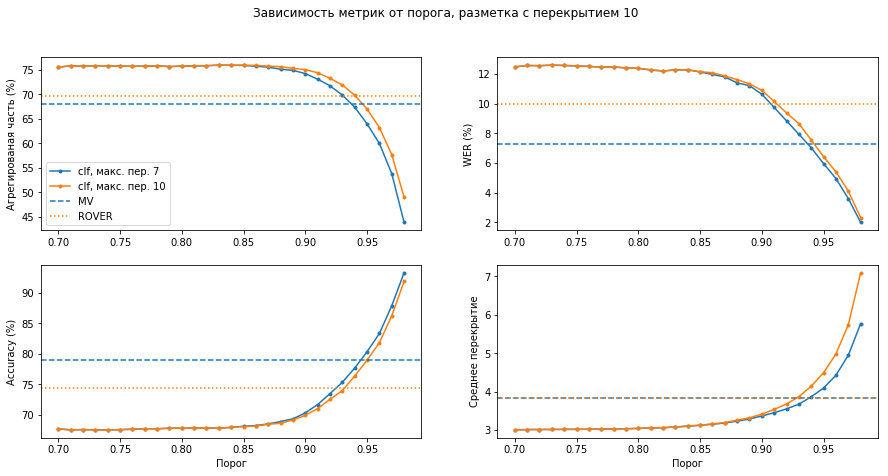

In [36]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость метрик от порога, разметка с перекрытием 10')
plt.subplot(221)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 10")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.axhline(y=rover_agg_metrics[0] * 100, color=u'#ff7f0e', linestyle=':', label="ROVER")
plt.legend()
plt.ylabel('Агрегированая часть (%)')

plt.subplot(222)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 2] * 100, 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 2] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[1] * 100, color=u'#ff7f0e', linestyle=':')

plt.ylabel('WER (%)')


plt.subplot(223)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 3] * 100, 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 3] * 100, 
         ".-")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[2] * 100, color=u'#ff7f0e', linestyle=':')
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.subplot(224)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 4], 
         ".-")
plt.plot(scores_clf_assistant_new_max_cost_10[:, 0], 
         scores_clf_assistant_new_max_cost_10[:, 4], 
         ".-")
plt.axhline(y=prod_agg_metrics[3], color=u'#1f77b4', linestyle='--')
plt.axhline(y=rover_agg_metrics[3], color=u'#ff7f0e', linestyle=':')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')

plt.savefig("metrics_clf_new_assistant_true.png")
plt.show()

In [37]:
len(data_assistant_test_valid)

3486

In [38]:
from scipy.stats import norm

In [39]:
def err(value, n, conf=0.95):
    z = norm.ppf(conf)
    return z * np.sqrt(value * (1 - value) / n)

In [40]:
scores_clf_assistant_new_max_cost_7[:, 1]

array([0.7555938 , 0.75817556, 0.7578887 , 0.75817556, 0.75817556,
       0.75760184, 0.75731497, 0.75760184, 0.75817556, 0.75674125,
       0.75760184, 0.7578887 , 0.75846242, 0.75960987, 0.75932301,
       0.75903614, 0.75731497, 0.7555938 , 0.75129088, 0.74899598,
       0.74239816, 0.73092369, 0.71744119, 0.69850832, 0.67383821,
       0.63970166, 0.59982788, 0.53815261, 0.43861159])

In [41]:
test_words_count = [
    len(row['text'].split()) for row in data_assistant_test_valid
]
test_words_count = sum(test_words_count)

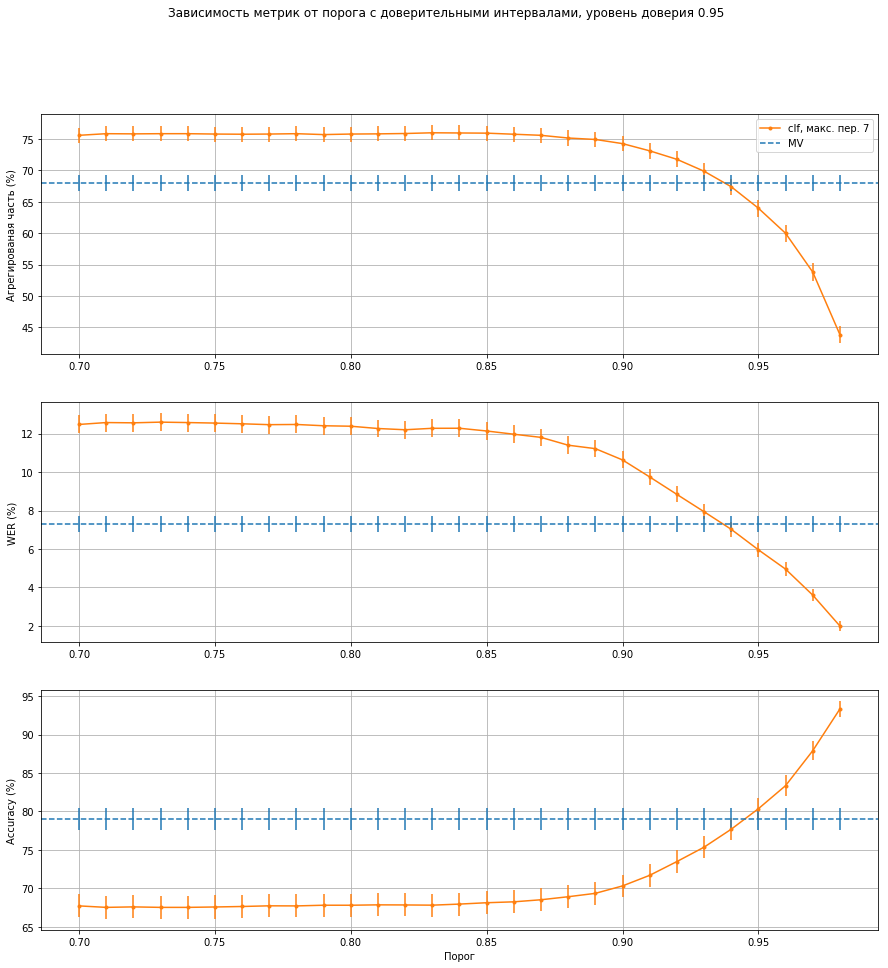

In [42]:
conf = 0.95

plt.figure(figsize=(15,15))
plt.suptitle('Зависимость метрик от порога с доверительными интервалами, уровень доверия {}'.format(conf))
plt.subplot(311)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 1] * 100,
            [err(val, len(data_assistant_test_valid), conf=conf) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:, 1]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV")
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[0] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            [err(val, len(data_assistant_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[0]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.ylabel('Агрегированая часть (%)')
plt.grid(True)
plt.legend()

plt.subplot(312)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 2] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 2] * 100,
            [err(val[2], val[5], conf=conf) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[1] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            [err(val, prod_agg_metrics[4], conf=conf) * 100 for val in 
            [prod_agg_metrics[1]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 3] * 100, 
         ".-",
         color=u'#ff7f0e')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            scores_clf_assistant_new_max_cost_7[:, 3] * 100,
            [err(metrics[3], metrics[1] * len(data_assistant_test_valid), conf=conf) * 100 for metrics in
            scores_clf_assistant_new_max_cost_7[:]],
            color=u'#ff7f0e',
            linestyle="None")
plt.axhline(y=prod_agg_metrics[2] * 100, color=u'#1f77b4', linestyle='--')
plt.errorbar(scores_clf_assistant_new_max_cost_7[:, 0],
            [prod_agg_metrics[2] * 100] * len(scores_clf_assistant_new_max_cost_7[:, 0]),
            yerr=[err(val, prod_agg_metrics[0] * len(data_assistant_test_valid), conf=conf) * 100 for val in 
            [prod_agg_metrics[2]] * len(scores_clf_assistant_new_max_cost_7[:, 0])],
            color=u'#1f77b4',
            linestyle="None")
plt.grid(True)
plt.ylabel('Accuracy (%)')

plt.xlabel('Порог')

plt.savefig("metrics_conf_int_assistant_true.png")
plt.show()

In [43]:
scores_clf_assistant_new_max_cost_7 = []

for treshhold in np.linspace(0.7, 0.98, 29):
    print(treshhold)
    metrics = evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    treshhold,
                                    max_cost=7)
    scores_clf_assistant_new_max_cost_7.append((treshhold, *metrics))
scores_clf_assistant_new_max_cost_7 = np.array(scores_clf_assistant_new_max_cost_7)

0.7
Aggregated: 75.5594%
WER: 12.4738%
Accuracy: 67.7297%
Mean overlap: 3.005
0.71
Aggregated: 75.8176%
WER: 12.5724%
Accuracy: 67.5369%
Mean overlap: 3.015
0.72
Aggregated: 75.7889%
WER: 12.5585%
Accuracy: 67.6003%
Mean overlap: 3.016
0.73
Aggregated: 75.8176%
WER: 12.5946%
Accuracy: 67.5369%
Mean overlap: 3.017
0.74
Aggregated: 75.8176%
WER: 12.5724%
Accuracy: 67.5369%
Mean overlap: 3.02
0.75
Aggregated: 75.7602%
WER: 12.5455%
Accuracy: 67.5880%
Mean overlap: 3.021
0.76
Aggregated: 75.7315%
WER: 12.5084%
Accuracy: 67.6515%
Mean overlap: 3.024
0.77
Aggregated: 75.7602%
WER: 12.4629%
Accuracy: 67.7395%
Mean overlap: 3.027
0.7799999999999999
Aggregated: 75.8176%
WER: 12.4731%
Accuracy: 67.7261%
Mean overlap: 3.031
0.7899999999999999
Aggregated: 75.6741%
WER: 12.4063%
Accuracy: 67.8165%
Mean overlap: 3.036
0.7999999999999999
Aggregated: 75.7602%
WER: 12.3822%
Accuracy: 67.8152%
Mean overlap: 3.046
0.8099999999999999
Aggregated: 75.7889%
WER: 12.2634%
Accuracy: 67.8653%
Mean overlap: 3.05

In [44]:
print('toloka_results')
print('Prod: ')
prod_agg_metrics = evaluate_metrics(data_assistant_test_valid, 'toloka_results', aggregate_prod)

toloka_results
Prod: 
Aggregated: 67.9862%
WER: 7.2800%
Accuracy: 79.0295%
Mean overlap: 3.833


In [45]:
scores_clf_assistant_new_max_cost_7[-6:-3, 3] * 100 + [err(metrics[3], metrics[1] * len(data_assistant_test_valid), conf=conf) * 100 for metrics in
            scores_clf_assistant_new_max_cost_7[:]][-6:-3]

array([76.79573323, 79.10549738, 81.74255298])

In [46]:
[err(val, len(data_assistant_test_valid), conf=0.95) * 100 for val in
            scores_clf_assistant_new_max_cost_7[:, 1]][-6:-3]

[1.278459643502849, 1.3060443458527236, 1.3374681043530634]

In [47]:
scores_clf_assistant_new_max_cost_7[-6:-3]

array([[9.30000000e-01, 6.98508319e-01, 7.93789809e-02, 7.53593429e-01,
        3.67641997e+00, 1.25600000e+04, 0.00000000e+00],
       [9.40000000e-01, 6.73838210e-01, 7.02249523e-02, 7.76926352e-01,
        3.86775674e+00, 1.20470000e+04, 0.00000000e+00],
       [9.50000000e-01, 6.39701664e-01, 5.95729725e-02, 8.03587444e-01,
        4.09695927e+00, 1.13810000e+04, 0.00000000e+00]])

In [48]:
prod_agg_metrics[2] * 100 + err(prod_agg_metrics[2], prod_agg_metrics[0] * len(data_quasar_test_valid), conf=conf) * 100

NameError: name 'data_quasar_test_valid' is not defined

In [ ]:
err(prod_agg_metrics[2], prod_agg_metrics[0] * len(data_assistant_test_valid), conf=conf) * 100

In [ ]:
plt.figure(figsize=(15,7))
plt.suptitle('Зависимость доли ошибок на')
plt.subplot(311)
plt.plot(scores_clf_assistant_new_max_cost_7[:, 0], 
         scores_clf_assistant_new_max_cost_7[:, 1] * 100, 
         ".-", 
         label="clf, макс. пер. 7",
         color=u'#ff7f0e')

In [49]:
def aggregate_rover_with_clf_and_empty_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, cluster_references=None):
    """
       aggregation from prod
    """
    clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [50]:
aggregation = aggregate_rover_with_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.94,
                                    max_cost=7)

In [55]:
def evaluate_metrics_from_dict(data, aggregation_results, treshhold=0, cluster_refernces=None, print_=True):
    errors = 0
    total_length = 0
    aggregated = 0
    total_items = 0
    correct = 0
    cost = 0
    words_count = 0
    aggregated_empty = 0
    false_empty = 0.0
    
    for row in data:
        if row["mark"] != "TEST":
            continue
        total_items += 1
        hyp = aggregation_results[row["mds_key"]]
        cost += hyp.cost
        if (hyp.text is None) or (hyp.confidence < treshhold):
            continue
        hyp = hyp.text
        aggregated += 1
        words_count += len(row["text"].split())
        _, e, l = calculate_wer(row["text"], hyp, cluster_refernces)
        errors += e
        if e == 0:
            correct += 1
        total_length += l
        if hyp == '':
            aggregated_empty += 1
            if row['text'] != '':
                false_empty += 1

    accuracy = correct / aggregated
    wer = errors / total_length
    aggregated_part = aggregated / total_items
    cost = cost / total_items
    if aggregated_empty:
        false_empty /= aggregated_empty
    if print_:
        print("Aggregated: {:.4%}\nWER: {:.4%}\nAccuracy: {:.4%}\nMean overlap: {:.4}\nEmpty error part: {:.4%}".format(
            aggregated_part, wer, accuracy, cost, false_empty
        ))
    return aggregated_part, wer, accuracy, cost, words_count, false_empty

In [56]:
def evaluate_metrics_clf_and_empty_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True):
    aggregation_results = aggregate_rover_with_clf_and_empty_(data, 
                                                    features, 
                                                    field_name, 
                                                    clf, 
                                                    treshhold, 
                                                    min_cost, 
                                                    max_cost, 
                                                    cluster_refernces)
    return evaluate_metrics_from_dict(data, aggregation_results, treshhold, cluster_refernces, print_)

In [53]:
evaluate_metrics_clf_and_empty_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.95,
                                    max_cost=7)

Aggregated: 85.0545%
WER: 6.5159%
Accuracy: 84.3170%
Mean overlap: 4.097
Empty error part: 3.6735%


(0.8505450372920252,
 0.06515852912918159,
 0.8431703204047217,
 4.096959265633965,
 11449,
 0.036734693877551024)

In [57]:
evaluate_metrics_clf_(data_assistant_test_valid, 
                                    data_assistant_new_test_features, 
                                    'toloka_results', 
                                    clf_new, 
                                    0.95,
                                    max_cost=7)

Aggregated: 63.9702%
WER: 5.9573%
Accuracy: 80.3587%
Mean overlap: 4.097
Empty error part: 0.0000%


(0.6397016637980494,
 0.05957297249802302,
 0.8035874439461883,
 4.096959265633965,
 11381,
 0.0)